In [7]:
import os
import natsort
from glob import glob
import pandas as pd
import numpy as np
import warnings
import io
import csv
import statistics
from pandas.core.frame import DataFrame
from scipy import io
from scipy.interpolate import splrep, splev
from scipy.stats import skew, kurtosis
from scipy import signal, fftpack
from sys import platform
import xgboost as xgb
from xgboost import *
import lightgbm as lgb
from lightgbm import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import *
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import *
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
import math
import shap
import tensorflow as tf
import keras.backend as K 
from keras.layers import Dense, LSTM, GRU, SimpleRNN, RNN, Conv1D, Conv2D, Conv3D
from keras.layers import Input, Dropout, Flatten, BatchNormalization, LayerNormalization
from keras.layers import Embedding, Bidirectional
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, RMSprop
from keras.constraints import MaxNorm
from keras.metrics import mean_absolute_percentage_error, RootMeanSquaredError
from keras.utils import plot_model
from keras.utils import model_to_dot

# Data Load

In [8]:
data_cycle = 'all_condition_stat_cycle_filtered.csv'

In [9]:
data = pd.read_csv("./data/"+data_cycle)
data

,RMS_CF_max,RMS_ACC_mean,RMS_ACC_std,RMS_ACC_median,RMS_ACC_min,RMS_ACC_max,RMS_ACC_skew,RMS_ACC_kurt,RMS_SPINDLE_V_mean,RMS_SPINDLE_V_std,...,SOUND_median,SOUND_min,SOUND_max,SOUND_skew,SOUND_kurt,Ae,Ap,rpm,feed,Milling_Type
0,66.346929,0.244161,0.283664,0.147595,0.005578,1.640208,2.684610,7.875414,74.921787,52.044972,...,0.037162,-0.259393,0.419544,0.255735,-0.168187,1,1.0,3000,300,down
1,66.297981,0.245841,0.264163,0.166304,0.003941,1.631323,2.895762,9.944875,75.527169,52.062288,...,-0.015675,-0.355162,0.402921,0.043373,0.438830,1,1.0,3000,300,down
2,66.577786,0.231463,0.255632,0.150313,0.010979,1.751155,2.908877,10.447245,75.933828,51.175746,...,-0.068800,-0.342743,0.341331,0.139751,-0.499427,1,1.0,3000,300,down
3,66.980319,0.238938,0.260048,0.154622,0.008462,1.843098,2.843921,10.433196,75.827492,51.411571,...,-0.017526,-0.364834,0.332737,0.036950,-0.528745,1,1.0,3000,300,down
4,67.546219,0.242432,0.259848,0.160682,0.007866,1.808103,2.874952,10.639415,75.726991,52.006348,...,-0.060268,-0.388372,0.296290,-0.180871,-0.520753,1,1.0,3000,300,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215052,580.818322,3.133201,2.587196,2.310177,0.213215,13.073614,1.431366,1.851970,54.386073,44.422093,...,-0.219265,-2.766058,4.170769,0.553080,0.067663,4,6.0,5000,500,up
215053,582.032368,3.721833,2.669275,3.034522,0.380387,14.117784,1.681629,3.203336,57.948220,42.156799,...,-0.161040,-2.854631,3.320326,0.233940,-0.496502,4,6.0,5000,500,up
215054,583.426041,3.511822,2.444397,2.999400,0.492054,13.476082,1.526276,2.936469,55.148492,43.277311,...,-0.034108,-2.835090,3.020172,0.207604,-0.521229,4,6.0,5000,500,up
215055,580.350537,3.449806,2.239240,3.012830,0.292238,10.928611,1.126394,1.072886,58.075829,45.329429,...,-0.153948,-3.146117,2.982659,0.284559,-0.278496,4,6.0,5000,500,up


In [10]:
groups_type = data.groupby('Milling_Type')

down = groups_type.get_group('down')
down = down.reset_index(drop=True)

up = groups_type.get_group('up')
up = up.reset_index(drop=True)

In [11]:
groups_ae = down.groupby('Ae')
groups_ap = down.groupby('Ap')
groups_feed = down.groupby('feed')
groups_rpm = down.groupby('rpm')

# Ae

In [12]:
ae_1 = groups_ae.get_group(1)
ae_1 = ae_1.reset_index(drop=True)
ae_1 = ae_1.drop(['Milling_Type'], axis=1)

ae_2 = groups_ae.get_group(2)
ae_2 = ae_2.reset_index(drop=True)
ae_2 = ae_2.drop(['Milling_Type'], axis=1)

ae_3 = groups_ae.get_group(3)
ae_3 = ae_3.reset_index(drop=True)
ae_3 = ae_3.drop(['Milling_Type'], axis=1)

ae_4 = groups_ae.get_group(4)
ae_4 = ae_4.reset_index(drop=True)
ae_4 = ae_4.drop(['Milling_Type'], axis=1)

## Ae 1

In [13]:
train = pd.concat([ae_2, ae_3, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [14]:
X_test = ae_1.iloc[: , 1:]
y_test = ae_1['RMS_CF_max']

In [15]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 170,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:309.95315	validation_0-mape:0.98776	validation_1-rmse:197.47911	validation_1-mape:0.98291
[1]	validation_0-rmse:306.86310	validation_0-mape:0.97787	validation_1-rmse:194.80979	validation_1-mape:0.96937
[2]	validation_0-rmse:303.80397	validation_0-mape:0.96808	validation_1-rmse:192.16748	validation_1-mape:0.95598
[3]	validation_0-rmse:300.77547	validation_0-mape:0.95838	validation_1-rmse:189.55200	validation_1-mape:0.94273
[4]	validation_0-rmse:297.77746	validation_0-mape:0.94878	validation_1-rmse:186.96353	validation_1-mape:0.92960
[5]	validation_0-rmse:294.80942	validation_0-mape:0.93928	validation_1-rmse:184.39959	validation_1-mape:0.91661
[6]	validation_0-rmse:291.87104	validation_0-mape:0.92987	validation_1-rmse:181.85239	validation_1-mape:0.90371
[7]	validation_0-rmse:288.96209	validation_0-mape:0.92056	validation_1-rmse:179.34322	validation_1-mape:0.89100
[8]	validation_0-rmse:286.08224	validation_0-mape:0.91134	validation_1-rmse:176.85661	validation_1-mape:

[73]	validation_0-rmse:149.32736	validation_0-mape:0.47351	validation_1-rmse:58.99853	validation_1-mape:0.27954
[74]	validation_0-rmse:147.84378	validation_0-mape:0.46876	validation_1-rmse:57.75009	validation_1-mape:0.27306
[75]	validation_0-rmse:146.37500	validation_0-mape:0.46406	validation_1-rmse:56.53492	validation_1-mape:0.26676
[76]	validation_0-rmse:144.92022	validation_0-mape:0.45941	validation_1-rmse:55.30121	validation_1-mape:0.26042
[77]	validation_0-rmse:143.48088	validation_0-mape:0.45480	validation_1-rmse:54.11634	validation_1-mape:0.25427
[78]	validation_0-rmse:142.05504	validation_0-mape:0.45024	validation_1-rmse:52.91429	validation_1-mape:0.24806
[79]	validation_0-rmse:140.64426	validation_0-mape:0.44572	validation_1-rmse:51.72474	validation_1-mape:0.24193
[80]	validation_0-rmse:139.24740	validation_0-mape:0.44125	validation_1-rmse:50.54984	validation_1-mape:0.23582
[81]	validation_0-rmse:137.86443	validation_0-mape:0.43683	validation_1-rmse:49.41057	validation_1-mape:

[147]	validation_0-rmse:71.41377	validation_0-mape:0.22454	validation_1-rmse:16.02570	validation_1-mape:0.07062
[148]	validation_0-rmse:70.70692	validation_0-mape:0.22229	validation_1-rmse:16.42127	validation_1-mape:0.07291
[149]	validation_0-rmse:70.00704	validation_0-mape:0.22006	validation_1-rmse:16.81811	validation_1-mape:0.07517
[150]	validation_0-rmse:69.31449	validation_0-mape:0.21785	validation_1-rmse:17.23682	validation_1-mape:0.07747
[151]	validation_0-rmse:68.62861	validation_0-mape:0.21566	validation_1-rmse:17.65254	validation_1-mape:0.07978
[152]	validation_0-rmse:67.94960	validation_0-mape:0.21350	validation_1-rmse:18.07720	validation_1-mape:0.08211
[153]	validation_0-rmse:67.27739	validation_0-mape:0.21136	validation_1-rmse:18.50390	validation_1-mape:0.08444
[154]	validation_0-rmse:66.61203	validation_0-mape:0.20924	validation_1-rmse:18.92631	validation_1-mape:0.08677
[155]	validation_0-rmse:65.95326	validation_0-mape:0.20714	validation_1-rmse:19.36665	validation_1-mape:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=170, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [20]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 57.3931
Train MAPE: 17.9861
Test RMSE: 25.5477
Test MAPE: 12.3399


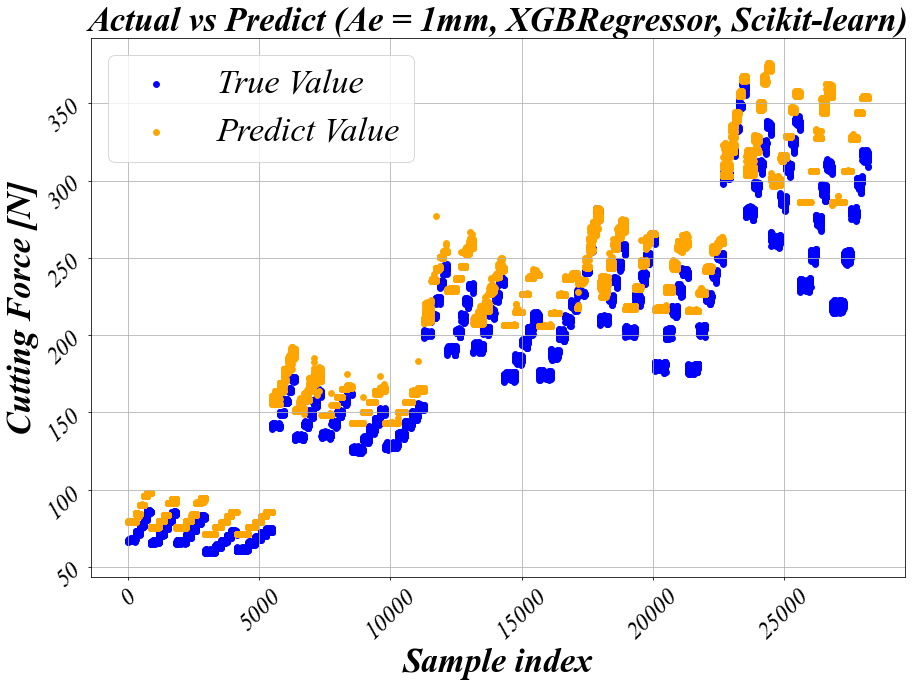

In [21]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 1mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ae1 cycle.png")

## Ae 2

In [22]:
train = pd.concat([ae_1, ae_3, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [23]:
X_test = ae_2.iloc[: , 1:]
y_test = ae_2['RMS_CF_max']

In [24]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 300,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:290.62196	validation_0-mape:0.98742	validation_1-rmse:273.83919	validation_1-mape:0.98715
[1]	validation_0-rmse:287.73222	validation_0-mape:0.97749	validation_1-rmse:271.00920	validation_1-mape:0.97674
[2]	validation_0-rmse:284.87142	validation_0-mape:0.96767	validation_1-rmse:268.20765	validation_1-mape:0.96642
[3]	validation_0-rmse:282.03980	validation_0-mape:0.95794	validation_1-rmse:265.45012	validation_1-mape:0.95631
[4]	validation_0-rmse:279.23620	validation_0-mape:0.94831	validation_1-rmse:262.70463	validation_1-mape:0.94620
[5]	validation_0-rmse:276.46116	validation_0-mape:0.93878	validation_1-rmse:260.00256	validation_1-mape:0.93629
[6]	validation_0-rmse:273.71358	validation_0-mape:0.92934	validation_1-rmse:257.31224	validation_1-mape:0.92638
[7]	validation_0-rmse:270.99345	validation_0-mape:0.91999	validation_1-rmse:254.67522	validation_1-mape:0.91674
[8]	validation_0-rmse:268.29919	validation_0-mape:0.91075	validation_1-rmse:252.03736	validation_1-mape:

[73]	validation_0-rmse:140.29450	validation_0-mape:0.47223	validation_1-rmse:124.38407	validation_1-mape:0.43616
[74]	validation_0-rmse:138.90722	validation_0-mape:0.46748	validation_1-rmse:123.08385	validation_1-mape:0.43117
[75]	validation_0-rmse:137.53373	validation_0-mape:0.46276	validation_1-rmse:121.78835	validation_1-mape:0.42617
[76]	validation_0-rmse:136.17216	validation_0-mape:0.45811	validation_1-rmse:120.47321	validation_1-mape:0.42117
[77]	validation_0-rmse:134.82568	validation_0-mape:0.45349	validation_1-rmse:119.17040	validation_1-mape:0.41625
[78]	validation_0-rmse:133.49220	validation_0-mape:0.44892	validation_1-rmse:117.91077	validation_1-mape:0.41157
[79]	validation_0-rmse:132.17290	validation_0-mape:0.44440	validation_1-rmse:116.64475	validation_1-mape:0.40672
[80]	validation_0-rmse:130.86602	validation_0-mape:0.43992	validation_1-rmse:115.42862	validation_1-mape:0.40216
[81]	validation_0-rmse:129.57296	validation_0-mape:0.43549	validation_1-rmse:114.18573	validatio

[146]	validation_0-rmse:68.08323	validation_0-mape:0.22558	validation_1-rmse:55.98286	validation_1-mape:0.17366
[147]	validation_0-rmse:67.41467	validation_0-mape:0.22331	validation_1-rmse:55.32087	validation_1-mape:0.17107
[148]	validation_0-rmse:66.75366	validation_0-mape:0.22106	validation_1-rmse:54.67241	validation_1-mape:0.16853
[149]	validation_0-rmse:66.09904	validation_0-mape:0.21884	validation_1-rmse:54.04816	validation_1-mape:0.16602
[150]	validation_0-rmse:65.45021	validation_0-mape:0.21664	validation_1-rmse:53.41642	validation_1-mape:0.16352
[151]	validation_0-rmse:64.80903	validation_0-mape:0.21446	validation_1-rmse:52.79182	validation_1-mape:0.16105
[152]	validation_0-rmse:64.17409	validation_0-mape:0.21230	validation_1-rmse:52.24114	validation_1-mape:0.15876
[153]	validation_0-rmse:63.54463	validation_0-mape:0.21017	validation_1-rmse:51.63381	validation_1-mape:0.15632
[154]	validation_0-rmse:62.92244	validation_0-mape:0.20806	validation_1-rmse:51.08767	validation_1-mape:

[220]	validation_0-rmse:33.10736	validation_0-mape:0.10686	validation_1-rmse:27.68007	validation_1-mape:0.05936
[221]	validation_0-rmse:32.79229	validation_0-mape:0.10579	validation_1-rmse:27.51192	validation_1-mape:0.05901
[222]	validation_0-rmse:32.48025	validation_0-mape:0.10473	validation_1-rmse:27.33418	validation_1-mape:0.05866
[223]	validation_0-rmse:32.17138	validation_0-mape:0.10369	validation_1-rmse:27.15545	validation_1-mape:0.05834
[224]	validation_0-rmse:31.86538	validation_0-mape:0.10265	validation_1-rmse:26.98887	validation_1-mape:0.05803
[225]	validation_0-rmse:31.56384	validation_0-mape:0.10162	validation_1-rmse:26.83539	validation_1-mape:0.05780
[226]	validation_0-rmse:31.26555	validation_0-mape:0.10061	validation_1-rmse:26.68585	validation_1-mape:0.05759
[227]	validation_0-rmse:30.96887	validation_0-mape:0.09960	validation_1-rmse:26.53500	validation_1-mape:0.05737
[228]	validation_0-rmse:30.67526	validation_0-mape:0.09860	validation_1-rmse:26.37566	validation_1-mape:

[294]	validation_0-rmse:16.75567	validation_0-mape:0.05141	validation_1-rmse:22.02209	validation_1-mape:0.06149
[295]	validation_0-rmse:16.61183	validation_0-mape:0.05092	validation_1-rmse:22.01163	validation_1-mape:0.06162
[296]	validation_0-rmse:16.46972	validation_0-mape:0.05044	validation_1-rmse:22.01211	validation_1-mape:0.06179
[297]	validation_0-rmse:16.32981	validation_0-mape:0.04996	validation_1-rmse:22.01592	validation_1-mape:0.06194
[298]	validation_0-rmse:16.18934	validation_0-mape:0.04948	validation_1-rmse:22.01217	validation_1-mape:0.06209
[299]	validation_0-rmse:16.05122	validation_0-mape:0.04901	validation_1-rmse:22.02393	validation_1-mape:0.06229


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [47]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 16.0512
Train MAPE: 4.9007
Test RMSE: 22.0239
Test MAPE: 6.2292


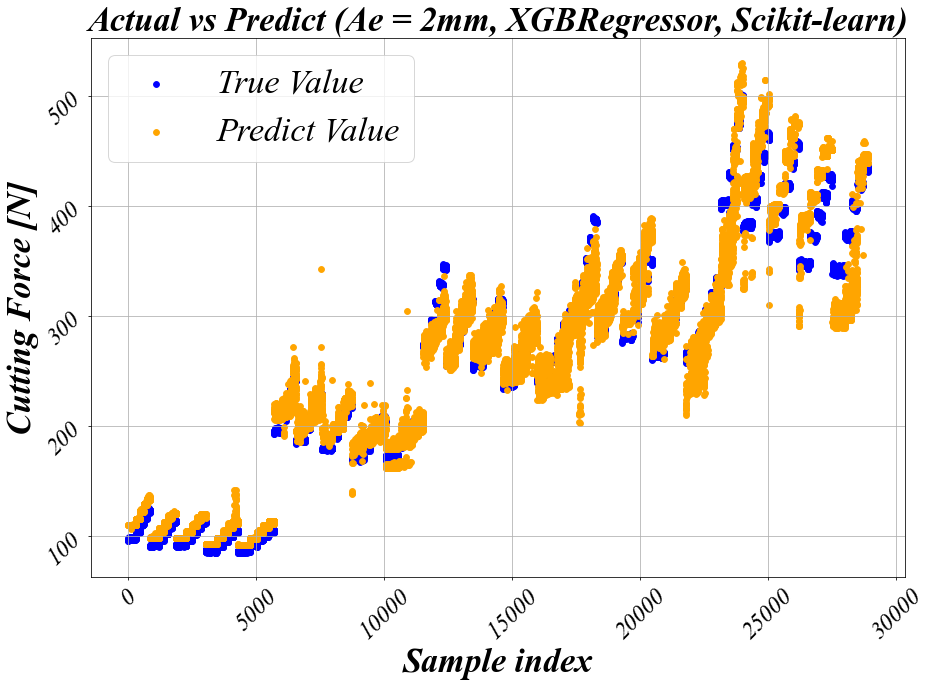

In [48]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 2mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ae2 cycle.png")

## Ae3

In [49]:
train = pd.concat([ae_1, ae_2, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [50]:
X_test = ae_3.iloc[: , 1:]
y_test = ae_3['RMS_CF_max']

In [51]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [52]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:276.38993	validation_0-mape:0.98731	validation_1-rmse:314.63075	validation_1-mape:0.98817
[1]	validation_0-rmse:273.64390	validation_0-mape:0.97739	validation_1-rmse:311.63228	validation_1-mape:0.97862
[2]	validation_0-rmse:270.92605	validation_0-mape:0.96756	validation_1-rmse:308.67408	validation_1-mape:0.96917
[3]	validation_0-rmse:268.23557	validation_0-mape:0.95783	validation_1-rmse:305.73220	validation_1-mape:0.95980
[4]	validation_0-rmse:265.57125	validation_0-mape:0.94820	validation_1-rmse:302.80877	validation_1-mape:0.95050
[5]	validation_0-rmse:262.93336	validation_0-mape:0.93867	validation_1-rmse:299.89381	validation_1-mape:0.94124
[6]	validation_0-rmse:260.32048	validation_0-mape:0.92924	validation_1-rmse:296.90352	validation_1-mape:0.93196
[7]	validation_0-rmse:257.73518	validation_0-mape:0.91990	validation_1-rmse:294.06679	validation_1-mape:0.92291
[8]	validation_0-rmse:255.17441	validation_0-mape:0.91065	validation_1-rmse:291.13548	validation_1-mape:

[73]	validation_0-rmse:133.63615	validation_0-mape:0.47159	validation_1-rmse:153.81263	validation_1-mape:0.48266
[74]	validation_0-rmse:132.31851	validation_0-mape:0.46683	validation_1-rmse:152.37514	validation_1-mape:0.47811
[75]	validation_0-rmse:131.01088	validation_0-mape:0.46212	validation_1-rmse:150.92076	validation_1-mape:0.47347
[76]	validation_0-rmse:129.71923	validation_0-mape:0.45746	validation_1-rmse:149.50334	validation_1-mape:0.46893
[77]	validation_0-rmse:128.43803	validation_0-mape:0.45285	validation_1-rmse:148.10375	validation_1-mape:0.46449
[78]	validation_0-rmse:127.16937	validation_0-mape:0.44829	validation_1-rmse:146.69402	validation_1-mape:0.45999
[79]	validation_0-rmse:125.91322	validation_0-mape:0.44378	validation_1-rmse:145.30832	validation_1-mape:0.45561
[80]	validation_0-rmse:124.67135	validation_0-mape:0.43930	validation_1-rmse:143.88924	validation_1-mape:0.45117
[81]	validation_0-rmse:123.44264	validation_0-mape:0.43487	validation_1-rmse:142.49063	validatio

[146]	validation_0-rmse:65.03723	validation_0-mape:0.22504	validation_1-rmse:77.25403	validation_1-mape:0.23993
[147]	validation_0-rmse:64.40554	validation_0-mape:0.22277	validation_1-rmse:76.56593	validation_1-mape:0.23774
[148]	validation_0-rmse:63.77951	validation_0-mape:0.22052	validation_1-rmse:75.85444	validation_1-mape:0.23550
[149]	validation_0-rmse:63.15709	validation_0-mape:0.21830	validation_1-rmse:75.14494	validation_1-mape:0.23328
[150]	validation_0-rmse:62.54086	validation_0-mape:0.21610	validation_1-rmse:74.44762	validation_1-mape:0.23110
[151]	validation_0-rmse:61.93189	validation_0-mape:0.21392	validation_1-rmse:73.78901	validation_1-mape:0.22901
[152]	validation_0-rmse:61.32904	validation_0-mape:0.21177	validation_1-rmse:73.11198	validation_1-mape:0.22682
[153]	validation_0-rmse:60.73197	validation_0-mape:0.20963	validation_1-rmse:72.42970	validation_1-mape:0.22464
[154]	validation_0-rmse:60.14115	validation_0-mape:0.20752	validation_1-rmse:71.75919	validation_1-mape:

[220]	validation_0-rmse:31.66158	validation_0-mape:0.10669	validation_1-rmse:37.97356	validation_1-mape:0.11571
[221]	validation_0-rmse:31.35988	validation_0-mape:0.10562	validation_1-rmse:37.60740	validation_1-mape:0.11453
[222]	validation_0-rmse:31.06132	validation_0-mape:0.10457	validation_1-rmse:37.24129	validation_1-mape:0.11335
[223]	validation_0-rmse:30.76579	validation_0-mape:0.10352	validation_1-rmse:36.88358	validation_1-mape:0.11220
[224]	validation_0-rmse:30.47347	validation_0-mape:0.10249	validation_1-rmse:36.52051	validation_1-mape:0.11103
[225]	validation_0-rmse:30.18404	validation_0-mape:0.10146	validation_1-rmse:36.17141	validation_1-mape:0.10991
[226]	validation_0-rmse:29.89768	validation_0-mape:0.10045	validation_1-rmse:35.82083	validation_1-mape:0.10879
[227]	validation_0-rmse:29.61436	validation_0-mape:0.09945	validation_1-rmse:35.49131	validation_1-mape:0.10773
[228]	validation_0-rmse:29.33415	validation_0-mape:0.09845	validation_1-rmse:35.15079	validation_1-mape:

[294]	validation_0-rmse:16.06984	validation_0-mape:0.05118	validation_1-rmse:19.69693	validation_1-mape:0.05705
[295]	validation_0-rmse:15.93296	validation_0-mape:0.05068	validation_1-rmse:19.55690	validation_1-mape:0.05658
[296]	validation_0-rmse:15.79723	validation_0-mape:0.05019	validation_1-rmse:19.40457	validation_1-mape:0.05610
[297]	validation_0-rmse:15.66307	validation_0-mape:0.04971	validation_1-rmse:19.25191	validation_1-mape:0.05561
[298]	validation_0-rmse:15.52994	validation_0-mape:0.04923	validation_1-rmse:19.10813	validation_1-mape:0.05515
[299]	validation_0-rmse:15.39863	validation_0-mape:0.04876	validation_1-rmse:18.96363	validation_1-mape:0.05468
[300]	validation_0-rmse:15.26866	validation_0-mape:0.04829	validation_1-rmse:18.82567	validation_1-mape:0.05424
[301]	validation_0-rmse:15.14037	validation_0-mape:0.04783	validation_1-rmse:18.69781	validation_1-mape:0.05381
[302]	validation_0-rmse:15.01310	validation_0-mape:0.04738	validation_1-rmse:18.56325	validation_1-mape:

[368]	validation_0-rmse:9.14214	validation_0-mape:0.02660	validation_1-rmse:12.34719	validation_1-mape:0.03417
[369]	validation_0-rmse:9.08421	validation_0-mape:0.02640	validation_1-rmse:12.30030	validation_1-mape:0.03402
[370]	validation_0-rmse:9.02657	validation_0-mape:0.02621	validation_1-rmse:12.23880	validation_1-mape:0.03385
[371]	validation_0-rmse:8.96968	validation_0-mape:0.02601	validation_1-rmse:12.18563	validation_1-mape:0.03370
[372]	validation_0-rmse:8.91365	validation_0-mape:0.02582	validation_1-rmse:12.13054	validation_1-mape:0.03354
[373]	validation_0-rmse:8.85834	validation_0-mape:0.02563	validation_1-rmse:12.06883	validation_1-mape:0.03336
[374]	validation_0-rmse:8.80392	validation_0-mape:0.02545	validation_1-rmse:12.02456	validation_1-mape:0.03323
[375]	validation_0-rmse:8.74999	validation_0-mape:0.02526	validation_1-rmse:11.97595	validation_1-mape:0.03309
[376]	validation_0-rmse:8.69664	validation_0-mape:0.02508	validation_1-rmse:11.92748	validation_1-mape:0.03294
[

[442]	validation_0-rmse:6.36631	validation_0-mape:0.01734	validation_1-rmse:10.09055	validation_1-mape:0.02738
[443]	validation_0-rmse:6.34428	validation_0-mape:0.01727	validation_1-rmse:10.08141	validation_1-mape:0.02735
[444]	validation_0-rmse:6.32237	validation_0-mape:0.01720	validation_1-rmse:10.06783	validation_1-mape:0.02731
[445]	validation_0-rmse:6.30071	validation_0-mape:0.01713	validation_1-rmse:10.05389	validation_1-mape:0.02727
[446]	validation_0-rmse:6.27937	validation_0-mape:0.01707	validation_1-rmse:10.04416	validation_1-mape:0.02724
[447]	validation_0-rmse:6.25907	validation_0-mape:0.01700	validation_1-rmse:10.03443	validation_1-mape:0.02721
[448]	validation_0-rmse:6.23917	validation_0-mape:0.01694	validation_1-rmse:10.01975	validation_1-mape:0.02717
[449]	validation_0-rmse:6.21865	validation_0-mape:0.01688	validation_1-rmse:10.01073	validation_1-mape:0.02714
[450]	validation_0-rmse:6.19872	validation_0-mape:0.01681	validation_1-rmse:10.00070	validation_1-mape:0.02711
[

[517]	validation_0-rmse:5.29703	validation_0-mape:0.01414	validation_1-rmse:9.63796	validation_1-mape:0.02603
[518]	validation_0-rmse:5.28860	validation_0-mape:0.01411	validation_1-rmse:9.63766	validation_1-mape:0.02603
[519]	validation_0-rmse:5.27850	validation_0-mape:0.01409	validation_1-rmse:9.63586	validation_1-mape:0.02602
[520]	validation_0-rmse:5.26950	validation_0-mape:0.01406	validation_1-rmse:9.63489	validation_1-mape:0.02601
[521]	validation_0-rmse:5.25954	validation_0-mape:0.01404	validation_1-rmse:9.63132	validation_1-mape:0.02600
[522]	validation_0-rmse:5.25125	validation_0-mape:0.01401	validation_1-rmse:9.63192	validation_1-mape:0.02600
[523]	validation_0-rmse:5.24414	validation_0-mape:0.01399	validation_1-rmse:9.62572	validation_1-mape:0.02598
[524]	validation_0-rmse:5.23467	validation_0-mape:0.01397	validation_1-rmse:9.62393	validation_1-mape:0.02597
[525]	validation_0-rmse:5.22602	validation_0-mape:0.01395	validation_1-rmse:9.62139	validation_1-mape:0.02597
[526]	vali

[592]	validation_0-rmse:4.82767	validation_0-mape:0.01300	validation_1-rmse:9.54510	validation_1-mape:0.02571
[593]	validation_0-rmse:4.82296	validation_0-mape:0.01299	validation_1-rmse:9.54354	validation_1-mape:0.02571
[594]	validation_0-rmse:4.81844	validation_0-mape:0.01298	validation_1-rmse:9.54433	validation_1-mape:0.02571
[595]	validation_0-rmse:4.81419	validation_0-mape:0.01297	validation_1-rmse:9.54392	validation_1-mape:0.02571
[596]	validation_0-rmse:4.80863	validation_0-mape:0.01296	validation_1-rmse:9.54386	validation_1-mape:0.02571
[597]	validation_0-rmse:4.80518	validation_0-mape:0.01295	validation_1-rmse:9.54300	validation_1-mape:0.02570
[598]	validation_0-rmse:4.80086	validation_0-mape:0.01294	validation_1-rmse:9.54391	validation_1-mape:0.02570
[599]	validation_0-rmse:4.79667	validation_0-mape:0.01293	validation_1-rmse:9.54502	validation_1-mape:0.02571
[600]	validation_0-rmse:4.79203	validation_0-mape:0.01293	validation_1-rmse:9.54477	validation_1-mape:0.02570
[601]	vali

[667]	validation_0-rmse:4.56008	validation_0-mape:0.01241	validation_1-rmse:9.51026	validation_1-mape:0.02562
[668]	validation_0-rmse:4.55685	validation_0-mape:0.01240	validation_1-rmse:9.50613	validation_1-mape:0.02561
[669]	validation_0-rmse:4.55413	validation_0-mape:0.01240	validation_1-rmse:9.50703	validation_1-mape:0.02561
[670]	validation_0-rmse:4.55059	validation_0-mape:0.01239	validation_1-rmse:9.50661	validation_1-mape:0.02561
[671]	validation_0-rmse:4.54736	validation_0-mape:0.01238	validation_1-rmse:9.50588	validation_1-mape:0.02561
[672]	validation_0-rmse:4.54379	validation_0-mape:0.01238	validation_1-rmse:9.50495	validation_1-mape:0.02560
[673]	validation_0-rmse:4.54128	validation_0-mape:0.01237	validation_1-rmse:9.50593	validation_1-mape:0.02561
[674]	validation_0-rmse:4.53866	validation_0-mape:0.01236	validation_1-rmse:9.50564	validation_1-mape:0.02561
[675]	validation_0-rmse:4.53501	validation_0-mape:0.01235	validation_1-rmse:9.50441	validation_1-mape:0.02560
[676]	vali

[742]	validation_0-rmse:4.36726	validation_0-mape:0.01198	validation_1-rmse:9.49702	validation_1-mape:0.02557
[743]	validation_0-rmse:4.36552	validation_0-mape:0.01197	validation_1-rmse:9.49720	validation_1-mape:0.02557
[744]	validation_0-rmse:4.36203	validation_0-mape:0.01197	validation_1-rmse:9.49407	validation_1-mape:0.02556
[745]	validation_0-rmse:4.36026	validation_0-mape:0.01196	validation_1-rmse:9.49516	validation_1-mape:0.02556
[746]	validation_0-rmse:4.35785	validation_0-mape:0.01196	validation_1-rmse:9.49432	validation_1-mape:0.02556
[747]	validation_0-rmse:4.35559	validation_0-mape:0.01195	validation_1-rmse:9.49409	validation_1-mape:0.02556
[748]	validation_0-rmse:4.35361	validation_0-mape:0.01195	validation_1-rmse:9.49503	validation_1-mape:0.02556
[749]	validation_0-rmse:4.35146	validation_0-mape:0.01194	validation_1-rmse:9.49478	validation_1-mape:0.02556
[750]	validation_0-rmse:4.34978	validation_0-mape:0.01194	validation_1-rmse:9.49474	validation_1-mape:0.02556
[751]	vali

[817]	validation_0-rmse:4.20663	validation_0-mape:0.01162	validation_1-rmse:9.46094	validation_1-mape:0.02548
[818]	validation_0-rmse:4.20515	validation_0-mape:0.01162	validation_1-rmse:9.46145	validation_1-mape:0.02548
[819]	validation_0-rmse:4.20296	validation_0-mape:0.01161	validation_1-rmse:9.46063	validation_1-mape:0.02548
[820]	validation_0-rmse:4.20122	validation_0-mape:0.01161	validation_1-rmse:9.45907	validation_1-mape:0.02548
[821]	validation_0-rmse:4.19864	validation_0-mape:0.01160	validation_1-rmse:9.45553	validation_1-mape:0.02547
[822]	validation_0-rmse:4.19720	validation_0-mape:0.01160	validation_1-rmse:9.45576	validation_1-mape:0.02547
[823]	validation_0-rmse:4.19502	validation_0-mape:0.01160	validation_1-rmse:9.45418	validation_1-mape:0.02547
[824]	validation_0-rmse:4.19318	validation_0-mape:0.01159	validation_1-rmse:9.45680	validation_1-mape:0.02548
[825]	validation_0-rmse:4.19124	validation_0-mape:0.01159	validation_1-rmse:9.45656	validation_1-mape:0.02547
[826]	vali

[892]	validation_0-rmse:4.07287	validation_0-mape:0.01131	validation_1-rmse:9.44052	validation_1-mape:0.02541
[893]	validation_0-rmse:4.07125	validation_0-mape:0.01130	validation_1-rmse:9.43957	validation_1-mape:0.02540
[894]	validation_0-rmse:4.06935	validation_0-mape:0.01130	validation_1-rmse:9.44116	validation_1-mape:0.02541
[895]	validation_0-rmse:4.06815	validation_0-mape:0.01130	validation_1-rmse:9.44152	validation_1-mape:0.02541
[896]	validation_0-rmse:4.06634	validation_0-mape:0.01129	validation_1-rmse:9.44091	validation_1-mape:0.02540
[897]	validation_0-rmse:4.06505	validation_0-mape:0.01129	validation_1-rmse:9.43993	validation_1-mape:0.02540
[898]	validation_0-rmse:4.06324	validation_0-mape:0.01128	validation_1-rmse:9.43913	validation_1-mape:0.02540
[899]	validation_0-rmse:4.06197	validation_0-mape:0.01128	validation_1-rmse:9.43876	validation_1-mape:0.02540
[900]	validation_0-rmse:4.06061	validation_0-mape:0.01128	validation_1-rmse:9.43942	validation_1-mape:0.02540
[901]	vali

[967]	validation_0-rmse:3.94356	validation_0-mape:0.01099	validation_1-rmse:9.40890	validation_1-mape:0.02531
[968]	validation_0-rmse:3.94048	validation_0-mape:0.01099	validation_1-rmse:9.40787	validation_1-mape:0.02531
[969]	validation_0-rmse:3.93915	validation_0-mape:0.01098	validation_1-rmse:9.40819	validation_1-mape:0.02531
[970]	validation_0-rmse:3.93747	validation_0-mape:0.01098	validation_1-rmse:9.40858	validation_1-mape:0.02531
[971]	validation_0-rmse:3.93582	validation_0-mape:0.01097	validation_1-rmse:9.40795	validation_1-mape:0.02530
[972]	validation_0-rmse:3.93348	validation_0-mape:0.01097	validation_1-rmse:9.40389	validation_1-mape:0.02530
[973]	validation_0-rmse:3.93206	validation_0-mape:0.01097	validation_1-rmse:9.40427	validation_1-mape:0.02530
[974]	validation_0-rmse:3.93051	validation_0-mape:0.01096	validation_1-rmse:9.40346	validation_1-mape:0.02530
[975]	validation_0-rmse:3.92903	validation_0-mape:0.01096	validation_1-rmse:9.40339	validation_1-mape:0.02530
[976]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [53]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 3.8915
Train MAPE: 1.0874
Test RMSE: 9.3899
Test MAPE: 2.5262


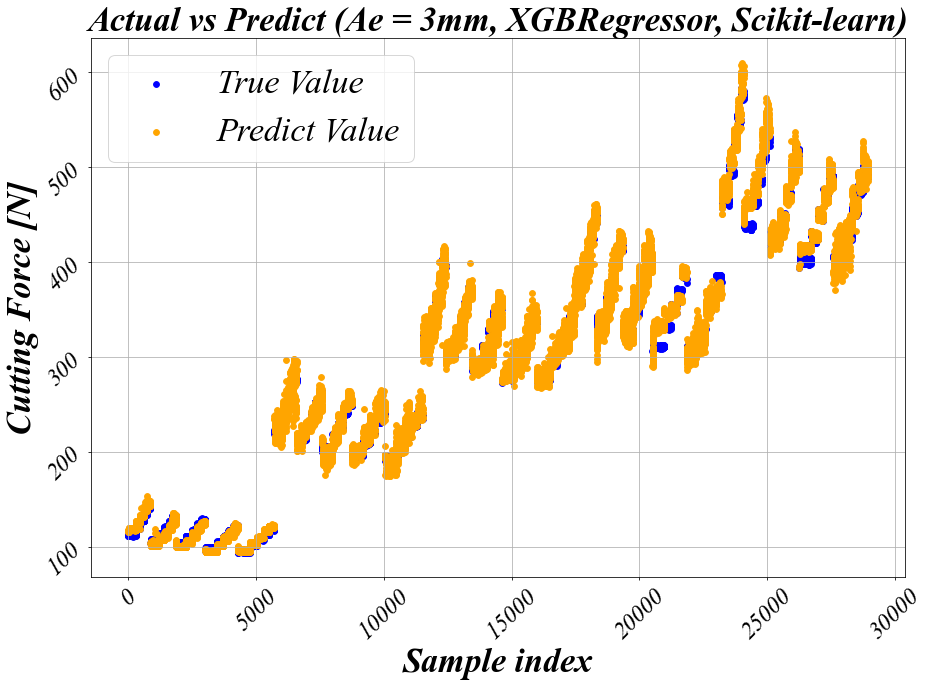

In [54]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 3mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ae3 cycle.png")

## Ae4

In [55]:
train = pd.concat([ae_1, ae_2, ae_3], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [56]:
X_test = ae_4.iloc[: , 1:]
y_test = ae_4['RMS_CF_max']

In [57]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [58]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:267.10272	validation_0-mape:0.98732	validation_1-rmse:338.62642	validation_1-mape:0.98833
[1]	validation_0-rmse:264.44392	validation_0-mape:0.97742	validation_1-rmse:335.43130	validation_1-mape:0.97883
[2]	validation_0-rmse:261.81181	validation_0-mape:0.96761	validation_1-rmse:332.26922	validation_1-mape:0.96943
[3]	validation_0-rmse:259.20600	validation_0-mape:0.95791	validation_1-rmse:329.13758	validation_1-mape:0.96012
[4]	validation_0-rmse:256.62644	validation_0-mape:0.94831	validation_1-rmse:326.03774	validation_1-mape:0.95090
[5]	validation_0-rmse:254.07378	validation_0-mape:0.93879	validation_1-rmse:322.92407	validation_1-mape:0.94169
[6]	validation_0-rmse:251.54574	validation_0-mape:0.92938	validation_1-rmse:319.88731	validation_1-mape:0.93265
[7]	validation_0-rmse:249.04400	validation_0-mape:0.92005	validation_1-rmse:316.83497	validation_1-mape:0.92362
[8]	validation_0-rmse:246.56552	validation_0-mape:0.91083	validation_1-rmse:313.82352	validation_1-mape:

[73]	validation_0-rmse:128.92984	validation_0-mape:0.47267	validation_1-rmse:170.42501	validation_1-mape:0.49032
[74]	validation_0-rmse:127.65202	validation_0-mape:0.46792	validation_1-rmse:168.88241	validation_1-mape:0.48568
[75]	validation_0-rmse:126.38792	validation_0-mape:0.46321	validation_1-rmse:167.31669	validation_1-mape:0.48107
[76]	validation_0-rmse:125.13557	validation_0-mape:0.45855	validation_1-rmse:165.80580	validation_1-mape:0.47652
[77]	validation_0-rmse:123.89725	validation_0-mape:0.45394	validation_1-rmse:164.25951	validation_1-mape:0.47200
[78]	validation_0-rmse:122.66980	validation_0-mape:0.44938	validation_1-rmse:162.78694	validation_1-mape:0.46757
[79]	validation_0-rmse:121.45539	validation_0-mape:0.44485	validation_1-rmse:161.32168	validation_1-mape:0.46314
[80]	validation_0-rmse:120.25387	validation_0-mape:0.44038	validation_1-rmse:159.79610	validation_1-mape:0.45869
[81]	validation_0-rmse:119.06221	validation_0-mape:0.43595	validation_1-rmse:158.36652	validatio

[146]	validation_0-rmse:62.51838	validation_0-mape:0.22577	validation_1-rmse:89.22623	validation_1-mape:0.24740
[147]	validation_0-rmse:61.90314	validation_0-mape:0.22350	validation_1-rmse:88.47324	validation_1-mape:0.24518
[148]	validation_0-rmse:61.29509	validation_0-mape:0.22125	validation_1-rmse:87.72952	validation_1-mape:0.24293
[149]	validation_0-rmse:60.69258	validation_0-mape:0.21902	validation_1-rmse:86.99387	validation_1-mape:0.24075
[150]	validation_0-rmse:60.09776	validation_0-mape:0.21681	validation_1-rmse:86.28037	validation_1-mape:0.23853
[151]	validation_0-rmse:59.50864	validation_0-mape:0.21462	validation_1-rmse:85.55262	validation_1-mape:0.23634
[152]	validation_0-rmse:58.92569	validation_0-mape:0.21245	validation_1-rmse:84.85092	validation_1-mape:0.23420
[153]	validation_0-rmse:58.34693	validation_0-mape:0.21032	validation_1-rmse:84.13819	validation_1-mape:0.23209
[154]	validation_0-rmse:57.77398	validation_0-mape:0.20820	validation_1-rmse:83.44274	validation_1-mape:

[220]	validation_0-rmse:30.33895	validation_0-mape:0.10660	validation_1-rmse:50.72187	validation_1-mape:0.13016
[221]	validation_0-rmse:30.04552	validation_0-mape:0.10553	validation_1-rmse:50.39026	validation_1-mape:0.12913
[222]	validation_0-rmse:29.75506	validation_0-mape:0.10447	validation_1-rmse:50.05894	validation_1-mape:0.12810
[223]	validation_0-rmse:29.46763	validation_0-mape:0.10342	validation_1-rmse:49.73723	validation_1-mape:0.12710
[224]	validation_0-rmse:29.18311	validation_0-mape:0.10239	validation_1-rmse:49.41500	validation_1-mape:0.12611
[225]	validation_0-rmse:28.90157	validation_0-mape:0.10136	validation_1-rmse:49.09284	validation_1-mape:0.12510
[226]	validation_0-rmse:28.62291	validation_0-mape:0.10034	validation_1-rmse:48.77984	validation_1-mape:0.12413
[227]	validation_0-rmse:28.34716	validation_0-mape:0.09933	validation_1-rmse:48.46638	validation_1-mape:0.12315
[228]	validation_0-rmse:28.07419	validation_0-mape:0.09833	validation_1-rmse:48.15788	validation_1-mape:

[294]	validation_0-rmse:15.07454	validation_0-mape:0.05054	validation_1-rmse:33.44316	validation_1-mape:0.07631
[295]	validation_0-rmse:14.93804	validation_0-mape:0.05004	validation_1-rmse:33.28914	validation_1-mape:0.07583
[296]	validation_0-rmse:14.80274	validation_0-mape:0.04954	validation_1-rmse:33.13945	validation_1-mape:0.07536
[297]	validation_0-rmse:14.66916	validation_0-mape:0.04905	validation_1-rmse:32.98898	validation_1-mape:0.07489
[298]	validation_0-rmse:14.53671	validation_0-mape:0.04856	validation_1-rmse:32.84227	validation_1-mape:0.07443
[299]	validation_0-rmse:14.40607	validation_0-mape:0.04807	validation_1-rmse:32.69161	validation_1-mape:0.07396
[300]	validation_0-rmse:14.27641	validation_0-mape:0.04759	validation_1-rmse:32.55428	validation_1-mape:0.07352
[301]	validation_0-rmse:14.14811	validation_0-mape:0.04712	validation_1-rmse:32.41696	validation_1-mape:0.07308
[302]	validation_0-rmse:14.02137	validation_0-mape:0.04665	validation_1-rmse:32.27064	validation_1-mape:

[368]	validation_0-rmse:8.10304	validation_0-mape:0.02470	validation_1-rmse:25.58221	validation_1-mape:0.05293
[369]	validation_0-rmse:8.04300	validation_0-mape:0.02448	validation_1-rmse:25.51238	validation_1-mape:0.05274
[370]	validation_0-rmse:7.98368	validation_0-mape:0.02426	validation_1-rmse:25.44191	validation_1-mape:0.05256
[371]	validation_0-rmse:7.92512	validation_0-mape:0.02405	validation_1-rmse:25.37043	validation_1-mape:0.05238
[372]	validation_0-rmse:7.86722	validation_0-mape:0.02384	validation_1-rmse:25.30311	validation_1-mape:0.05221
[373]	validation_0-rmse:7.81027	validation_0-mape:0.02363	validation_1-rmse:25.23368	validation_1-mape:0.05203
[374]	validation_0-rmse:7.75405	validation_0-mape:0.02342	validation_1-rmse:25.16499	validation_1-mape:0.05187
[375]	validation_0-rmse:7.69842	validation_0-mape:0.02321	validation_1-rmse:25.10184	validation_1-mape:0.05170
[376]	validation_0-rmse:7.64326	validation_0-mape:0.02301	validation_1-rmse:25.03710	validation_1-mape:0.05154
[

[442]	validation_0-rmse:5.19182	validation_0-mape:0.01408	validation_1-rmse:22.10314	validation_1-mape:0.04479
[443]	validation_0-rmse:5.16823	validation_0-mape:0.01400	validation_1-rmse:22.07141	validation_1-mape:0.04472
[444]	validation_0-rmse:5.14506	validation_0-mape:0.01392	validation_1-rmse:22.04034	validation_1-mape:0.04465
[445]	validation_0-rmse:5.12222	validation_0-mape:0.01384	validation_1-rmse:22.00963	validation_1-mape:0.04459
[446]	validation_0-rmse:5.09993	validation_0-mape:0.01376	validation_1-rmse:21.97854	validation_1-mape:0.04452
[447]	validation_0-rmse:5.07780	validation_0-mape:0.01368	validation_1-rmse:21.95031	validation_1-mape:0.04446
[448]	validation_0-rmse:5.05662	validation_0-mape:0.01361	validation_1-rmse:21.92155	validation_1-mape:0.04440
[449]	validation_0-rmse:5.03497	validation_0-mape:0.01353	validation_1-rmse:21.89309	validation_1-mape:0.04435
[450]	validation_0-rmse:5.01349	validation_0-mape:0.01346	validation_1-rmse:21.86536	validation_1-mape:0.04429
[

[516]	validation_0-rmse:4.07963	validation_0-mape:0.01037	validation_1-rmse:20.52742	validation_1-mape:0.04178
[517]	validation_0-rmse:4.07105	validation_0-mape:0.01034	validation_1-rmse:20.51267	validation_1-mape:0.04175
[518]	validation_0-rmse:4.06110	validation_0-mape:0.01032	validation_1-rmse:20.50074	validation_1-mape:0.04173
[519]	validation_0-rmse:4.05284	validation_0-mape:0.01029	validation_1-rmse:20.48552	validation_1-mape:0.04170
[520]	validation_0-rmse:4.04332	validation_0-mape:0.01026	validation_1-rmse:20.47357	validation_1-mape:0.04168
[521]	validation_0-rmse:4.03375	validation_0-mape:0.01024	validation_1-rmse:20.46220	validation_1-mape:0.04166
[522]	validation_0-rmse:4.02517	validation_0-mape:0.01021	validation_1-rmse:20.44631	validation_1-mape:0.04163
[523]	validation_0-rmse:4.01604	validation_0-mape:0.01019	validation_1-rmse:20.43485	validation_1-mape:0.04161
[524]	validation_0-rmse:4.00783	validation_0-mape:0.01016	validation_1-rmse:20.41954	validation_1-mape:0.04159
[

[590]	validation_0-rmse:3.62237	validation_0-mape:0.00916	validation_1-rmse:19.76601	validation_1-mape:0.04056
[591]	validation_0-rmse:3.61865	validation_0-mape:0.00915	validation_1-rmse:19.75835	validation_1-mape:0.04054
[592]	validation_0-rmse:3.61486	validation_0-mape:0.00914	validation_1-rmse:19.75123	validation_1-mape:0.04053
[593]	validation_0-rmse:3.61023	validation_0-mape:0.00913	validation_1-rmse:19.74536	validation_1-mape:0.04052
[594]	validation_0-rmse:3.60653	validation_0-mape:0.00912	validation_1-rmse:19.73812	validation_1-mape:0.04051
[595]	validation_0-rmse:3.60275	validation_0-mape:0.00911	validation_1-rmse:19.73139	validation_1-mape:0.04050
[596]	validation_0-rmse:3.59852	validation_0-mape:0.00911	validation_1-rmse:19.72446	validation_1-mape:0.04048
[597]	validation_0-rmse:3.59446	validation_0-mape:0.00910	validation_1-rmse:19.71873	validation_1-mape:0.04048
[598]	validation_0-rmse:3.59010	validation_0-mape:0.00909	validation_1-rmse:19.71294	validation_1-mape:0.04047
[

[664]	validation_0-rmse:3.38700	validation_0-mape:0.00868	validation_1-rmse:19.38361	validation_1-mape:0.03996
[665]	validation_0-rmse:3.38395	validation_0-mape:0.00868	validation_1-rmse:19.38082	validation_1-mape:0.03995
[666]	validation_0-rmse:3.38177	validation_0-mape:0.00867	validation_1-rmse:19.37916	validation_1-mape:0.03995
[667]	validation_0-rmse:3.37904	validation_0-mape:0.00867	validation_1-rmse:19.37617	validation_1-mape:0.03995
[668]	validation_0-rmse:3.37669	validation_0-mape:0.00866	validation_1-rmse:19.36650	validation_1-mape:0.03993
[669]	validation_0-rmse:3.37422	validation_0-mape:0.00866	validation_1-rmse:19.36334	validation_1-mape:0.03993
[670]	validation_0-rmse:3.37174	validation_0-mape:0.00865	validation_1-rmse:19.35394	validation_1-mape:0.03991
[671]	validation_0-rmse:3.36900	validation_0-mape:0.00865	validation_1-rmse:19.35118	validation_1-mape:0.03991
[672]	validation_0-rmse:3.36670	validation_0-mape:0.00864	validation_1-rmse:19.34855	validation_1-mape:0.03991
[

[738]	validation_0-rmse:3.22369	validation_0-mape:0.00838	validation_1-rmse:19.18227	validation_1-mape:0.03976
[739]	validation_0-rmse:3.22202	validation_0-mape:0.00838	validation_1-rmse:19.18051	validation_1-mape:0.03975
[740]	validation_0-rmse:3.21993	validation_0-mape:0.00838	validation_1-rmse:19.17759	validation_1-mape:0.03975
[741]	validation_0-rmse:3.21814	validation_0-mape:0.00838	validation_1-rmse:19.17675	validation_1-mape:0.03975
[742]	validation_0-rmse:3.21638	validation_0-mape:0.00837	validation_1-rmse:19.17561	validation_1-mape:0.03975
[743]	validation_0-rmse:3.21454	validation_0-mape:0.00837	validation_1-rmse:19.17499	validation_1-mape:0.03975
[744]	validation_0-rmse:3.21217	validation_0-mape:0.00836	validation_1-rmse:19.16508	validation_1-mape:0.03973
[745]	validation_0-rmse:3.20948	validation_0-mape:0.00836	validation_1-rmse:19.15975	validation_1-mape:0.03973
[746]	validation_0-rmse:3.20817	validation_0-mape:0.00836	validation_1-rmse:19.15819	validation_1-mape:0.03972
[

[812]	validation_0-rmse:3.09462	validation_0-mape:0.00815	validation_1-rmse:19.01871	validation_1-mape:0.03960
[813]	validation_0-rmse:3.09311	validation_0-mape:0.00815	validation_1-rmse:19.01625	validation_1-mape:0.03960
[814]	validation_0-rmse:3.09159	validation_0-mape:0.00815	validation_1-rmse:19.01639	validation_1-mape:0.03960
[815]	validation_0-rmse:3.09017	validation_0-mape:0.00814	validation_1-rmse:19.01460	validation_1-mape:0.03960
[816]	validation_0-rmse:3.08907	validation_0-mape:0.00814	validation_1-rmse:19.01257	validation_1-mape:0.03959
[817]	validation_0-rmse:3.08752	validation_0-mape:0.00814	validation_1-rmse:19.01125	validation_1-mape:0.03959
[818]	validation_0-rmse:3.08529	validation_0-mape:0.00814	validation_1-rmse:19.01059	validation_1-mape:0.03959
[819]	validation_0-rmse:3.08382	validation_0-mape:0.00813	validation_1-rmse:19.00934	validation_1-mape:0.03959
[820]	validation_0-rmse:3.08231	validation_0-mape:0.00813	validation_1-rmse:19.00972	validation_1-mape:0.03959
[

[886]	validation_0-rmse:2.98106	validation_0-mape:0.00793	validation_1-rmse:18.96329	validation_1-mape:0.03963
[887]	validation_0-rmse:2.97990	validation_0-mape:0.00793	validation_1-rmse:18.96313	validation_1-mape:0.03963
[888]	validation_0-rmse:2.97754	validation_0-mape:0.00792	validation_1-rmse:18.96310	validation_1-mape:0.03963
[889]	validation_0-rmse:2.97625	validation_0-mape:0.00792	validation_1-rmse:18.96266	validation_1-mape:0.03963
[890]	validation_0-rmse:2.97489	validation_0-mape:0.00792	validation_1-rmse:18.96291	validation_1-mape:0.03963
[891]	validation_0-rmse:2.97330	validation_0-mape:0.00791	validation_1-rmse:18.96156	validation_1-mape:0.03963
[892]	validation_0-rmse:2.97177	validation_0-mape:0.00791	validation_1-rmse:18.96267	validation_1-mape:0.03963
[893]	validation_0-rmse:2.96972	validation_0-mape:0.00791	validation_1-rmse:18.96265	validation_1-mape:0.03964
[894]	validation_0-rmse:2.96841	validation_0-mape:0.00790	validation_1-rmse:18.96207	validation_1-mape:0.03963
[

[960]	validation_0-rmse:2.87334	validation_0-mape:0.00771	validation_1-rmse:18.92905	validation_1-mape:0.03966
[961]	validation_0-rmse:2.87197	validation_0-mape:0.00771	validation_1-rmse:18.92798	validation_1-mape:0.03965
[962]	validation_0-rmse:2.87024	validation_0-mape:0.00771	validation_1-rmse:18.92782	validation_1-mape:0.03966
[963]	validation_0-rmse:2.86872	validation_0-mape:0.00770	validation_1-rmse:18.92594	validation_1-mape:0.03965
[964]	validation_0-rmse:2.86775	validation_0-mape:0.00770	validation_1-rmse:18.92605	validation_1-mape:0.03965
[965]	validation_0-rmse:2.86680	validation_0-mape:0.00770	validation_1-rmse:18.92467	validation_1-mape:0.03965
[966]	validation_0-rmse:2.86538	validation_0-mape:0.00770	validation_1-rmse:18.92495	validation_1-mape:0.03965
[967]	validation_0-rmse:2.86367	validation_0-mape:0.00769	validation_1-rmse:18.92362	validation_1-mape:0.03964
[968]	validation_0-rmse:2.86229	validation_0-mape:0.00769	validation_1-rmse:18.92116	validation_1-mape:0.03964
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [59]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 2.8222
Train MAPE: 0.7609
Test RMSE: 18.9077
Test MAPE: 3.9647


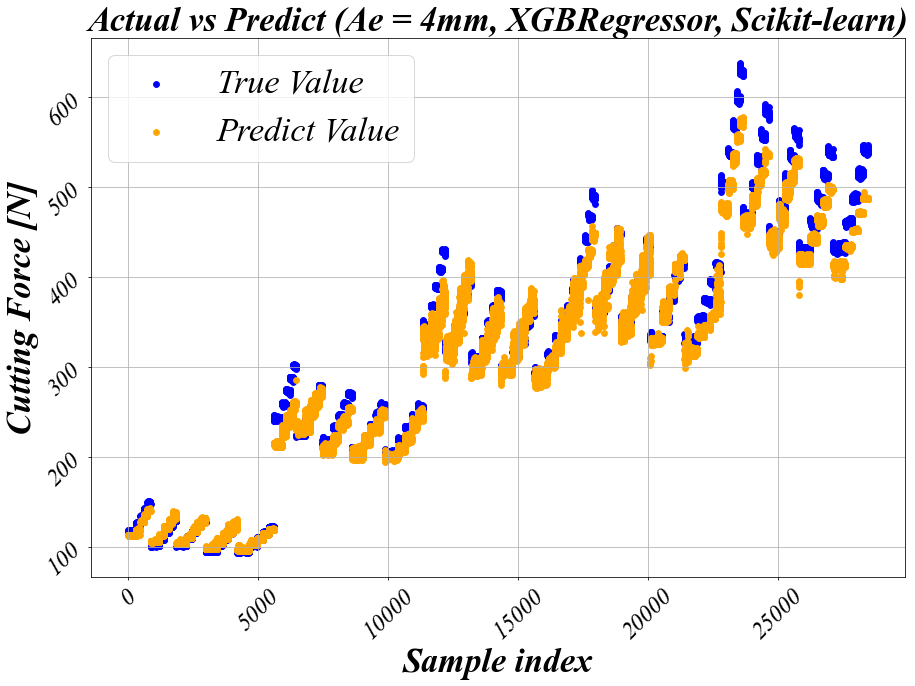

In [62]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 4mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ae4 cycle.png")

# Ap

In [61]:
ap_100 = groups_ap.get_group(1)
ap_100 = ap_100.reset_index(drop=True)
ap_100 = ap_100.drop(['Milling_Type'], axis=1)

ap_225 = groups_ap.get_group(2.25)
ap_225 = ap_225.reset_index(drop=True)
ap_225 = ap_225.drop(['Milling_Type'], axis=1)

ap_350 = groups_ap.get_group(3.5)
ap_350 = ap_350.reset_index(drop=True)
ap_350 = ap_350.drop(['Milling_Type'], axis=1)

ap_475 = groups_ap.get_group(4.75)
ap_475 = ap_475.reset_index(drop=True)
ap_475 = ap_475.drop(['Milling_Type'], axis=1)

ap_600 = groups_ap.get_group(6)
ap_600 = ap_600.reset_index(drop=True)
ap_600 = ap_600.drop(['Milling_Type'], axis=1)

## Ap 100

In [63]:
train = pd.concat([ap_225, ap_350, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [64]:
X_test = ap_100.iloc[: , 1:]
y_test = ap_100['RMS_CF_max']

In [65]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [81]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 80,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:315.86156	validation_0-mape:0.98812	validation_1-rmse:97.91337	validation_1-mape:0.97492
[1]	validation_0-rmse:312.71926	validation_0-mape:0.97819	validation_1-rmse:96.00209	validation_1-mape:0.95535
[2]	validation_0-rmse:309.60846	validation_0-mape:0.96836	validation_1-rmse:94.11035	validation_1-mape:0.93599
[3]	validation_0-rmse:306.52881	validation_0-mape:0.95863	validation_1-rmse:92.23609	validation_1-mape:0.91679
[4]	validation_0-rmse:303.48002	validation_0-mape:0.94900	validation_1-rmse:90.38101	validation_1-mape:0.89780
[5]	validation_0-rmse:300.46145	validation_0-mape:0.93946	validation_1-rmse:88.54691	validation_1-mape:0.87900
[6]	validation_0-rmse:297.47532	validation_0-mape:0.93001	validation_1-rmse:86.75453	validation_1-mape:0.86054
[7]	validation_0-rmse:294.51691	validation_0-mape:0.92066	validation_1-rmse:84.95599	validation_1-mape:0.84210
[8]	validation_0-rmse:291.58751	validation_0-mape:0.91141	validation_1-rmse:83.22769	validation_1-mape:0.82422
[

[74]	validation_0-rmse:150.95591	validation_0-mape:0.46755	validation_1-rmse:10.92934	validation_1-mape:0.09455
[75]	validation_0-rmse:149.46087	validation_0-mape:0.46284	validation_1-rmse:10.98181	validation_1-mape:0.09740
[76]	validation_0-rmse:147.97996	validation_0-mape:0.45818	validation_1-rmse:11.11242	validation_1-mape:0.10077
[77]	validation_0-rmse:146.51427	validation_0-mape:0.45357	validation_1-rmse:11.27355	validation_1-mape:0.10416
[78]	validation_0-rmse:145.06361	validation_0-mape:0.44900	validation_1-rmse:11.52053	validation_1-mape:0.10809
[79]	validation_0-rmse:143.62614	validation_0-mape:0.44448	validation_1-rmse:11.81928	validation_1-mape:0.11249


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=80, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

In [82]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 143.6261
Train MAPE: 44.4480
Test RMSE: 11.8193
Test MAPE: 11.2488


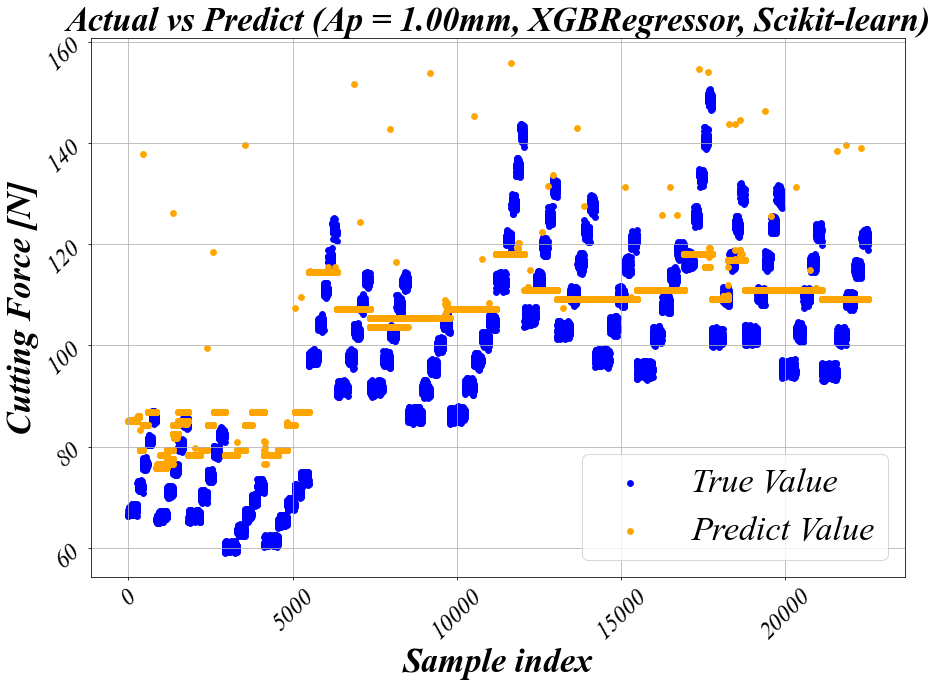

In [83]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 1.00mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ap1 cycle .png")

## Ap 225

In [84]:
train = pd.concat([ap_100, ap_350, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [85]:
X_test = ap_225.iloc[: , 1:]
y_test = ap_225['RMS_CF_max']

In [86]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [87]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 180,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:304.26100	validation_0-mape:0.98747	validation_1-rmse:200.91123	validation_1-mape:0.98367
[1]	validation_0-rmse:301.23381	validation_0-mape:0.97756	validation_1-rmse:198.17973	validation_1-mape:0.97010
[2]	validation_0-rmse:298.23698	validation_0-mape:0.96774	validation_1-rmse:195.47727	validation_1-mape:0.95667
[3]	validation_0-rmse:295.27031	validation_0-mape:0.95802	validation_1-rmse:192.79963	validation_1-mape:0.94337
[4]	validation_0-rmse:292.33331	validation_0-mape:0.94840	validation_1-rmse:190.15409	validation_1-mape:0.93022
[5]	validation_0-rmse:289.42580	validation_0-mape:0.93888	validation_1-rmse:187.55560	validation_1-mape:0.91728
[6]	validation_0-rmse:286.54759	validation_0-mape:0.92945	validation_1-rmse:184.98373	validation_1-mape:0.90449
[7]	validation_0-rmse:283.69817	validation_0-mape:0.92011	validation_1-rmse:182.41620	validation_1-mape:0.89172
[8]	validation_0-rmse:280.87732	validation_0-mape:0.91087	validation_1-rmse:179.89896	validation_1-mape:

[73]	validation_0-rmse:146.95688	validation_0-mape:0.47244	validation_1-rmse:62.42784	validation_1-mape:0.28951
[74]	validation_0-rmse:145.50422	validation_0-mape:0.46769	validation_1-rmse:61.15264	validation_1-mape:0.28294
[75]	validation_0-rmse:144.06514	validation_0-mape:0.46298	validation_1-rmse:59.93415	validation_1-mape:0.27676
[76]	validation_0-rmse:142.64161	validation_0-mape:0.45833	validation_1-rmse:58.68886	validation_1-mape:0.27033
[77]	validation_0-rmse:141.23175	validation_0-mape:0.45372	validation_1-rmse:57.57471	validation_1-mape:0.26460
[78]	validation_0-rmse:139.83633	validation_0-mape:0.44916	validation_1-rmse:56.43872	validation_1-mape:0.25860
[79]	validation_0-rmse:138.45519	validation_0-mape:0.44464	validation_1-rmse:55.24369	validation_1-mape:0.25244
[80]	validation_0-rmse:137.08714	validation_0-mape:0.44017	validation_1-rmse:54.12947	validation_1-mape:0.24677
[81]	validation_0-rmse:135.73299	validation_0-mape:0.43574	validation_1-rmse:52.97493	validation_1-mape:

[147]	validation_0-rmse:70.66297	validation_0-mape:0.22334	validation_1-rmse:16.10868	validation_1-mape:0.06478
[148]	validation_0-rmse:69.97047	validation_0-mape:0.22109	validation_1-rmse:16.31046	validation_1-mape:0.06646
[149]	validation_0-rmse:69.28560	validation_0-mape:0.21886	validation_1-rmse:16.53401	validation_1-mape:0.06820
[150]	validation_0-rmse:68.60767	validation_0-mape:0.21665	validation_1-rmse:16.75380	validation_1-mape:0.06988
[151]	validation_0-rmse:67.93624	validation_0-mape:0.21446	validation_1-rmse:17.00649	validation_1-mape:0.07167
[152]	validation_0-rmse:67.27203	validation_0-mape:0.21230	validation_1-rmse:17.25623	validation_1-mape:0.07340
[153]	validation_0-rmse:66.61327	validation_0-mape:0.21016	validation_1-rmse:17.52623	validation_1-mape:0.07522
[154]	validation_0-rmse:65.96224	validation_0-mape:0.20804	validation_1-rmse:17.79437	validation_1-mape:0.07698
[155]	validation_0-rmse:65.31760	validation_0-mape:0.20594	validation_1-rmse:18.08666	validation_1-mape:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=180, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [88]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 51.6436
Train MAPE: 16.1447
Test RMSE: 26.0596
Test MAPE: 12.4117


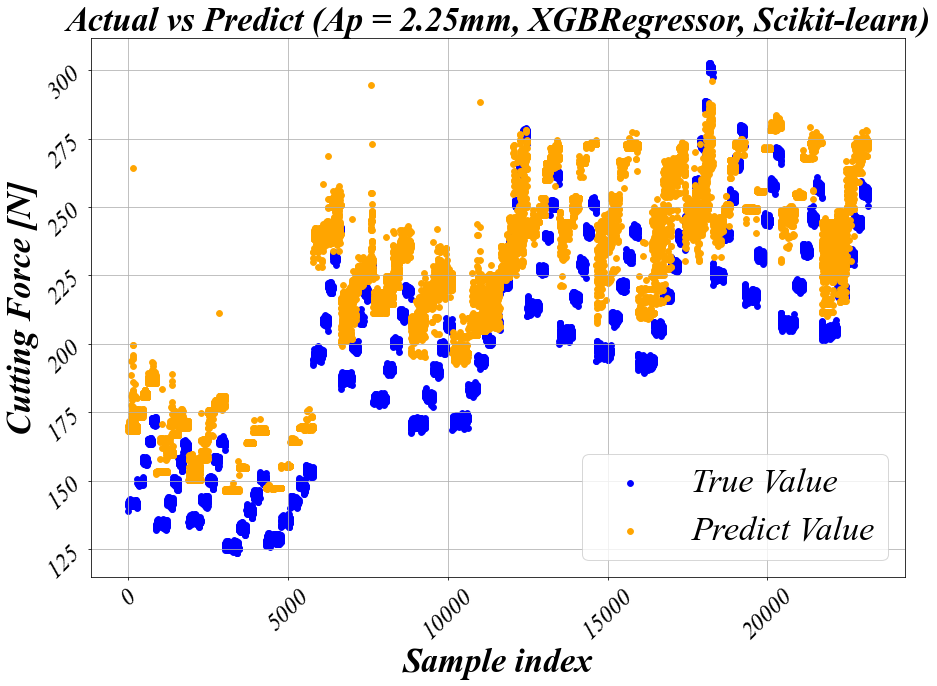

In [89]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 2.25mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ap2.25 cycle.png")

## Ap 350

In [90]:
train = pd.concat([ap_100, ap_225, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [91]:
X_test = ap_350.iloc[: , 1:]
y_test = ap_350['RMS_CF_max']

In [92]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [96]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 300,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:286.52307	validation_0-mape:0.98729	validation_1-rmse:286.11290	validation_1-mape:0.98713
[1]	validation_0-rmse:283.66912	validation_0-mape:0.97740	validation_1-rmse:282.98628	validation_1-mape:0.97623
[2]	validation_0-rmse:280.84379	validation_0-mape:0.96760	validation_1-rmse:279.88959	validation_1-mape:0.96543
[3]	validation_0-rmse:278.04699	validation_0-mape:0.95790	validation_1-rmse:276.82575	validation_1-mape:0.95475
[4]	validation_0-rmse:275.27836	validation_0-mape:0.94830	validation_1-rmse:273.79641	validation_1-mape:0.94419
[5]	validation_0-rmse:272.53736	validation_0-mape:0.93880	validation_1-rmse:270.79175	validation_1-mape:0.93371
[6]	validation_0-rmse:269.82398	validation_0-mape:0.92939	validation_1-rmse:267.81769	validation_1-mape:0.92329
[7]	validation_0-rmse:267.13769	validation_0-mape:0.92007	validation_1-rmse:264.86828	validation_1-mape:0.91301
[8]	validation_0-rmse:264.47845	validation_0-mape:0.91084	validation_1-rmse:261.95275	validation_1-mape:

[73]	validation_0-rmse:138.23103	validation_0-mape:0.47282	validation_1-rmse:126.33252	validation_1-mape:0.42537
[74]	validation_0-rmse:136.86073	validation_0-mape:0.46807	validation_1-rmse:124.87619	validation_1-mape:0.42022
[75]	validation_0-rmse:135.50481	validation_0-mape:0.46336	validation_1-rmse:123.49691	validation_1-mape:0.41530
[76]	validation_0-rmse:134.16164	validation_0-mape:0.45871	validation_1-rmse:122.07022	validation_1-mape:0.41028
[77]	validation_0-rmse:132.83161	validation_0-mape:0.45410	validation_1-rmse:120.64173	validation_1-mape:0.40527
[78]	validation_0-rmse:131.51557	validation_0-mape:0.44954	validation_1-rmse:119.23694	validation_1-mape:0.40032
[79]	validation_0-rmse:130.21141	validation_0-mape:0.44502	validation_1-rmse:117.81854	validation_1-mape:0.39538
[80]	validation_0-rmse:128.92141	validation_0-mape:0.44055	validation_1-rmse:116.46228	validation_1-mape:0.39063
[81]	validation_0-rmse:127.64464	validation_0-mape:0.43612	validation_1-rmse:115.15871	validatio

[146]	validation_0-rmse:66.94336	validation_0-mape:0.22613	validation_1-rmse:50.54727	validation_1-mape:0.15862
[147]	validation_0-rmse:66.28249	validation_0-mape:0.22386	validation_1-rmse:49.86269	validation_1-mape:0.15621
[148]	validation_0-rmse:65.62831	validation_0-mape:0.22160	validation_1-rmse:49.17849	validation_1-mape:0.15380
[149]	validation_0-rmse:64.98257	validation_0-mape:0.21937	validation_1-rmse:48.54165	validation_1-mape:0.15150
[150]	validation_0-rmse:64.34337	validation_0-mape:0.21717	validation_1-rmse:47.88490	validation_1-mape:0.14910
[151]	validation_0-rmse:63.70979	validation_0-mape:0.21498	validation_1-rmse:47.32074	validation_1-mape:0.14706
[152]	validation_0-rmse:63.08220	validation_0-mape:0.21282	validation_1-rmse:46.76155	validation_1-mape:0.14504
[153]	validation_0-rmse:62.46100	validation_0-mape:0.21067	validation_1-rmse:46.20506	validation_1-mape:0.14300
[154]	validation_0-rmse:61.84612	validation_0-mape:0.20855	validation_1-rmse:45.65747	validation_1-mape:

[220]	validation_0-rmse:32.32196	validation_0-mape:0.10697	validation_1-rmse:18.25139	validation_1-mape:0.04157
[221]	validation_0-rmse:32.00834	validation_0-mape:0.10589	validation_1-rmse:17.98555	validation_1-mape:0.04071
[222]	validation_0-rmse:31.69790	validation_0-mape:0.10483	validation_1-rmse:17.72548	validation_1-mape:0.03987
[223]	validation_0-rmse:31.39071	validation_0-mape:0.10377	validation_1-rmse:17.46853	validation_1-mape:0.03906
[224]	validation_0-rmse:31.08628	validation_0-mape:0.10273	validation_1-rmse:17.20885	validation_1-mape:0.03824
[225]	validation_0-rmse:30.78525	validation_0-mape:0.10169	validation_1-rmse:16.96800	validation_1-mape:0.03751
[226]	validation_0-rmse:30.48794	validation_0-mape:0.10067	validation_1-rmse:16.77986	validation_1-mape:0.03693
[227]	validation_0-rmse:30.19280	validation_0-mape:0.09966	validation_1-rmse:16.54098	validation_1-mape:0.03626
[228]	validation_0-rmse:29.90081	validation_0-mape:0.09865	validation_1-rmse:16.31568	validation_1-mape:

[294]	validation_0-rmse:15.99686	validation_0-mape:0.05062	validation_1-rmse:12.24082	validation_1-mape:0.03646
[295]	validation_0-rmse:15.85117	validation_0-mape:0.05011	validation_1-rmse:12.27222	validation_1-mape:0.03668
[296]	validation_0-rmse:15.70655	validation_0-mape:0.04962	validation_1-rmse:12.30406	validation_1-mape:0.03689
[297]	validation_0-rmse:15.56452	validation_0-mape:0.04912	validation_1-rmse:12.34284	validation_1-mape:0.03713
[298]	validation_0-rmse:15.42273	validation_0-mape:0.04863	validation_1-rmse:12.37550	validation_1-mape:0.03734
[299]	validation_0-rmse:15.28296	validation_0-mape:0.04815	validation_1-rmse:12.41079	validation_1-mape:0.03756


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [97]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 15.2830
Train MAPE: 4.8147
Test RMSE: 12.4108
Test MAPE: 3.7556


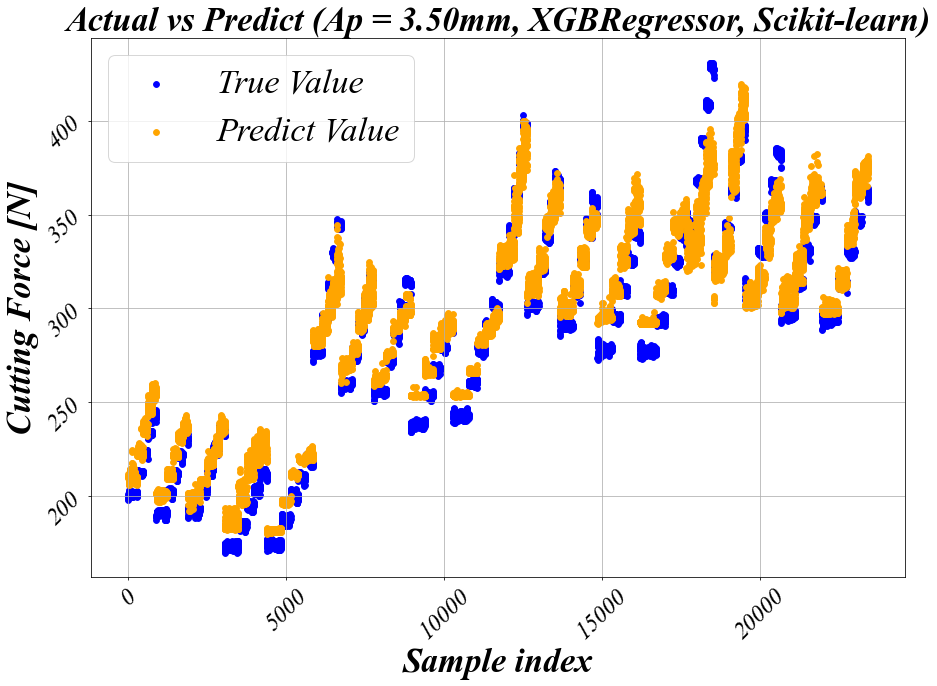

In [99]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 3.50mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ap3.5 cycle.png")

## Ap 475

In [100]:
train = pd.concat([ap_100, ap_225, ap_350, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [101]:
X_test = ap_475.iloc[: , 1:]
y_test = ap_475['RMS_CF_max']

In [102]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [107]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:276.90153	validation_0-mape:0.98724	validation_1-rmse:322.05363	validation_1-mape:0.98747
[1]	validation_0-rmse:274.14727	validation_0-mape:0.97733	validation_1-rmse:318.57233	validation_1-mape:0.97670
[2]	validation_0-rmse:271.42109	validation_0-mape:0.96751	validation_1-rmse:315.12928	validation_1-mape:0.96592
[3]	validation_0-rmse:268.72227	validation_0-mape:0.95780	validation_1-rmse:311.67480	validation_1-mape:0.95509
[4]	validation_0-rmse:266.05055	validation_0-mape:0.94818	validation_1-rmse:308.30175	validation_1-mape:0.94451
[5]	validation_0-rmse:263.40565	validation_0-mape:0.93866	validation_1-rmse:305.08774	validation_1-mape:0.93442
[6]	validation_0-rmse:260.78680	validation_0-mape:0.92923	validation_1-rmse:301.77588	validation_1-mape:0.92415
[7]	validation_0-rmse:258.19592	validation_0-mape:0.91989	validation_1-rmse:298.60802	validation_1-mape:0.91418
[8]	validation_0-rmse:255.63031	validation_0-mape:0.91065	validation_1-rmse:295.50410	validation_1-mape:

[73]	validation_0-rmse:133.73135	validation_0-mape:0.47212	validation_1-rmse:148.15547	validation_1-mape:0.43865
[74]	validation_0-rmse:132.40922	validation_0-mape:0.46737	validation_1-rmse:146.62363	validation_1-mape:0.43373
[75]	validation_0-rmse:131.09810	validation_0-mape:0.46267	validation_1-rmse:144.94144	validation_1-mape:0.42842
[76]	validation_0-rmse:129.80048	validation_0-mape:0.45802	validation_1-rmse:143.32849	validation_1-mape:0.42331
[77]	validation_0-rmse:128.51634	validation_0-mape:0.45340	validation_1-rmse:141.86732	validation_1-mape:0.41864
[78]	validation_0-rmse:127.24560	validation_0-mape:0.44884	validation_1-rmse:140.39992	validation_1-mape:0.41387
[79]	validation_0-rmse:125.98617	validation_0-mape:0.44432	validation_1-rmse:138.73899	validation_1-mape:0.40853
[80]	validation_0-rmse:124.74132	validation_0-mape:0.43984	validation_1-rmse:137.32963	validation_1-mape:0.40394
[81]	validation_0-rmse:123.50857	validation_0-mape:0.43541	validation_1-rmse:135.87528	validatio

[146]	validation_0-rmse:64.90575	validation_0-mape:0.22542	validation_1-rmse:68.33682	validation_1-mape:0.17505
[147]	validation_0-rmse:64.26825	validation_0-mape:0.22315	validation_1-rmse:67.67696	validation_1-mape:0.17291
[148]	validation_0-rmse:63.63757	validation_0-mape:0.22090	validation_1-rmse:67.04520	validation_1-mape:0.17081
[149]	validation_0-rmse:63.01492	validation_0-mape:0.21867	validation_1-rmse:66.38914	validation_1-mape:0.16863
[150]	validation_0-rmse:62.39793	validation_0-mape:0.21647	validation_1-rmse:65.76123	validation_1-mape:0.16654
[151]	validation_0-rmse:61.78662	validation_0-mape:0.21429	validation_1-rmse:65.11688	validation_1-mape:0.16442
[152]	validation_0-rmse:61.18169	validation_0-mape:0.21212	validation_1-rmse:64.50499	validation_1-mape:0.16238
[153]	validation_0-rmse:60.58306	validation_0-mape:0.20999	validation_1-rmse:63.88643	validation_1-mape:0.16042
[154]	validation_0-rmse:59.99035	validation_0-mape:0.20787	validation_1-rmse:63.29436	validation_1-mape:

[220]	validation_0-rmse:31.56243	validation_0-mape:0.10659	validation_1-rmse:39.47859	validation_1-mape:0.09683
[221]	validation_0-rmse:31.26098	validation_0-mape:0.10552	validation_1-rmse:39.30102	validation_1-mape:0.09643
[222]	validation_0-rmse:30.96271	validation_0-mape:0.10446	validation_1-rmse:39.12857	validation_1-mape:0.09605
[223]	validation_0-rmse:30.66759	validation_0-mape:0.10341	validation_1-rmse:38.96046	validation_1-mape:0.09568
[224]	validation_0-rmse:30.37549	validation_0-mape:0.10237	validation_1-rmse:38.79498	validation_1-mape:0.09530
[225]	validation_0-rmse:30.08704	validation_0-mape:0.10134	validation_1-rmse:38.64204	validation_1-mape:0.09495
[226]	validation_0-rmse:29.80077	validation_0-mape:0.10032	validation_1-rmse:38.48360	validation_1-mape:0.09460
[227]	validation_0-rmse:29.51769	validation_0-mape:0.09932	validation_1-rmse:38.33086	validation_1-mape:0.09425
[228]	validation_0-rmse:29.23737	validation_0-mape:0.09832	validation_1-rmse:38.17905	validation_1-mape:

[294]	validation_0-rmse:15.93581	validation_0-mape:0.05085	validation_1-rmse:33.75388	validation_1-mape:0.08247
[295]	validation_0-rmse:15.79763	validation_0-mape:0.05035	validation_1-rmse:33.75778	validation_1-mape:0.08248
[296]	validation_0-rmse:15.66110	validation_0-mape:0.04987	validation_1-rmse:33.75674	validation_1-mape:0.08248
[297]	validation_0-rmse:15.52561	validation_0-mape:0.04938	validation_1-rmse:33.75608	validation_1-mape:0.08247
[298]	validation_0-rmse:15.39196	validation_0-mape:0.04891	validation_1-rmse:33.75497	validation_1-mape:0.08247
[299]	validation_0-rmse:15.25877	validation_0-mape:0.04843	validation_1-rmse:33.74324	validation_1-mape:0.08244
[300]	validation_0-rmse:15.12697	validation_0-mape:0.04796	validation_1-rmse:33.73337	validation_1-mape:0.08241
[301]	validation_0-rmse:14.99656	validation_0-mape:0.04750	validation_1-rmse:33.72480	validation_1-mape:0.08239
[302]	validation_0-rmse:14.86769	validation_0-mape:0.04704	validation_1-rmse:33.71825	validation_1-mape:

[368]	validation_0-rmse:8.94882	validation_0-mape:0.02613	validation_1-rmse:35.14034	validation_1-mape:0.08626
[369]	validation_0-rmse:8.88951	validation_0-mape:0.02593	validation_1-rmse:35.16847	validation_1-mape:0.08633
[370]	validation_0-rmse:8.83162	validation_0-mape:0.02573	validation_1-rmse:35.19610	validation_1-mape:0.08641
[371]	validation_0-rmse:8.77398	validation_0-mape:0.02553	validation_1-rmse:35.22324	validation_1-mape:0.08649
[372]	validation_0-rmse:8.71706	validation_0-mape:0.02534	validation_1-rmse:35.24319	validation_1-mape:0.08655
[373]	validation_0-rmse:8.66130	validation_0-mape:0.02514	validation_1-rmse:35.27904	validation_1-mape:0.08666
[374]	validation_0-rmse:8.60405	validation_0-mape:0.02495	validation_1-rmse:35.30435	validation_1-mape:0.08673
[375]	validation_0-rmse:8.54754	validation_0-mape:0.02476	validation_1-rmse:35.33185	validation_1-mape:0.08681
[376]	validation_0-rmse:8.49196	validation_0-mape:0.02457	validation_1-rmse:35.35944	validation_1-mape:0.08690
[

[442]	validation_0-rmse:6.06842	validation_0-mape:0.01654	validation_1-rmse:36.96770	validation_1-mape:0.09245
[443]	validation_0-rmse:6.04530	validation_0-mape:0.01646	validation_1-rmse:36.99725	validation_1-mape:0.09257
[444]	validation_0-rmse:6.02352	validation_0-mape:0.01640	validation_1-rmse:37.01205	validation_1-mape:0.09261
[445]	validation_0-rmse:6.00193	validation_0-mape:0.01633	validation_1-rmse:37.03106	validation_1-mape:0.09271
[446]	validation_0-rmse:5.98041	validation_0-mape:0.01626	validation_1-rmse:37.04550	validation_1-mape:0.09275
[447]	validation_0-rmse:5.95864	validation_0-mape:0.01619	validation_1-rmse:37.07424	validation_1-mape:0.09286
[448]	validation_0-rmse:5.93704	validation_0-mape:0.01613	validation_1-rmse:37.10256	validation_1-mape:0.09297
[449]	validation_0-rmse:5.91587	validation_0-mape:0.01606	validation_1-rmse:37.11556	validation_1-mape:0.09301
[450]	validation_0-rmse:5.89482	validation_0-mape:0.01599	validation_1-rmse:37.14390	validation_1-mape:0.09311
[

[516]	validation_0-rmse:4.96203	validation_0-mape:0.01330	validation_1-rmse:38.84676	validation_1-mape:0.10006
[517]	validation_0-rmse:4.95237	validation_0-mape:0.01328	validation_1-rmse:38.88331	validation_1-mape:0.10021
[518]	validation_0-rmse:4.94379	validation_0-mape:0.01325	validation_1-rmse:38.88909	validation_1-mape:0.10022
[519]	validation_0-rmse:4.93428	validation_0-mape:0.01323	validation_1-rmse:38.90325	validation_1-mape:0.10028
[520]	validation_0-rmse:4.92578	validation_0-mape:0.01321	validation_1-rmse:38.91853	validation_1-mape:0.10034
[521]	validation_0-rmse:4.91688	validation_0-mape:0.01318	validation_1-rmse:38.94629	validation_1-mape:0.10044
[522]	validation_0-rmse:4.90872	validation_0-mape:0.01316	validation_1-rmse:38.95275	validation_1-mape:0.10046
[523]	validation_0-rmse:4.90061	validation_0-mape:0.01314	validation_1-rmse:38.96177	validation_1-mape:0.10049
[524]	validation_0-rmse:4.89146	validation_0-mape:0.01312	validation_1-rmse:38.99979	validation_1-mape:0.10065
[

[590]	validation_0-rmse:4.49316	validation_0-mape:0.01218	validation_1-rmse:40.07936	validation_1-mape:0.10510
[591]	validation_0-rmse:4.48887	validation_0-mape:0.01217	validation_1-rmse:40.08504	validation_1-mape:0.10512
[592]	validation_0-rmse:4.48405	validation_0-mape:0.01216	validation_1-rmse:40.10346	validation_1-mape:0.10520
[593]	validation_0-rmse:4.47920	validation_0-mape:0.01215	validation_1-rmse:40.10875	validation_1-mape:0.10522
[594]	validation_0-rmse:4.47579	validation_0-mape:0.01214	validation_1-rmse:40.11941	validation_1-mape:0.10526
[595]	validation_0-rmse:4.47155	validation_0-mape:0.01213	validation_1-rmse:40.13525	validation_1-mape:0.10533
[596]	validation_0-rmse:4.46707	validation_0-mape:0.01212	validation_1-rmse:40.15351	validation_1-mape:0.10541
[597]	validation_0-rmse:4.46287	validation_0-mape:0.01211	validation_1-rmse:40.16081	validation_1-mape:0.10544
[598]	validation_0-rmse:4.45874	validation_0-mape:0.01210	validation_1-rmse:40.16894	validation_1-mape:0.10548
[

[664]	validation_0-rmse:4.22739	validation_0-mape:0.01158	validation_1-rmse:40.66621	validation_1-mape:0.10747
[665]	validation_0-rmse:4.22480	validation_0-mape:0.01158	validation_1-rmse:40.67991	validation_1-mape:0.10753
[666]	validation_0-rmse:4.22247	validation_0-mape:0.01157	validation_1-rmse:40.68068	validation_1-mape:0.10754
[667]	validation_0-rmse:4.21935	validation_0-mape:0.01156	validation_1-rmse:40.70174	validation_1-mape:0.10762
[668]	validation_0-rmse:4.21666	validation_0-mape:0.01156	validation_1-rmse:40.70375	validation_1-mape:0.10763
[669]	validation_0-rmse:4.21429	validation_0-mape:0.01155	validation_1-rmse:40.70405	validation_1-mape:0.10764
[670]	validation_0-rmse:4.21152	validation_0-mape:0.01155	validation_1-rmse:40.71561	validation_1-mape:0.10769
[671]	validation_0-rmse:4.20888	validation_0-mape:0.01154	validation_1-rmse:40.71788	validation_1-mape:0.10770
[672]	validation_0-rmse:4.20672	validation_0-mape:0.01153	validation_1-rmse:40.71873	validation_1-mape:0.10771
[

[738]	validation_0-rmse:4.04657	validation_0-mape:0.01115	validation_1-rmse:40.94019	validation_1-mape:0.10861
[739]	validation_0-rmse:4.04447	validation_0-mape:0.01115	validation_1-rmse:40.94250	validation_1-mape:0.10862
[740]	validation_0-rmse:4.04203	validation_0-mape:0.01114	validation_1-rmse:40.94272	validation_1-mape:0.10862
[741]	validation_0-rmse:4.03948	validation_0-mape:0.01114	validation_1-rmse:40.94715	validation_1-mape:0.10863
[742]	validation_0-rmse:4.03756	validation_0-mape:0.01113	validation_1-rmse:40.94861	validation_1-mape:0.10863
[743]	validation_0-rmse:4.03538	validation_0-mape:0.01113	validation_1-rmse:40.94926	validation_1-mape:0.10864
[744]	validation_0-rmse:4.03323	validation_0-mape:0.01112	validation_1-rmse:40.94896	validation_1-mape:0.10863
[745]	validation_0-rmse:4.03105	validation_0-mape:0.01112	validation_1-rmse:40.95380	validation_1-mape:0.10865
[746]	validation_0-rmse:4.02935	validation_0-mape:0.01111	validation_1-rmse:40.95402	validation_1-mape:0.10865
[

[812]	validation_0-rmse:3.91221	validation_0-mape:0.01083	validation_1-rmse:41.07965	validation_1-mape:0.10921
[813]	validation_0-rmse:3.91102	validation_0-mape:0.01083	validation_1-rmse:41.07867	validation_1-mape:0.10921
[814]	validation_0-rmse:3.90929	validation_0-mape:0.01082	validation_1-rmse:41.07980	validation_1-mape:0.10921
[815]	validation_0-rmse:3.90756	validation_0-mape:0.01082	validation_1-rmse:41.08174	validation_1-mape:0.10922
[816]	validation_0-rmse:3.90593	validation_0-mape:0.01082	validation_1-rmse:41.08298	validation_1-mape:0.10923
[817]	validation_0-rmse:3.90458	validation_0-mape:0.01081	validation_1-rmse:41.08577	validation_1-mape:0.10923
[818]	validation_0-rmse:3.90294	validation_0-mape:0.01081	validation_1-rmse:41.08616	validation_1-mape:0.10923
[819]	validation_0-rmse:3.90142	validation_0-mape:0.01080	validation_1-rmse:41.08837	validation_1-mape:0.10924
[820]	validation_0-rmse:3.89997	validation_0-mape:0.01080	validation_1-rmse:41.08898	validation_1-mape:0.10925
[

[886]	validation_0-rmse:3.80400	validation_0-mape:0.01056	validation_1-rmse:41.22162	validation_1-mape:0.10982
[887]	validation_0-rmse:3.80282	validation_0-mape:0.01055	validation_1-rmse:41.22088	validation_1-mape:0.10982
[888]	validation_0-rmse:3.80137	validation_0-mape:0.01055	validation_1-rmse:41.22235	validation_1-mape:0.10982
[889]	validation_0-rmse:3.80001	validation_0-mape:0.01055	validation_1-rmse:41.22649	validation_1-mape:0.10983
[890]	validation_0-rmse:3.79851	validation_0-mape:0.01054	validation_1-rmse:41.23650	validation_1-mape:0.10987
[891]	validation_0-rmse:3.79738	validation_0-mape:0.01054	validation_1-rmse:41.23687	validation_1-mape:0.10987
[892]	validation_0-rmse:3.79559	validation_0-mape:0.01054	validation_1-rmse:41.25138	validation_1-mape:0.10993
[893]	validation_0-rmse:3.79426	validation_0-mape:0.01053	validation_1-rmse:41.25295	validation_1-mape:0.10994
[894]	validation_0-rmse:3.79282	validation_0-mape:0.01053	validation_1-rmse:41.25683	validation_1-mape:0.10997
[

[960]	validation_0-rmse:3.70250	validation_0-mape:0.01032	validation_1-rmse:41.41571	validation_1-mape:0.11085
[961]	validation_0-rmse:3.70124	validation_0-mape:0.01031	validation_1-rmse:41.41666	validation_1-mape:0.11085
[962]	validation_0-rmse:3.69991	validation_0-mape:0.01031	validation_1-rmse:41.41815	validation_1-mape:0.11086
[963]	validation_0-rmse:3.69885	validation_0-mape:0.01031	validation_1-rmse:41.41905	validation_1-mape:0.11086
[964]	validation_0-rmse:3.69751	validation_0-mape:0.01030	validation_1-rmse:41.41935	validation_1-mape:0.11086
[965]	validation_0-rmse:3.69607	validation_0-mape:0.01030	validation_1-rmse:41.42454	validation_1-mape:0.11088
[966]	validation_0-rmse:3.69458	validation_0-mape:0.01030	validation_1-rmse:41.42411	validation_1-mape:0.11088
[967]	validation_0-rmse:3.69288	validation_0-mape:0.01029	validation_1-rmse:41.44450	validation_1-mape:0.11095
[968]	validation_0-rmse:3.69185	validation_0-mape:0.01029	validation_1-rmse:41.44544	validation_1-mape:0.11096
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [108]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 3.6481
Train MAPE: 1.0188
Test RMSE: 41.5439
Test MAPE: 11.1352


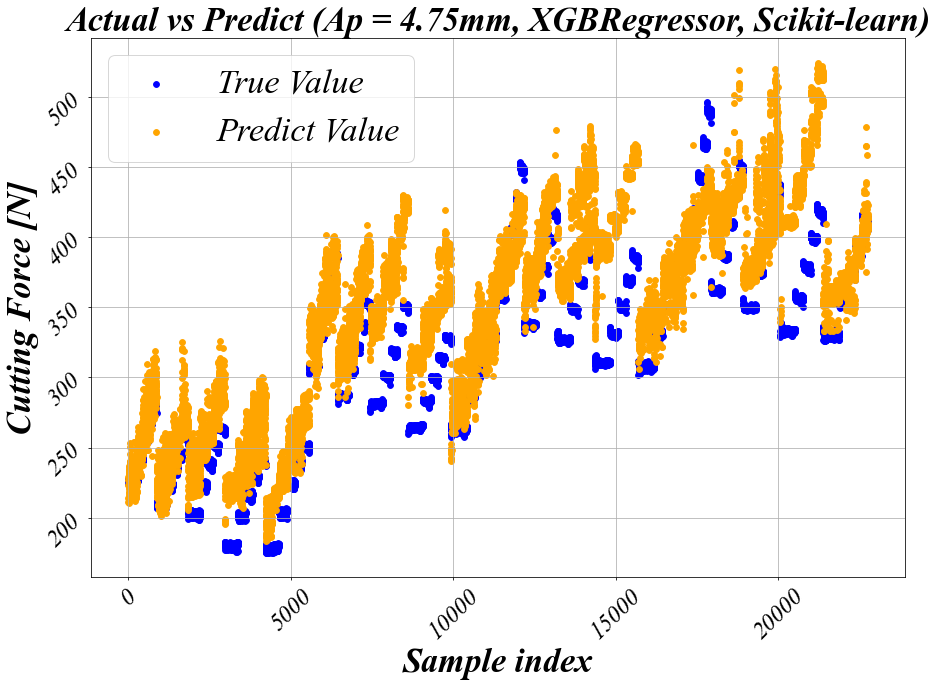

In [109]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 4.75mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ap4.75 cycle.png")

## Ap 600

In [110]:
train = pd.concat([ap_100, ap_225, ap_350, ap_475], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [111]:
X_test = ap_600.iloc[: , 1:]
y_test = ap_600['RMS_CF_max']

In [112]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [113]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:243.53335	validation_0-mape:0.98714	validation_1-rmse:418.09028	validation_1-mape:0.99006
[1]	validation_0-rmse:241.11173	validation_0-mape:0.97723	validation_1-rmse:414.67881	validation_1-mape:0.98180
[2]	validation_0-rmse:238.71449	validation_0-mape:0.96742	validation_1-rmse:411.30056	validation_1-mape:0.97362
[3]	validation_0-rmse:236.34118	validation_0-mape:0.95770	validation_1-rmse:407.88504	validation_1-mape:0.96515
[4]	validation_0-rmse:233.99177	validation_0-mape:0.94809	validation_1-rmse:404.60160	validation_1-mape:0.95720
[5]	validation_0-rmse:231.66580	validation_0-mape:0.93856	validation_1-rmse:401.24125	validation_1-mape:0.94886
[6]	validation_0-rmse:229.36318	validation_0-mape:0.92914	validation_1-rmse:397.95648	validation_1-mape:0.94072
[7]	validation_0-rmse:227.08376	validation_0-mape:0.91980	validation_1-rmse:394.73352	validation_1-mape:0.93292
[8]	validation_0-rmse:224.82707	validation_0-mape:0.91056	validation_1-rmse:391.48521	validation_1-mape:

[73]	validation_0-rmse:117.55312	validation_0-mape:0.47239	validation_1-rmse:242.06869	validation_1-mape:0.55798
[74]	validation_0-rmse:116.38427	validation_0-mape:0.46765	validation_1-rmse:240.55469	validation_1-mape:0.55436
[75]	validation_0-rmse:115.22731	validation_0-mape:0.46296	validation_1-rmse:239.03681	validation_1-mape:0.55076
[76]	validation_0-rmse:114.08175	validation_0-mape:0.45832	validation_1-rmse:237.56208	validation_1-mape:0.54723
[77]	validation_0-rmse:112.94776	validation_0-mape:0.45372	validation_1-rmse:236.09413	validation_1-mape:0.54373
[78]	validation_0-rmse:111.82525	validation_0-mape:0.44917	validation_1-rmse:234.62844	validation_1-mape:0.54025
[79]	validation_0-rmse:110.71446	validation_0-mape:0.44466	validation_1-rmse:233.12902	validation_1-mape:0.53668
[80]	validation_0-rmse:109.61482	validation_0-mape:0.44020	validation_1-rmse:231.64205	validation_1-mape:0.53314
[81]	validation_0-rmse:108.52622	validation_0-mape:0.43579	validation_1-rmse:230.17333	validatio

[146]	validation_0-rmse:56.85365	validation_0-mape:0.22626	validation_1-rmse:160.80999	validation_1-mape:0.36493
[147]	validation_0-rmse:56.29338	validation_0-mape:0.22399	validation_1-rmse:160.06534	validation_1-mape:0.36317
[148]	validation_0-rmse:55.73852	validation_0-mape:0.22174	validation_1-rmse:159.32775	validation_1-mape:0.36143
[149]	validation_0-rmse:55.19022	validation_0-mape:0.21952	validation_1-rmse:158.56526	validation_1-mape:0.35961
[150]	validation_0-rmse:54.64628	validation_0-mape:0.21731	validation_1-rmse:157.84233	validation_1-mape:0.35790
[151]	validation_0-rmse:54.10782	validation_0-mape:0.21513	validation_1-rmse:157.13867	validation_1-mape:0.35624
[152]	validation_0-rmse:53.57454	validation_0-mape:0.21297	validation_1-rmse:156.42658	validation_1-mape:0.35455
[153]	validation_0-rmse:53.04674	validation_0-mape:0.21083	validation_1-rmse:155.73274	validation_1-mape:0.35290
[154]	validation_0-rmse:52.52419	validation_0-mape:0.20872	validation_1-rmse:155.03651	validatio

[219]	validation_0-rmse:27.73036	validation_0-mape:0.10836	validation_1-rmse:121.84027	validation_1-mape:0.27343
[220]	validation_0-rmse:27.46240	validation_0-mape:0.10727	validation_1-rmse:121.47227	validation_1-mape:0.27260
[221]	validation_0-rmse:27.19669	validation_0-mape:0.10620	validation_1-rmse:121.10052	validation_1-mape:0.27174
[222]	validation_0-rmse:26.93371	validation_0-mape:0.10513	validation_1-rmse:120.73324	validation_1-mape:0.27088
[223]	validation_0-rmse:26.67370	validation_0-mape:0.10408	validation_1-rmse:120.38712	validation_1-mape:0.27009
[224]	validation_0-rmse:26.41650	validation_0-mape:0.10303	validation_1-rmse:120.03178	validation_1-mape:0.26929
[225]	validation_0-rmse:26.16163	validation_0-mape:0.10200	validation_1-rmse:119.68478	validation_1-mape:0.26847
[226]	validation_0-rmse:25.90938	validation_0-mape:0.10098	validation_1-rmse:119.34037	validation_1-mape:0.26765
[227]	validation_0-rmse:25.65949	validation_0-mape:0.09997	validation_1-rmse:118.97859	validatio

[292]	validation_0-rmse:13.89637	validation_0-mape:0.05199	validation_1-rmse:102.48644	validation_1-mape:0.22905
[293]	validation_0-rmse:13.77068	validation_0-mape:0.05147	validation_1-rmse:102.31121	validation_1-mape:0.22864
[294]	validation_0-rmse:13.64646	validation_0-mape:0.05096	validation_1-rmse:102.14100	validation_1-mape:0.22826
[295]	validation_0-rmse:13.52345	validation_0-mape:0.05045	validation_1-rmse:101.96845	validation_1-mape:0.22786
[296]	validation_0-rmse:13.40183	validation_0-mape:0.04995	validation_1-rmse:101.79747	validation_1-mape:0.22747
[297]	validation_0-rmse:13.28158	validation_0-mape:0.04945	validation_1-rmse:101.62458	validation_1-mape:0.22709
[298]	validation_0-rmse:13.16235	validation_0-mape:0.04896	validation_1-rmse:101.45113	validation_1-mape:0.22669
[299]	validation_0-rmse:13.04463	validation_0-mape:0.04848	validation_1-rmse:101.28620	validation_1-mape:0.22630
[300]	validation_0-rmse:12.92801	validation_0-mape:0.04800	validation_1-rmse:101.12761	validatio

[366]	validation_0-rmse:7.48254	validation_0-mape:0.02544	validation_1-rmse:93.37743	validation_1-mape:0.20824
[367]	validation_0-rmse:7.42762	validation_0-mape:0.02521	validation_1-rmse:93.29082	validation_1-mape:0.20804
[368]	validation_0-rmse:7.37329	validation_0-mape:0.02499	validation_1-rmse:93.20836	validation_1-mape:0.20785
[369]	validation_0-rmse:7.31952	validation_0-mape:0.02476	validation_1-rmse:93.12668	validation_1-mape:0.20767
[370]	validation_0-rmse:7.26663	validation_0-mape:0.02454	validation_1-rmse:93.05447	validation_1-mape:0.20754
[371]	validation_0-rmse:7.21380	validation_0-mape:0.02432	validation_1-rmse:92.97412	validation_1-mape:0.20735
[372]	validation_0-rmse:7.16197	validation_0-mape:0.02411	validation_1-rmse:92.89212	validation_1-mape:0.20715
[373]	validation_0-rmse:7.11117	validation_0-mape:0.02390	validation_1-rmse:92.80856	validation_1-mape:0.20696
[374]	validation_0-rmse:7.06115	validation_0-mape:0.02369	validation_1-rmse:92.71284	validation_1-mape:0.20673
[

[440]	validation_0-rmse:4.80012	validation_0-mape:0.01456	validation_1-rmse:88.87118	validation_1-mape:0.19780
[441]	validation_0-rmse:4.77820	validation_0-mape:0.01447	validation_1-rmse:88.83722	validation_1-mape:0.19777
[442]	validation_0-rmse:4.75676	validation_0-mape:0.01439	validation_1-rmse:88.79538	validation_1-mape:0.19767
[443]	validation_0-rmse:4.73560	validation_0-mape:0.01431	validation_1-rmse:88.76446	validation_1-mape:0.19765
[444]	validation_0-rmse:4.71575	validation_0-mape:0.01423	validation_1-rmse:88.72184	validation_1-mape:0.19755
[445]	validation_0-rmse:4.69550	validation_0-mape:0.01416	validation_1-rmse:88.68495	validation_1-mape:0.19746
[446]	validation_0-rmse:4.67517	validation_0-mape:0.01408	validation_1-rmse:88.65510	validation_1-mape:0.19744
[447]	validation_0-rmse:4.65542	validation_0-mape:0.01401	validation_1-rmse:88.61842	validation_1-mape:0.19735
[448]	validation_0-rmse:4.63580	validation_0-mape:0.01393	validation_1-rmse:88.57521	validation_1-mape:0.19725
[

[514]	validation_0-rmse:3.75135	validation_0-mape:0.01087	validation_1-rmse:86.77388	validation_1-mape:0.19371
[515]	validation_0-rmse:3.74253	validation_0-mape:0.01084	validation_1-rmse:86.75111	validation_1-mape:0.19366
[516]	validation_0-rmse:3.73418	validation_0-mape:0.01082	validation_1-rmse:86.73675	validation_1-mape:0.19366
[517]	validation_0-rmse:3.72603	validation_0-mape:0.01079	validation_1-rmse:86.72553	validation_1-mape:0.19364
[518]	validation_0-rmse:3.71734	validation_0-mape:0.01077	validation_1-rmse:86.69942	validation_1-mape:0.19358
[519]	validation_0-rmse:3.70911	validation_0-mape:0.01074	validation_1-rmse:86.67979	validation_1-mape:0.19354
[520]	validation_0-rmse:3.70105	validation_0-mape:0.01072	validation_1-rmse:86.66153	validation_1-mape:0.19352
[521]	validation_0-rmse:3.69341	validation_0-mape:0.01070	validation_1-rmse:86.64413	validation_1-mape:0.19348
[522]	validation_0-rmse:3.68566	validation_0-mape:0.01067	validation_1-rmse:86.63094	validation_1-mape:0.19349
[

[588]	validation_0-rmse:3.32315	validation_0-mape:0.00964	validation_1-rmse:85.71811	validation_1-mape:0.19196
[589]	validation_0-rmse:3.31899	validation_0-mape:0.00963	validation_1-rmse:85.70425	validation_1-mape:0.19194
[590]	validation_0-rmse:3.31533	validation_0-mape:0.00962	validation_1-rmse:85.69495	validation_1-mape:0.19194
[591]	validation_0-rmse:3.31114	validation_0-mape:0.00961	validation_1-rmse:85.69386	validation_1-mape:0.19195
[592]	validation_0-rmse:3.30746	validation_0-mape:0.00960	validation_1-rmse:85.66568	validation_1-mape:0.19189
[593]	validation_0-rmse:3.30392	validation_0-mape:0.00959	validation_1-rmse:85.66173	validation_1-mape:0.19190
[594]	validation_0-rmse:3.29988	validation_0-mape:0.00958	validation_1-rmse:85.63415	validation_1-mape:0.19184
[595]	validation_0-rmse:3.29641	validation_0-mape:0.00957	validation_1-rmse:85.62227	validation_1-mape:0.19182
[596]	validation_0-rmse:3.29294	validation_0-mape:0.00956	validation_1-rmse:85.61038	validation_1-mape:0.19180
[

[662]	validation_0-rmse:3.09574	validation_0-mape:0.00911	validation_1-rmse:85.11912	validation_1-mape:0.19125
[663]	validation_0-rmse:3.09305	validation_0-mape:0.00910	validation_1-rmse:85.10430	validation_1-mape:0.19123
[664]	validation_0-rmse:3.09094	validation_0-mape:0.00910	validation_1-rmse:85.10465	validation_1-mape:0.19124
[665]	validation_0-rmse:3.08853	validation_0-mape:0.00909	validation_1-rmse:85.10047	validation_1-mape:0.19124
[666]	validation_0-rmse:3.08592	validation_0-mape:0.00908	validation_1-rmse:85.10031	validation_1-mape:0.19127
[667]	validation_0-rmse:3.08385	validation_0-mape:0.00908	validation_1-rmse:85.09498	validation_1-mape:0.19127
[668]	validation_0-rmse:3.08165	validation_0-mape:0.00907	validation_1-rmse:85.09015	validation_1-mape:0.19126
[669]	validation_0-rmse:3.07956	validation_0-mape:0.00907	validation_1-rmse:85.08785	validation_1-mape:0.19126
[670]	validation_0-rmse:3.07747	validation_0-mape:0.00906	validation_1-rmse:85.08756	validation_1-mape:0.19126
[

[736]	validation_0-rmse:2.96034	validation_0-mape:0.00881	validation_1-rmse:84.99960	validation_1-mape:0.19178
[737]	validation_0-rmse:2.95865	validation_0-mape:0.00880	validation_1-rmse:84.99559	validation_1-mape:0.19177
[738]	validation_0-rmse:2.95719	validation_0-mape:0.00880	validation_1-rmse:84.99110	validation_1-mape:0.19176
[739]	validation_0-rmse:2.95607	validation_0-mape:0.00880	validation_1-rmse:84.98776	validation_1-mape:0.19176
[740]	validation_0-rmse:2.95470	validation_0-mape:0.00879	validation_1-rmse:84.99007	validation_1-mape:0.19179
[741]	validation_0-rmse:2.95294	validation_0-mape:0.00879	validation_1-rmse:84.98643	validation_1-mape:0.19179
[742]	validation_0-rmse:2.95129	validation_0-mape:0.00879	validation_1-rmse:84.99064	validation_1-mape:0.19183
[743]	validation_0-rmse:2.94961	validation_0-mape:0.00878	validation_1-rmse:84.98730	validation_1-mape:0.19182
[744]	validation_0-rmse:2.94803	validation_0-mape:0.00878	validation_1-rmse:84.98390	validation_1-mape:0.19181
[

[810]	validation_0-rmse:2.85111	validation_0-mape:0.00856	validation_1-rmse:84.90502	validation_1-mape:0.19211
[811]	validation_0-rmse:2.84996	validation_0-mape:0.00856	validation_1-rmse:84.90187	validation_1-mape:0.19210
[812]	validation_0-rmse:2.84882	validation_0-mape:0.00855	validation_1-rmse:84.89962	validation_1-mape:0.19210
[813]	validation_0-rmse:2.84758	validation_0-mape:0.00855	validation_1-rmse:84.89484	validation_1-mape:0.19209
[814]	validation_0-rmse:2.84610	validation_0-mape:0.00855	validation_1-rmse:84.89972	validation_1-mape:0.19213
[815]	validation_0-rmse:2.84436	validation_0-mape:0.00854	validation_1-rmse:84.90014	validation_1-mape:0.19213
[816]	validation_0-rmse:2.84359	validation_0-mape:0.00854	validation_1-rmse:84.89518	validation_1-mape:0.19212
[817]	validation_0-rmse:2.84251	validation_0-mape:0.00854	validation_1-rmse:84.89336	validation_1-mape:0.19212
[818]	validation_0-rmse:2.84070	validation_0-mape:0.00853	validation_1-rmse:84.88707	validation_1-mape:0.19211
[

[884]	validation_0-rmse:2.75682	validation_0-mape:0.00834	validation_1-rmse:84.81001	validation_1-mape:0.19222
[885]	validation_0-rmse:2.75576	validation_0-mape:0.00834	validation_1-rmse:84.81043	validation_1-mape:0.19222
[886]	validation_0-rmse:2.75373	validation_0-mape:0.00834	validation_1-rmse:84.80491	validation_1-mape:0.19221
[887]	validation_0-rmse:2.75254	validation_0-mape:0.00833	validation_1-rmse:84.80420	validation_1-mape:0.19221
[888]	validation_0-rmse:2.75163	validation_0-mape:0.00833	validation_1-rmse:84.80414	validation_1-mape:0.19222
[889]	validation_0-rmse:2.74923	validation_0-mape:0.00833	validation_1-rmse:84.80579	validation_1-mape:0.19222
[890]	validation_0-rmse:2.74842	validation_0-mape:0.00832	validation_1-rmse:84.80707	validation_1-mape:0.19223
[891]	validation_0-rmse:2.74741	validation_0-mape:0.00832	validation_1-rmse:84.80301	validation_1-mape:0.19223
[892]	validation_0-rmse:2.74561	validation_0-mape:0.00832	validation_1-rmse:84.80300	validation_1-mape:0.19223
[

[958]	validation_0-rmse:2.65776	validation_0-mape:0.00811	validation_1-rmse:84.76951	validation_1-mape:0.19246
[959]	validation_0-rmse:2.65674	validation_0-mape:0.00811	validation_1-rmse:84.76955	validation_1-mape:0.19247
[960]	validation_0-rmse:2.65499	validation_0-mape:0.00810	validation_1-rmse:84.77339	validation_1-mape:0.19249
[961]	validation_0-rmse:2.65376	validation_0-mape:0.00810	validation_1-rmse:84.77306	validation_1-mape:0.19249
[962]	validation_0-rmse:2.65232	validation_0-mape:0.00809	validation_1-rmse:84.77324	validation_1-mape:0.19249
[963]	validation_0-rmse:2.65137	validation_0-mape:0.00809	validation_1-rmse:84.77422	validation_1-mape:0.19250
[964]	validation_0-rmse:2.65070	validation_0-mape:0.00809	validation_1-rmse:84.77426	validation_1-mape:0.19250
[965]	validation_0-rmse:2.64970	validation_0-mape:0.00809	validation_1-rmse:84.77429	validation_1-mape:0.19250
[966]	validation_0-rmse:2.64848	validation_0-mape:0.00808	validation_1-rmse:84.77639	validation_1-mape:0.19251
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [114]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 2.6113
Train MAPE: 0.8000
Test RMSE: 84.7744
Test MAPE: 19.2632


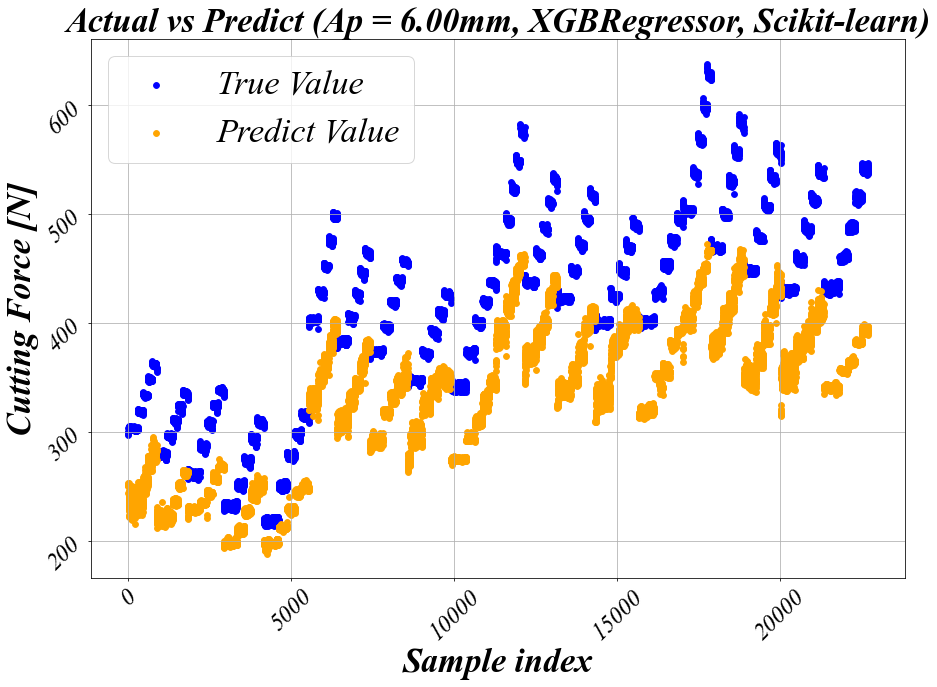

In [115]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 6.00mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning Ap6.0 cycle.png")

# Feed

In [116]:
feed_300 = groups_feed.get_group(300)
feed_300 = feed_300.reset_index(drop=True)
feed_300 = feed_300.drop(['Milling_Type'], axis=1)

feed_350 = groups_feed.get_group(350)
feed_350 = feed_350.reset_index(drop=True)
feed_350 = feed_350.drop(['Milling_Type'], axis=1)

feed_400 = groups_feed.get_group(400)
feed_400 = feed_400.reset_index(drop=True)
feed_400 = feed_400.drop(['Milling_Type'], axis=1)

feed_450 = groups_feed.get_group(450)
feed_450 = feed_450.reset_index(drop=True)
feed_450 = feed_450.drop(['Milling_Type'], axis=1)

feed_500 = groups_feed.get_group(500)
feed_500 = feed_500.reset_index(drop=True)
feed_500 = feed_500.drop(['Milling_Type'], axis=1)

## feed 300

In [117]:
train = pd.concat([feed_350, feed_400, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [118]:
X_test = feed_300.iloc[: , 1:]
y_test = feed_300['RMS_CF_max']

In [119]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [120]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 300,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:298.61244	validation_0-mape:0.98758	validation_1-rmse:260.94858	validation_1-mape:0.98629
[1]	validation_0-rmse:295.63789	validation_0-mape:0.97768	validation_1-rmse:258.10879	validation_1-mape:0.97544
[2]	validation_0-rmse:292.69318	validation_0-mape:0.96788	validation_1-rmse:255.29444	validation_1-mape:0.96468
[3]	validation_0-rmse:289.77793	validation_0-mape:0.95818	validation_1-rmse:252.50694	validation_1-mape:0.95404
[4]	validation_0-rmse:286.89190	validation_0-mape:0.94858	validation_1-rmse:249.74538	validation_1-mape:0.94349
[5]	validation_0-rmse:284.03479	validation_0-mape:0.93907	validation_1-rmse:247.01632	validation_1-mape:0.93307
[6]	validation_0-rmse:281.20631	validation_0-mape:0.92966	validation_1-rmse:244.30632	validation_1-mape:0.92273
[7]	validation_0-rmse:278.40606	validation_0-mape:0.92034	validation_1-rmse:241.63514	validation_1-mape:0.91253
[8]	validation_0-rmse:275.63402	validation_0-mape:0.91112	validation_1-rmse:238.98645	validation_1-mape:

[73]	validation_0-rmse:144.03410	validation_0-mape:0.47310	validation_1-rmse:114.95556	validation_1-mape:0.42806
[74]	validation_0-rmse:142.60683	validation_0-mape:0.46835	validation_1-rmse:113.63143	validation_1-mape:0.42300
[75]	validation_0-rmse:141.19197	validation_0-mape:0.46365	validation_1-rmse:112.34946	validation_1-mape:0.41808
[76]	validation_0-rmse:139.79134	validation_0-mape:0.45899	validation_1-rmse:111.07759	validation_1-mape:0.41318
[77]	validation_0-rmse:138.40703	validation_0-mape:0.45438	validation_1-rmse:109.78117	validation_1-mape:0.40823
[78]	validation_0-rmse:137.03421	validation_0-mape:0.44982	validation_1-rmse:108.52863	validation_1-mape:0.40342
[79]	validation_0-rmse:135.67720	validation_0-mape:0.44530	validation_1-rmse:107.29086	validation_1-mape:0.39861
[80]	validation_0-rmse:134.33163	validation_0-mape:0.44083	validation_1-rmse:106.06448	validation_1-mape:0.39392
[81]	validation_0-rmse:132.99968	validation_0-mape:0.43640	validation_1-rmse:104.85374	validatio

[146]	validation_0-rmse:69.75162	validation_0-mape:0.22620	validation_1-rmse:48.21522	validation_1-mape:0.16988
[147]	validation_0-rmse:69.06515	validation_0-mape:0.22393	validation_1-rmse:47.60116	validation_1-mape:0.16749
[148]	validation_0-rmse:68.38584	validation_0-mape:0.22167	validation_1-rmse:47.02056	validation_1-mape:0.16520
[149]	validation_0-rmse:67.71276	validation_0-mape:0.21944	validation_1-rmse:46.43558	validation_1-mape:0.16294
[150]	validation_0-rmse:67.04708	validation_0-mape:0.21723	validation_1-rmse:45.87127	validation_1-mape:0.16070
[151]	validation_0-rmse:66.38802	validation_0-mape:0.21504	validation_1-rmse:45.29633	validation_1-mape:0.15844
[152]	validation_0-rmse:65.73486	validation_0-mape:0.21288	validation_1-rmse:44.73896	validation_1-mape:0.15625
[153]	validation_0-rmse:65.08921	validation_0-mape:0.21073	validation_1-rmse:44.19587	validation_1-mape:0.15408
[154]	validation_0-rmse:64.44952	validation_0-mape:0.20861	validation_1-rmse:43.63941	validation_1-mape:

[220]	validation_0-rmse:33.77232	validation_0-mape:0.10696	validation_1-rmse:18.64628	validation_1-mape:0.05263
[221]	validation_0-rmse:33.44684	validation_0-mape:0.10588	validation_1-rmse:18.41113	validation_1-mape:0.05172
[222]	validation_0-rmse:33.12486	validation_0-mape:0.10482	validation_1-rmse:18.17868	validation_1-mape:0.05080
[223]	validation_0-rmse:32.80616	validation_0-mape:0.10376	validation_1-rmse:17.94291	validation_1-mape:0.04989
[224]	validation_0-rmse:32.48970	validation_0-mape:0.10272	validation_1-rmse:17.71815	validation_1-mape:0.04901
[225]	validation_0-rmse:32.17728	validation_0-mape:0.10168	validation_1-rmse:17.49260	validation_1-mape:0.04814
[226]	validation_0-rmse:31.86806	validation_0-mape:0.10066	validation_1-rmse:17.27294	validation_1-mape:0.04730
[227]	validation_0-rmse:31.56097	validation_0-mape:0.09965	validation_1-rmse:17.04521	validation_1-mape:0.04642
[228]	validation_0-rmse:31.25816	validation_0-mape:0.09865	validation_1-rmse:16.82920	validation_1-mape:

[294]	validation_0-rmse:16.76169	validation_0-mape:0.05073	validation_1-rmse:9.28472	validation_1-mape:0.02437
[295]	validation_0-rmse:16.60863	validation_0-mape:0.05023	validation_1-rmse:9.26313	validation_1-mape:0.02449
[296]	validation_0-rmse:16.45731	validation_0-mape:0.04973	validation_1-rmse:9.23819	validation_1-mape:0.02460
[297]	validation_0-rmse:16.30750	validation_0-mape:0.04924	validation_1-rmse:9.21946	validation_1-mape:0.02473
[298]	validation_0-rmse:16.15938	validation_0-mape:0.04875	validation_1-rmse:9.20523	validation_1-mape:0.02486
[299]	validation_0-rmse:16.01346	validation_0-mape:0.04826	validation_1-rmse:9.17610	validation_1-mape:0.02497


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [121]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 16.0135
Train MAPE: 4.8262
Test RMSE: 9.1761
Test MAPE: 2.4973


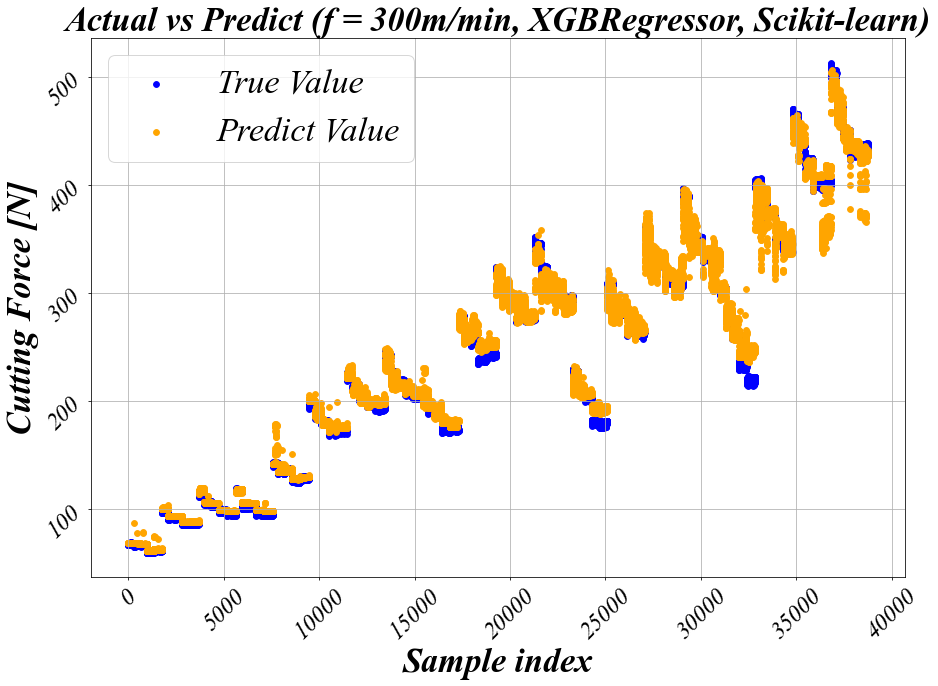

In [122]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 300m/min, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning feed300 cycle.png")

## feed 350

In [123]:
train = pd.concat([feed_300, feed_400, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [124]:
X_test = feed_350.iloc[: , 1:]
y_test = feed_350['RMS_CF_max']

In [125]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [126]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 400,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:288.69397	validation_0-mape:0.98746	validation_1-rmse:277.00230	validation_1-mape:0.98691
[1]	validation_0-rmse:285.82451	validation_0-mape:0.97753	validation_1-rmse:274.12824	validation_1-mape:0.97654
[2]	validation_0-rmse:282.98324	validation_0-mape:0.96771	validation_1-rmse:271.28006	validation_1-mape:0.96625
[3]	validation_0-rmse:280.17105	validation_0-mape:0.95798	validation_1-rmse:268.45923	validation_1-mape:0.95607
[4]	validation_0-rmse:277.38655	validation_0-mape:0.94835	validation_1-rmse:265.66846	validation_1-mape:0.94600
[5]	validation_0-rmse:274.62974	validation_0-mape:0.93882	validation_1-rmse:262.90943	validation_1-mape:0.93603
[6]	validation_0-rmse:271.90124	validation_0-mape:0.92938	validation_1-rmse:260.17402	validation_1-mape:0.92615
[7]	validation_0-rmse:269.19932	validation_0-mape:0.92004	validation_1-rmse:257.46997	validation_1-mape:0.91638
[8]	validation_0-rmse:266.52326	validation_0-mape:0.91080	validation_1-rmse:254.78700	validation_1-mape:

[73]	validation_0-rmse:139.51408	validation_0-mape:0.47189	validation_1-rmse:129.39199	validation_1-mape:0.45358
[74]	validation_0-rmse:138.13587	validation_0-mape:0.46712	validation_1-rmse:128.03564	validation_1-mape:0.44875
[75]	validation_0-rmse:136.77141	validation_0-mape:0.46241	validation_1-rmse:126.70664	validation_1-mape:0.44390
[76]	validation_0-rmse:135.41989	validation_0-mape:0.45776	validation_1-rmse:125.38857	validation_1-mape:0.43906
[77]	validation_0-rmse:134.08273	validation_0-mape:0.45314	validation_1-rmse:124.07222	validation_1-mape:0.43437
[78]	validation_0-rmse:132.75905	validation_0-mape:0.44857	validation_1-rmse:122.78438	validation_1-mape:0.42967
[79]	validation_0-rmse:131.44897	validation_0-mape:0.44404	validation_1-rmse:121.50023	validation_1-mape:0.42508
[80]	validation_0-rmse:130.15194	validation_0-mape:0.43956	validation_1-rmse:120.22204	validation_1-mape:0.42053
[81]	validation_0-rmse:128.86604	validation_0-mape:0.43513	validation_1-rmse:118.96503	validatio

[146]	validation_0-rmse:67.75159	validation_0-mape:0.22531	validation_1-rmse:58.82389	validation_1-mape:0.19930
[147]	validation_0-rmse:67.08671	validation_0-mape:0.22305	validation_1-rmse:58.14960	validation_1-mape:0.19691
[148]	validation_0-rmse:66.42990	validation_0-mape:0.22080	validation_1-rmse:57.52933	validation_1-mape:0.19465
[149]	validation_0-rmse:65.78041	validation_0-mape:0.21857	validation_1-rmse:56.90951	validation_1-mape:0.19239
[150]	validation_0-rmse:65.13613	validation_0-mape:0.21637	validation_1-rmse:56.26922	validation_1-mape:0.19009
[151]	validation_0-rmse:64.49877	validation_0-mape:0.21419	validation_1-rmse:55.68007	validation_1-mape:0.18791
[152]	validation_0-rmse:63.86761	validation_0-mape:0.21204	validation_1-rmse:55.05451	validation_1-mape:0.18569
[153]	validation_0-rmse:63.24319	validation_0-mape:0.20990	validation_1-rmse:54.45844	validation_1-mape:0.18350
[154]	validation_0-rmse:62.62536	validation_0-mape:0.20779	validation_1-rmse:53.85706	validation_1-mape:

[220]	validation_0-rmse:32.97298	validation_0-mape:0.10657	validation_1-rmse:25.52341	validation_1-mape:0.07801
[221]	validation_0-rmse:32.65977	validation_0-mape:0.10550	validation_1-rmse:25.23731	validation_1-mape:0.07695
[222]	validation_0-rmse:32.34732	validation_0-mape:0.10444	validation_1-rmse:24.95473	validation_1-mape:0.07590
[223]	validation_0-rmse:32.03815	validation_0-mape:0.10339	validation_1-rmse:24.68268	validation_1-mape:0.07490
[224]	validation_0-rmse:31.73448	validation_0-mape:0.10235	validation_1-rmse:24.39935	validation_1-mape:0.07381
[225]	validation_0-rmse:31.43165	validation_0-mape:0.10132	validation_1-rmse:24.13456	validation_1-mape:0.07283
[226]	validation_0-rmse:31.13416	validation_0-mape:0.10030	validation_1-rmse:23.86406	validation_1-mape:0.07183
[227]	validation_0-rmse:30.83972	validation_0-mape:0.09930	validation_1-rmse:23.58421	validation_1-mape:0.07081
[228]	validation_0-rmse:30.54611	validation_0-mape:0.09830	validation_1-rmse:23.32514	validation_1-mape:

[294]	validation_0-rmse:16.61777	validation_0-mape:0.05087	validation_1-rmse:11.57093	validation_1-mape:0.02840
[295]	validation_0-rmse:16.47287	validation_0-mape:0.05037	validation_1-rmse:11.47596	validation_1-mape:0.02813
[296]	validation_0-rmse:16.32906	validation_0-mape:0.04988	validation_1-rmse:11.38351	validation_1-mape:0.02786
[297]	validation_0-rmse:16.18665	validation_0-mape:0.04940	validation_1-rmse:11.27682	validation_1-mape:0.02757
[298]	validation_0-rmse:16.04563	validation_0-mape:0.04892	validation_1-rmse:11.18653	validation_1-mape:0.02731
[299]	validation_0-rmse:15.90631	validation_0-mape:0.04844	validation_1-rmse:11.08398	validation_1-mape:0.02704
[300]	validation_0-rmse:15.76898	validation_0-mape:0.04797	validation_1-rmse:11.00034	validation_1-mape:0.02680
[301]	validation_0-rmse:15.63324	validation_0-mape:0.04750	validation_1-rmse:10.91348	validation_1-mape:0.02658
[302]	validation_0-rmse:15.49836	validation_0-mape:0.04704	validation_1-rmse:10.81745	validation_1-mape:

[368]	validation_0-rmse:9.28282	validation_0-mape:0.02592	validation_1-rmse:8.56780	validation_1-mape:0.02347
[369]	validation_0-rmse:9.22158	validation_0-mape:0.02571	validation_1-rmse:8.56605	validation_1-mape:0.02353
[370]	validation_0-rmse:9.15978	validation_0-mape:0.02551	validation_1-rmse:8.56530	validation_1-mape:0.02358
[371]	validation_0-rmse:9.09912	validation_0-mape:0.02531	validation_1-rmse:8.56824	validation_1-mape:0.02364
[372]	validation_0-rmse:9.03930	validation_0-mape:0.02511	validation_1-rmse:8.56690	validation_1-mape:0.02369
[373]	validation_0-rmse:8.98107	validation_0-mape:0.02491	validation_1-rmse:8.56742	validation_1-mape:0.02374
[374]	validation_0-rmse:8.92258	validation_0-mape:0.02472	validation_1-rmse:8.57129	validation_1-mape:0.02380
[375]	validation_0-rmse:8.86481	validation_0-mape:0.02453	validation_1-rmse:8.57507	validation_1-mape:0.02386
[376]	validation_0-rmse:8.80694	validation_0-mape:0.02434	validation_1-rmse:8.57729	validation_1-mape:0.02392
[377]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [127]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 7.6779
Train MAPE: 2.0645
Test RMSE: 8.7558
Test MAPE: 2.5393


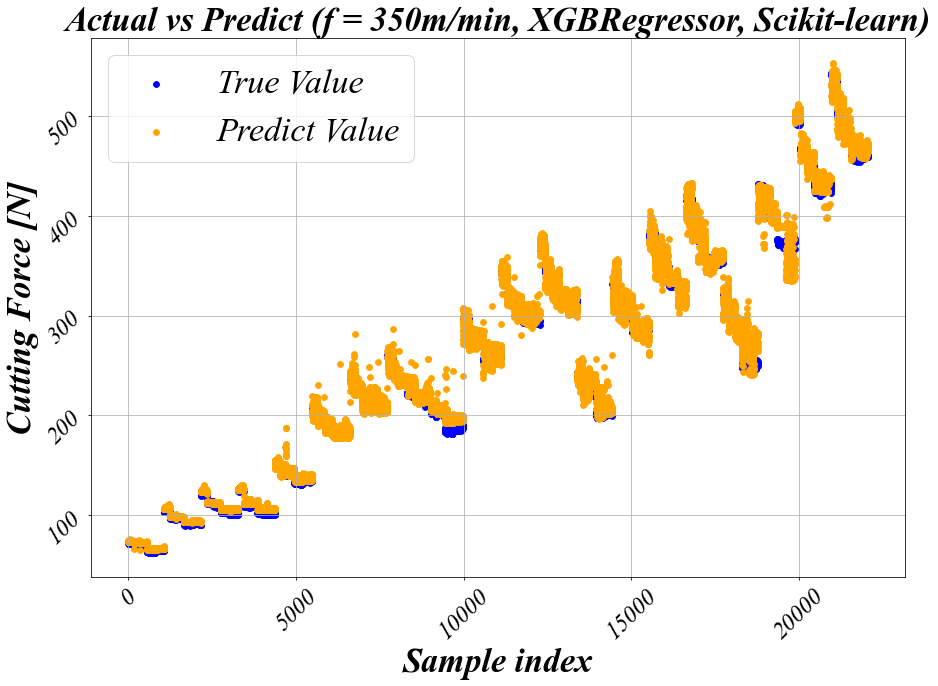

In [128]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 350m/min, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning feed350 cycle.png")

## feed 400

In [129]:
train = pd.concat([feed_300, feed_350, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [130]:
X_test = feed_400.iloc[: , 1:]
y_test = feed_400['RMS_CF_max']

In [131]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [132]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 390,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:285.05813	validation_0-mape:0.98743	validation_1-rmse:293.43819	validation_1-mape:0.98726
[1]	validation_0-rmse:282.22437	validation_0-mape:0.97750	validation_1-rmse:290.43203	validation_1-mape:0.97708
[2]	validation_0-rmse:279.41904	validation_0-mape:0.96768	validation_1-rmse:287.45735	validation_1-mape:0.96701
[3]	validation_0-rmse:276.64183	validation_0-mape:0.95796	validation_1-rmse:284.51135	validation_1-mape:0.95703
[4]	validation_0-rmse:273.89252	validation_0-mape:0.94833	validation_1-rmse:281.59562	validation_1-mape:0.94715
[5]	validation_0-rmse:271.17057	validation_0-mape:0.93880	validation_1-rmse:278.72195	validation_1-mape:0.93739
[6]	validation_0-rmse:268.47484	validation_0-mape:0.92937	validation_1-rmse:275.86280	validation_1-mape:0.92768
[7]	validation_0-rmse:265.80739	validation_0-mape:0.92003	validation_1-rmse:273.04202	validation_1-mape:0.91810
[8]	validation_0-rmse:263.16653	validation_0-mape:0.91078	validation_1-rmse:270.25054	validation_1-mape:

[73]	validation_0-rmse:137.74443	validation_0-mape:0.47194	validation_1-rmse:138.34689	validation_1-mape:0.45962
[74]	validation_0-rmse:136.38495	validation_0-mape:0.46718	validation_1-rmse:136.94619	validation_1-mape:0.45484
[75]	validation_0-rmse:135.03695	validation_0-mape:0.46247	validation_1-rmse:135.56069	validation_1-mape:0.45013
[76]	validation_0-rmse:133.70327	validation_0-mape:0.45781	validation_1-rmse:134.15271	validation_1-mape:0.44534
[77]	validation_0-rmse:132.38381	validation_0-mape:0.45319	validation_1-rmse:132.78423	validation_1-mape:0.44066
[78]	validation_0-rmse:131.07560	validation_0-mape:0.44862	validation_1-rmse:131.37955	validation_1-mape:0.43593
[79]	validation_0-rmse:129.78107	validation_0-mape:0.44410	validation_1-rmse:130.01767	validation_1-mape:0.43130
[80]	validation_0-rmse:128.49960	validation_0-mape:0.43963	validation_1-rmse:128.66932	validation_1-mape:0.42672
[81]	validation_0-rmse:127.23033	validation_0-mape:0.43520	validation_1-rmse:127.35618	validatio

[146]	validation_0-rmse:66.93964	validation_0-mape:0.22524	validation_1-rmse:63.70832	validation_1-mape:0.20587
[147]	validation_0-rmse:66.28405	validation_0-mape:0.22297	validation_1-rmse:62.99140	validation_1-mape:0.20346
[148]	validation_0-rmse:65.63586	validation_0-mape:0.22072	validation_1-rmse:62.30090	validation_1-mape:0.20110
[149]	validation_0-rmse:64.99332	validation_0-mape:0.21850	validation_1-rmse:61.60847	validation_1-mape:0.19874
[150]	validation_0-rmse:64.35824	validation_0-mape:0.21629	validation_1-rmse:60.93711	validation_1-mape:0.19646
[151]	validation_0-rmse:63.72959	validation_0-mape:0.21411	validation_1-rmse:60.27066	validation_1-mape:0.19419
[152]	validation_0-rmse:63.10625	validation_0-mape:0.21196	validation_1-rmse:59.59622	validation_1-mape:0.19189
[153]	validation_0-rmse:62.48877	validation_0-mape:0.20982	validation_1-rmse:58.92558	validation_1-mape:0.18963
[154]	validation_0-rmse:61.87892	validation_0-mape:0.20771	validation_1-rmse:58.27278	validation_1-mape:

[220]	validation_0-rmse:32.59004	validation_0-mape:0.10654	validation_1-rmse:27.67502	validation_1-mape:0.08267
[221]	validation_0-rmse:32.27827	validation_0-mape:0.10548	validation_1-rmse:27.35818	validation_1-mape:0.08155
[222]	validation_0-rmse:31.96969	validation_0-mape:0.10442	validation_1-rmse:27.04474	validation_1-mape:0.08044
[223]	validation_0-rmse:31.66462	validation_0-mape:0.10337	validation_1-rmse:26.71959	validation_1-mape:0.07931
[224]	validation_0-rmse:31.36238	validation_0-mape:0.10233	validation_1-rmse:26.41394	validation_1-mape:0.07823
[225]	validation_0-rmse:31.06348	validation_0-mape:0.10131	validation_1-rmse:26.11181	validation_1-mape:0.07717
[226]	validation_0-rmse:30.76753	validation_0-mape:0.10029	validation_1-rmse:25.81468	validation_1-mape:0.07611
[227]	validation_0-rmse:30.47477	validation_0-mape:0.09929	validation_1-rmse:25.50735	validation_1-mape:0.07504
[228]	validation_0-rmse:30.18498	validation_0-mape:0.09829	validation_1-rmse:25.21342	validation_1-mape:

[294]	validation_0-rmse:16.42489	validation_0-mape:0.05092	validation_1-rmse:12.24277	validation_1-mape:0.02819
[295]	validation_0-rmse:16.28160	validation_0-mape:0.05042	validation_1-rmse:12.12821	validation_1-mape:0.02786
[296]	validation_0-rmse:16.13988	validation_0-mape:0.04993	validation_1-rmse:12.01749	validation_1-mape:0.02754
[297]	validation_0-rmse:15.99987	validation_0-mape:0.04945	validation_1-rmse:11.91406	validation_1-mape:0.02723
[298]	validation_0-rmse:15.86154	validation_0-mape:0.04897	validation_1-rmse:11.81711	validation_1-mape:0.02696
[299]	validation_0-rmse:15.72416	validation_0-mape:0.04850	validation_1-rmse:11.71161	validation_1-mape:0.02666
[300]	validation_0-rmse:15.58784	validation_0-mape:0.04803	validation_1-rmse:11.61337	validation_1-mape:0.02639
[301]	validation_0-rmse:15.45286	validation_0-mape:0.04756	validation_1-rmse:11.51266	validation_1-mape:0.02612
[302]	validation_0-rmse:15.31954	validation_0-mape:0.04710	validation_1-rmse:11.41760	validation_1-mape:

[368]	validation_0-rmse:9.17016	validation_0-mape:0.02593	validation_1-rmse:8.75428	validation_1-mape:0.02214
[369]	validation_0-rmse:9.10842	validation_0-mape:0.02572	validation_1-rmse:8.75381	validation_1-mape:0.02221
[370]	validation_0-rmse:9.04756	validation_0-mape:0.02552	validation_1-rmse:8.75069	validation_1-mape:0.02226
[371]	validation_0-rmse:8.98749	validation_0-mape:0.02532	validation_1-rmse:8.74915	validation_1-mape:0.02231
[372]	validation_0-rmse:8.92819	validation_0-mape:0.02512	validation_1-rmse:8.74850	validation_1-mape:0.02236
[373]	validation_0-rmse:8.86989	validation_0-mape:0.02492	validation_1-rmse:8.74835	validation_1-mape:0.02242
[374]	validation_0-rmse:8.81197	validation_0-mape:0.02473	validation_1-rmse:8.74771	validation_1-mape:0.02247
[375]	validation_0-rmse:8.75500	validation_0-mape:0.02454	validation_1-rmse:8.74784	validation_1-mape:0.02253
[376]	validation_0-rmse:8.69908	validation_0-mape:0.02435	validation_1-rmse:8.74912	validation_1-mape:0.02259
[377]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=390, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [133]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 8.0283
Train MAPE: 2.2104
Test RMSE: 8.8135
Test MAPE: 2.3433


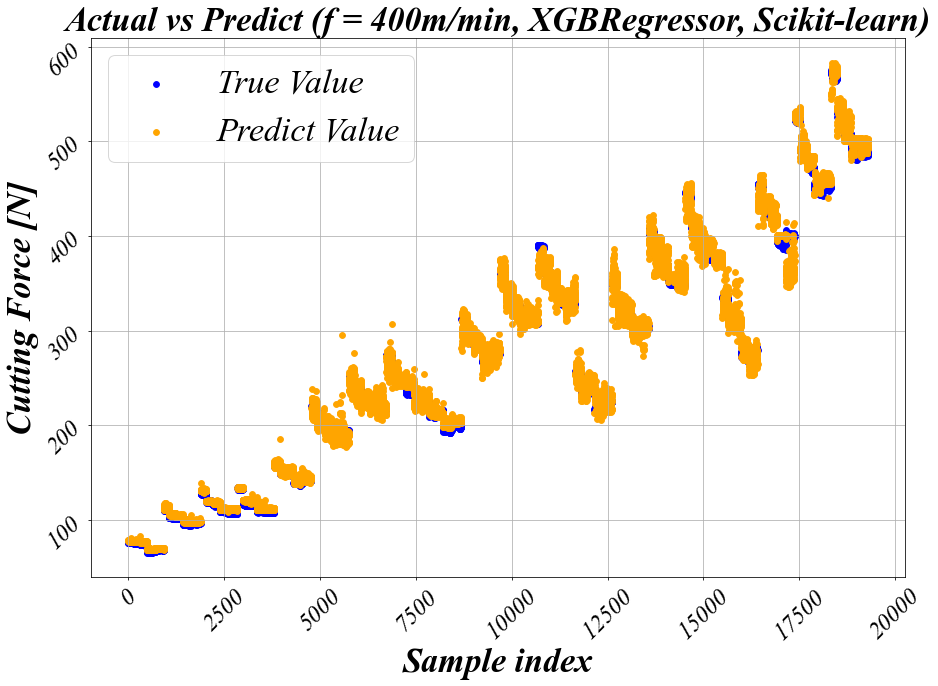

In [134]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 400m/min, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning feed400 cycle.png")

## feed 450

In [135]:
train = pd.concat([feed_300, feed_350, feed_400, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [136]:
X_test = feed_450.iloc[: , 1:]
y_test = feed_450['RMS_CF_max']

In [137]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [142]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 400,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:282.41587	validation_0-mape:0.98741	validation_1-rmse:308.77597	validation_1-mape:0.98786
[1]	validation_0-rmse:279.60786	validation_0-mape:0.97749	validation_1-rmse:305.74607	validation_1-mape:0.97815
[2]	validation_0-rmse:276.82806	validation_0-mape:0.96767	validation_1-rmse:302.74337	validation_1-mape:0.96853
[3]	validation_0-rmse:274.07604	validation_0-mape:0.95795	validation_1-rmse:299.77298	validation_1-mape:0.95897
[4]	validation_0-rmse:271.35369	validation_0-mape:0.94832	validation_1-rmse:296.83990	validation_1-mape:0.94954
[5]	validation_0-rmse:268.65643	validation_0-mape:0.93879	validation_1-rmse:293.94336	validation_1-mape:0.94022
[6]	validation_0-rmse:265.98613	validation_0-mape:0.92936	validation_1-rmse:291.05859	validation_1-mape:0.93096
[7]	validation_0-rmse:263.34265	validation_0-mape:0.92003	validation_1-rmse:288.20645	validation_1-mape:0.92179
[8]	validation_0-rmse:260.72530	validation_0-mape:0.91078	validation_1-rmse:285.33528	validation_1-mape:

[73]	validation_0-rmse:136.49781	validation_0-mape:0.47187	validation_1-rmse:150.32872	validation_1-mape:0.47757
[74]	validation_0-rmse:135.14979	validation_0-mape:0.46711	validation_1-rmse:148.85126	validation_1-mape:0.47282
[75]	validation_0-rmse:133.81584	validation_0-mape:0.46240	validation_1-rmse:147.40878	validation_1-mape:0.46818
[76]	validation_0-rmse:132.49506	validation_0-mape:0.45774	validation_1-rmse:145.96337	validation_1-mape:0.46350
[77]	validation_0-rmse:131.18814	validation_0-mape:0.45312	validation_1-rmse:144.54765	validation_1-mape:0.45895
[78]	validation_0-rmse:129.89334	validation_0-mape:0.44854	validation_1-rmse:143.12333	validation_1-mape:0.45430
[79]	validation_0-rmse:128.60738	validation_0-mape:0.44404	validation_1-rmse:141.72855	validation_1-mape:0.44981
[80]	validation_0-rmse:127.33438	validation_0-mape:0.43957	validation_1-rmse:140.34847	validation_1-mape:0.44536
[81]	validation_0-rmse:126.07829	validation_0-mape:0.43513	validation_1-rmse:138.97668	validatio

[146]	validation_0-rmse:66.32480	validation_0-mape:0.22534	validation_1-rmse:73.25473	validation_1-mape:0.22819
[147]	validation_0-rmse:65.67519	validation_0-mape:0.22308	validation_1-rmse:72.48301	validation_1-mape:0.22572
[148]	validation_0-rmse:65.03517	validation_0-mape:0.22082	validation_1-rmse:71.75867	validation_1-mape:0.22342
[149]	validation_0-rmse:64.39925	validation_0-mape:0.21860	validation_1-rmse:71.04712	validation_1-mape:0.22110
[150]	validation_0-rmse:63.76992	validation_0-mape:0.21640	validation_1-rmse:70.34212	validation_1-mape:0.21884
[151]	validation_0-rmse:63.14798	validation_0-mape:0.21421	validation_1-rmse:69.65842	validation_1-mape:0.21663
[152]	validation_0-rmse:62.53039	validation_0-mape:0.21206	validation_1-rmse:68.96556	validation_1-mape:0.21443
[153]	validation_0-rmse:61.91979	validation_0-mape:0.20992	validation_1-rmse:68.27760	validation_1-mape:0.21222
[154]	validation_0-rmse:61.31462	validation_0-mape:0.20780	validation_1-rmse:67.60093	validation_1-mape:

[220]	validation_0-rmse:32.35997	validation_0-mape:0.10647	validation_1-rmse:34.65347	validation_1-mape:0.10392
[221]	validation_0-rmse:32.05451	validation_0-mape:0.10540	validation_1-rmse:34.29635	validation_1-mape:0.10276
[222]	validation_0-rmse:31.75198	validation_0-mape:0.10434	validation_1-rmse:33.93947	validation_1-mape:0.10161
[223]	validation_0-rmse:31.45083	validation_0-mape:0.10330	validation_1-rmse:33.59188	validation_1-mape:0.10048
[224]	validation_0-rmse:31.15281	validation_0-mape:0.10226	validation_1-rmse:33.24256	validation_1-mape:0.09936
[225]	validation_0-rmse:30.85886	validation_0-mape:0.10123	validation_1-rmse:32.90511	validation_1-mape:0.09827
[226]	validation_0-rmse:30.56497	validation_0-mape:0.10022	validation_1-rmse:32.55444	validation_1-mape:0.09713
[227]	validation_0-rmse:30.27405	validation_0-mape:0.09921	validation_1-rmse:32.20394	validation_1-mape:0.09599
[228]	validation_0-rmse:29.98616	validation_0-mape:0.09822	validation_1-rmse:31.85022	validation_1-mape:

[294]	validation_0-rmse:16.33929	validation_0-mape:0.05096	validation_1-rmse:15.68801	validation_1-mape:0.04165
[295]	validation_0-rmse:16.19773	validation_0-mape:0.05047	validation_1-rmse:15.52306	validation_1-mape:0.04111
[296]	validation_0-rmse:16.05772	validation_0-mape:0.04998	validation_1-rmse:15.36744	validation_1-mape:0.04060
[297]	validation_0-rmse:15.91903	validation_0-mape:0.04950	validation_1-rmse:15.20751	validation_1-mape:0.04008
[298]	validation_0-rmse:15.78211	validation_0-mape:0.04902	validation_1-rmse:15.06813	validation_1-mape:0.03961
[299]	validation_0-rmse:15.64663	validation_0-mape:0.04855	validation_1-rmse:14.91287	validation_1-mape:0.03910
[300]	validation_0-rmse:15.51252	validation_0-mape:0.04808	validation_1-rmse:14.76401	validation_1-mape:0.03860
[301]	validation_0-rmse:15.37994	validation_0-mape:0.04761	validation_1-rmse:14.61838	validation_1-mape:0.03812
[302]	validation_0-rmse:15.24907	validation_0-mape:0.04715	validation_1-rmse:14.48251	validation_1-mape:

[368]	validation_0-rmse:9.16453	validation_0-mape:0.02598	validation_1-rmse:8.68504	validation_1-mape:0.02135
[369]	validation_0-rmse:9.10360	validation_0-mape:0.02577	validation_1-rmse:8.64528	validation_1-mape:0.02127
[370]	validation_0-rmse:9.04372	validation_0-mape:0.02557	validation_1-rmse:8.60238	validation_1-mape:0.02119
[371]	validation_0-rmse:8.98466	validation_0-mape:0.02536	validation_1-rmse:8.55892	validation_1-mape:0.02110
[372]	validation_0-rmse:8.92613	validation_0-mape:0.02516	validation_1-rmse:8.52283	validation_1-mape:0.02103
[373]	validation_0-rmse:8.86878	validation_0-mape:0.02496	validation_1-rmse:8.48678	validation_1-mape:0.02096
[374]	validation_0-rmse:8.81194	validation_0-mape:0.02476	validation_1-rmse:8.44851	validation_1-mape:0.02089
[375]	validation_0-rmse:8.75581	validation_0-mape:0.02457	validation_1-rmse:8.41081	validation_1-mape:0.02081
[376]	validation_0-rmse:8.70001	validation_0-mape:0.02438	validation_1-rmse:8.37934	validation_1-mape:0.02075
[377]	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [143]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 7.6020
Train MAPE: 2.0619
Test RMSE: 7.8434
Test MAPE: 1.9953


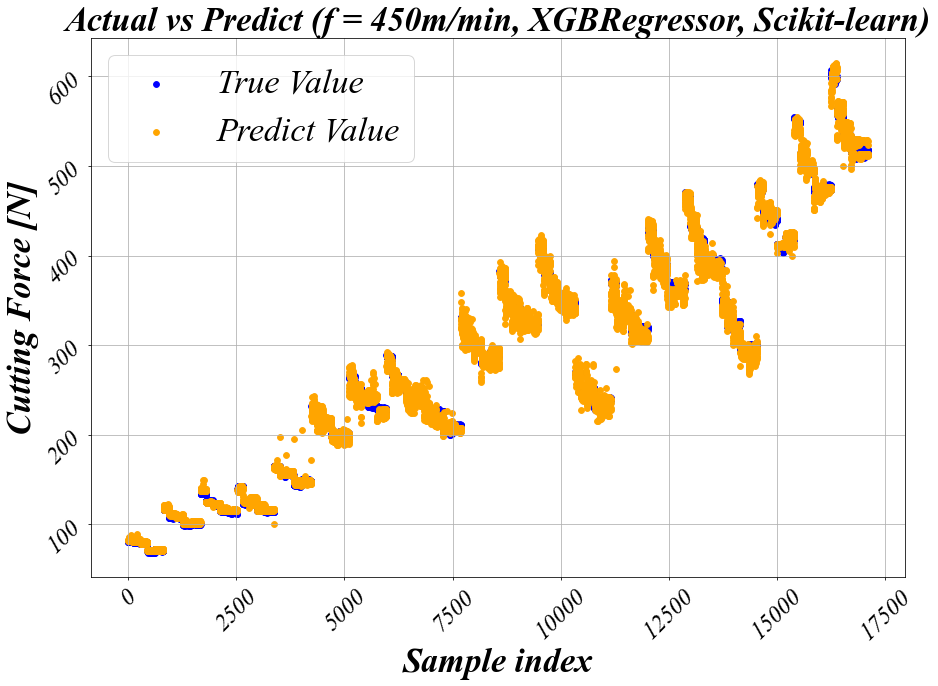

In [144]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 450m/min, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning feed450 cycle.png")

## feed 500

In [145]:
train = pd.concat([feed_300, feed_350, feed_400, feed_450], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [146]:
X_test = feed_500.iloc[: , 1:]
y_test = feed_500['RMS_CF_max']

In [147]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [148]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:280.17023	validation_0-mape:0.98740	validation_1-rmse:319.95303	validation_1-mape:0.98847
[1]	validation_0-rmse:277.38282	validation_0-mape:0.97749	validation_1-rmse:316.99930	validation_1-mape:0.97929
[2]	validation_0-rmse:274.62317	validation_0-mape:0.96768	validation_1-rmse:314.06827	validation_1-mape:0.97017
[3]	validation_0-rmse:271.89124	validation_0-mape:0.95797	validation_1-rmse:311.17098	validation_1-mape:0.96117
[4]	validation_0-rmse:269.18666	validation_0-mape:0.94835	validation_1-rmse:308.29297	validation_1-mape:0.95222
[5]	validation_0-rmse:266.50925	validation_0-mape:0.93883	validation_1-rmse:305.45585	validation_1-mape:0.94339
[6]	validation_0-rmse:263.85887	validation_0-mape:0.92940	validation_1-rmse:302.64729	validation_1-mape:0.93465
[7]	validation_0-rmse:261.23478	validation_0-mape:0.92007	validation_1-rmse:299.85853	validation_1-mape:0.92598
[8]	validation_0-rmse:258.63714	validation_0-mape:0.91083	validation_1-rmse:297.09039	validation_1-mape:

[73]	validation_0-rmse:135.31804	validation_0-mape:0.47215	validation_1-rmse:165.16643	validation_1-mape:0.50488
[74]	validation_0-rmse:133.98176	validation_0-mape:0.46739	validation_1-rmse:163.71012	validation_1-mape:0.50024
[75]	validation_0-rmse:132.65273	validation_0-mape:0.46269	validation_1-rmse:162.25721	validation_1-mape:0.49574
[76]	validation_0-rmse:131.33705	validation_0-mape:0.45805	validation_1-rmse:160.81818	validation_1-mape:0.49130
[77]	validation_0-rmse:130.03463	validation_0-mape:0.45345	validation_1-rmse:159.38574	validation_1-mape:0.48685
[78]	validation_0-rmse:128.74528	validation_0-mape:0.44889	validation_1-rmse:157.96139	validation_1-mape:0.48250
[79]	validation_0-rmse:127.46891	validation_0-mape:0.44439	validation_1-rmse:156.56839	validation_1-mape:0.47820
[80]	validation_0-rmse:126.20538	validation_0-mape:0.43993	validation_1-rmse:155.18032	validation_1-mape:0.47394
[81]	validation_0-rmse:124.95959	validation_0-mape:0.43548	validation_1-rmse:153.82711	validatio

[146]	validation_0-rmse:65.64435	validation_0-mape:0.22564	validation_1-rmse:88.11577	validation_1-mape:0.26610
[147]	validation_0-rmse:65.00043	validation_0-mape:0.22337	validation_1-rmse:87.38807	validation_1-mape:0.26384
[148]	validation_0-rmse:64.36333	validation_0-mape:0.22112	validation_1-rmse:86.67110	validation_1-mape:0.26165
[149]	validation_0-rmse:63.73270	validation_0-mape:0.21890	validation_1-rmse:85.96262	validation_1-mape:0.25946
[150]	validation_0-rmse:63.11015	validation_0-mape:0.21669	validation_1-rmse:85.24609	validation_1-mape:0.25724
[151]	validation_0-rmse:62.49175	validation_0-mape:0.21451	validation_1-rmse:84.55055	validation_1-mape:0.25510
[152]	validation_0-rmse:61.87947	validation_0-mape:0.21235	validation_1-rmse:83.86324	validation_1-mape:0.25297
[153]	validation_0-rmse:61.27366	validation_0-mape:0.21021	validation_1-rmse:83.18474	validation_1-mape:0.25090
[154]	validation_0-rmse:60.67379	validation_0-mape:0.20809	validation_1-rmse:82.52932	validation_1-mape:

[220]	validation_0-rmse:31.89935	validation_0-mape:0.10674	validation_1-rmse:49.56838	validation_1-mape:0.14652
[221]	validation_0-rmse:31.59387	validation_0-mape:0.10567	validation_1-rmse:49.21721	validation_1-mape:0.14541
[222]	validation_0-rmse:31.29154	validation_0-mape:0.10461	validation_1-rmse:48.86378	validation_1-mape:0.14433
[223]	validation_0-rmse:30.99225	validation_0-mape:0.10356	validation_1-rmse:48.53275	validation_1-mape:0.14328
[224]	validation_0-rmse:30.69607	validation_0-mape:0.10252	validation_1-rmse:48.17835	validation_1-mape:0.14220
[225]	validation_0-rmse:30.40295	validation_0-mape:0.10149	validation_1-rmse:47.85465	validation_1-mape:0.14117
[226]	validation_0-rmse:30.11289	validation_0-mape:0.10047	validation_1-rmse:47.51342	validation_1-mape:0.14012
[227]	validation_0-rmse:29.82561	validation_0-mape:0.09947	validation_1-rmse:47.18612	validation_1-mape:0.13910
[228]	validation_0-rmse:29.54127	validation_0-mape:0.09847	validation_1-rmse:46.85148	validation_1-mape:

[294]	validation_0-rmse:16.01577	validation_0-mape:0.05086	validation_1-rmse:30.66217	validation_1-mape:0.08815
[295]	validation_0-rmse:15.87348	validation_0-mape:0.05036	validation_1-rmse:30.48329	validation_1-mape:0.08760
[296]	validation_0-rmse:15.73288	validation_0-mape:0.04986	validation_1-rmse:30.31328	validation_1-mape:0.08706
[297]	validation_0-rmse:15.59370	validation_0-mape:0.04938	validation_1-rmse:30.13737	validation_1-mape:0.08652
[298]	validation_0-rmse:15.45592	validation_0-mape:0.04889	validation_1-rmse:29.97314	validation_1-mape:0.08600
[299]	validation_0-rmse:15.31965	validation_0-mape:0.04842	validation_1-rmse:29.79967	validation_1-mape:0.08546
[300]	validation_0-rmse:15.18476	validation_0-mape:0.04794	validation_1-rmse:29.63749	validation_1-mape:0.08494
[301]	validation_0-rmse:15.05148	validation_0-mape:0.04748	validation_1-rmse:29.46423	validation_1-mape:0.08441
[302]	validation_0-rmse:14.91975	validation_0-mape:0.04701	validation_1-rmse:29.30535	validation_1-mape:

[368]	validation_0-rmse:8.80703	validation_0-mape:0.02550	validation_1-rmse:21.47683	validation_1-mape:0.05981
[369]	validation_0-rmse:8.74554	validation_0-mape:0.02529	validation_1-rmse:21.39387	validation_1-mape:0.05955
[370]	validation_0-rmse:8.68493	validation_0-mape:0.02507	validation_1-rmse:21.31021	validation_1-mape:0.05929
[371]	validation_0-rmse:8.62488	validation_0-mape:0.02486	validation_1-rmse:21.22504	validation_1-mape:0.05903
[372]	validation_0-rmse:8.56553	validation_0-mape:0.02466	validation_1-rmse:21.14679	validation_1-mape:0.05879
[373]	validation_0-rmse:8.50693	validation_0-mape:0.02445	validation_1-rmse:21.06506	validation_1-mape:0.05853
[374]	validation_0-rmse:8.44989	validation_0-mape:0.02425	validation_1-rmse:20.98384	validation_1-mape:0.05829
[375]	validation_0-rmse:8.39273	validation_0-mape:0.02405	validation_1-rmse:20.90306	validation_1-mape:0.05805
[376]	validation_0-rmse:8.33607	validation_0-mape:0.02385	validation_1-rmse:20.82721	validation_1-mape:0.05781
[

[442]	validation_0-rmse:5.82066	validation_0-mape:0.01522	validation_1-rmse:17.07393	validation_1-mape:0.04625
[443]	validation_0-rmse:5.79637	validation_0-mape:0.01514	validation_1-rmse:17.03185	validation_1-mape:0.04612
[444]	validation_0-rmse:5.77234	validation_0-mape:0.01506	validation_1-rmse:16.98889	validation_1-mape:0.04599
[445]	validation_0-rmse:5.74822	validation_0-mape:0.01498	validation_1-rmse:16.94872	validation_1-mape:0.04587
[446]	validation_0-rmse:5.72535	validation_0-mape:0.01491	validation_1-rmse:16.90671	validation_1-mape:0.04574
[447]	validation_0-rmse:5.70283	validation_0-mape:0.01483	validation_1-rmse:16.86671	validation_1-mape:0.04561
[448]	validation_0-rmse:5.68038	validation_0-mape:0.01476	validation_1-rmse:16.83126	validation_1-mape:0.04551
[449]	validation_0-rmse:5.65763	validation_0-mape:0.01469	validation_1-rmse:16.79469	validation_1-mape:0.04539
[450]	validation_0-rmse:5.63550	validation_0-mape:0.01461	validation_1-rmse:16.75500	validation_1-mape:0.04527
[

[516]	validation_0-rmse:4.66421	validation_0-mape:0.01162	validation_1-rmse:14.84545	validation_1-mape:0.03943
[517]	validation_0-rmse:4.65453	validation_0-mape:0.01160	validation_1-rmse:14.82365	validation_1-mape:0.03936
[518]	validation_0-rmse:4.64453	validation_0-mape:0.01157	validation_1-rmse:14.80428	validation_1-mape:0.03930
[519]	validation_0-rmse:4.63518	validation_0-mape:0.01154	validation_1-rmse:14.78293	validation_1-mape:0.03923
[520]	validation_0-rmse:4.62585	validation_0-mape:0.01152	validation_1-rmse:14.76500	validation_1-mape:0.03918
[521]	validation_0-rmse:4.61657	validation_0-mape:0.01149	validation_1-rmse:14.74481	validation_1-mape:0.03911
[522]	validation_0-rmse:4.60728	validation_0-mape:0.01146	validation_1-rmse:14.72490	validation_1-mape:0.03905
[523]	validation_0-rmse:4.59807	validation_0-mape:0.01144	validation_1-rmse:14.70506	validation_1-mape:0.03898
[524]	validation_0-rmse:4.58901	validation_0-mape:0.01142	validation_1-rmse:14.68740	validation_1-mape:0.03893
[

[590]	validation_0-rmse:4.16049	validation_0-mape:0.01038	validation_1-rmse:13.73028	validation_1-mape:0.03601
[591]	validation_0-rmse:4.15477	validation_0-mape:0.01036	validation_1-rmse:13.72118	validation_1-mape:0.03599
[592]	validation_0-rmse:4.15063	validation_0-mape:0.01035	validation_1-rmse:13.70574	validation_1-mape:0.03595
[593]	validation_0-rmse:4.14637	validation_0-mape:0.01034	validation_1-rmse:13.69572	validation_1-mape:0.03591
[594]	validation_0-rmse:4.14110	validation_0-mape:0.01033	validation_1-rmse:13.68789	validation_1-mape:0.03590
[595]	validation_0-rmse:4.13655	validation_0-mape:0.01032	validation_1-rmse:13.67782	validation_1-mape:0.03587
[596]	validation_0-rmse:4.13289	validation_0-mape:0.01031	validation_1-rmse:13.66715	validation_1-mape:0.03583
[597]	validation_0-rmse:4.12818	validation_0-mape:0.01030	validation_1-rmse:13.65857	validation_1-mape:0.03580
[598]	validation_0-rmse:4.12440	validation_0-mape:0.01029	validation_1-rmse:13.64829	validation_1-mape:0.03577
[

[664]	validation_0-rmse:3.87912	validation_0-mape:0.00980	validation_1-rmse:13.11772	validation_1-mape:0.03423
[665]	validation_0-rmse:3.87555	validation_0-mape:0.00979	validation_1-rmse:13.11350	validation_1-mape:0.03422
[666]	validation_0-rmse:3.87266	validation_0-mape:0.00978	validation_1-rmse:13.10447	validation_1-mape:0.03420
[667]	validation_0-rmse:3.87019	validation_0-mape:0.00978	validation_1-rmse:13.10060	validation_1-mape:0.03419
[668]	validation_0-rmse:3.86706	validation_0-mape:0.00977	validation_1-rmse:13.09507	validation_1-mape:0.03418
[669]	validation_0-rmse:3.86420	validation_0-mape:0.00977	validation_1-rmse:13.09105	validation_1-mape:0.03417
[670]	validation_0-rmse:3.86124	validation_0-mape:0.00976	validation_1-rmse:13.08193	validation_1-mape:0.03415
[671]	validation_0-rmse:3.85779	validation_0-mape:0.00975	validation_1-rmse:13.07647	validation_1-mape:0.03414
[672]	validation_0-rmse:3.85426	validation_0-mape:0.00975	validation_1-rmse:13.07239	validation_1-mape:0.03412
[

[738]	validation_0-rmse:3.68008	validation_0-mape:0.00938	validation_1-rmse:12.80786	validation_1-mape:0.03348
[739]	validation_0-rmse:3.67820	validation_0-mape:0.00938	validation_1-rmse:12.80589	validation_1-mape:0.03348
[740]	validation_0-rmse:3.67535	validation_0-mape:0.00938	validation_1-rmse:12.80319	validation_1-mape:0.03347
[741]	validation_0-rmse:3.67237	validation_0-mape:0.00937	validation_1-rmse:12.80173	validation_1-mape:0.03346
[742]	validation_0-rmse:3.67047	validation_0-mape:0.00936	validation_1-rmse:12.80002	validation_1-mape:0.03346
[743]	validation_0-rmse:3.66850	validation_0-mape:0.00936	validation_1-rmse:12.79534	validation_1-mape:0.03345
[744]	validation_0-rmse:3.66675	validation_0-mape:0.00936	validation_1-rmse:12.79340	validation_1-mape:0.03344
[745]	validation_0-rmse:3.66498	validation_0-mape:0.00935	validation_1-rmse:12.78713	validation_1-mape:0.03343
[746]	validation_0-rmse:3.66288	validation_0-mape:0.00935	validation_1-rmse:12.78533	validation_1-mape:0.03343
[

[812]	validation_0-rmse:3.52685	validation_0-mape:0.00906	validation_1-rmse:12.63670	validation_1-mape:0.03309
[813]	validation_0-rmse:3.52469	validation_0-mape:0.00906	validation_1-rmse:12.63539	validation_1-mape:0.03309
[814]	validation_0-rmse:3.52246	validation_0-mape:0.00906	validation_1-rmse:12.63437	validation_1-mape:0.03309
[815]	validation_0-rmse:3.52085	validation_0-mape:0.00905	validation_1-rmse:12.63299	validation_1-mape:0.03308
[816]	validation_0-rmse:3.51925	validation_0-mape:0.00905	validation_1-rmse:12.62987	validation_1-mape:0.03308
[817]	validation_0-rmse:3.51690	validation_0-mape:0.00904	validation_1-rmse:12.63091	validation_1-mape:0.03308
[818]	validation_0-rmse:3.51565	validation_0-mape:0.00904	validation_1-rmse:12.63010	validation_1-mape:0.03308
[819]	validation_0-rmse:3.51420	validation_0-mape:0.00904	validation_1-rmse:12.62706	validation_1-mape:0.03307
[820]	validation_0-rmse:3.51271	validation_0-mape:0.00903	validation_1-rmse:12.62369	validation_1-mape:0.03307
[

[886]	validation_0-rmse:3.39382	validation_0-mape:0.00880	validation_1-rmse:12.52258	validation_1-mape:0.03291
[887]	validation_0-rmse:3.39206	validation_0-mape:0.00879	validation_1-rmse:12.52290	validation_1-mape:0.03291
[888]	validation_0-rmse:3.38960	validation_0-mape:0.00879	validation_1-rmse:12.52142	validation_1-mape:0.03291
[889]	validation_0-rmse:3.38821	validation_0-mape:0.00878	validation_1-rmse:12.51897	validation_1-mape:0.03291
[890]	validation_0-rmse:3.38672	validation_0-mape:0.00878	validation_1-rmse:12.51757	validation_1-mape:0.03291
[891]	validation_0-rmse:3.38553	validation_0-mape:0.00878	validation_1-rmse:12.51636	validation_1-mape:0.03291
[892]	validation_0-rmse:3.38392	validation_0-mape:0.00878	validation_1-rmse:12.51627	validation_1-mape:0.03291
[893]	validation_0-rmse:3.38270	validation_0-mape:0.00877	validation_1-rmse:12.51411	validation_1-mape:0.03290
[894]	validation_0-rmse:3.37984	validation_0-mape:0.00877	validation_1-rmse:12.51243	validation_1-mape:0.03291
[

[960]	validation_0-rmse:3.27981	validation_0-mape:0.00856	validation_1-rmse:12.44256	validation_1-mape:0.03283
[961]	validation_0-rmse:3.27869	validation_0-mape:0.00856	validation_1-rmse:12.44176	validation_1-mape:0.03282
[962]	validation_0-rmse:3.27661	validation_0-mape:0.00856	validation_1-rmse:12.44164	validation_1-mape:0.03283
[963]	validation_0-rmse:3.27548	validation_0-mape:0.00856	validation_1-rmse:12.44242	validation_1-mape:0.03283
[964]	validation_0-rmse:3.27452	validation_0-mape:0.00855	validation_1-rmse:12.44150	validation_1-mape:0.03282
[965]	validation_0-rmse:3.27246	validation_0-mape:0.00855	validation_1-rmse:12.44073	validation_1-mape:0.03283
[966]	validation_0-rmse:3.27116	validation_0-mape:0.00855	validation_1-rmse:12.44059	validation_1-mape:0.03282
[967]	validation_0-rmse:3.26898	validation_0-mape:0.00854	validation_1-rmse:12.44019	validation_1-mape:0.03282
[968]	validation_0-rmse:3.26756	validation_0-mape:0.00854	validation_1-rmse:12.43996	validation_1-mape:0.03282
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [149]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 3.2233
Train MAPE: 0.8457
Test RMSE: 12.4246
Test MAPE: 3.2830


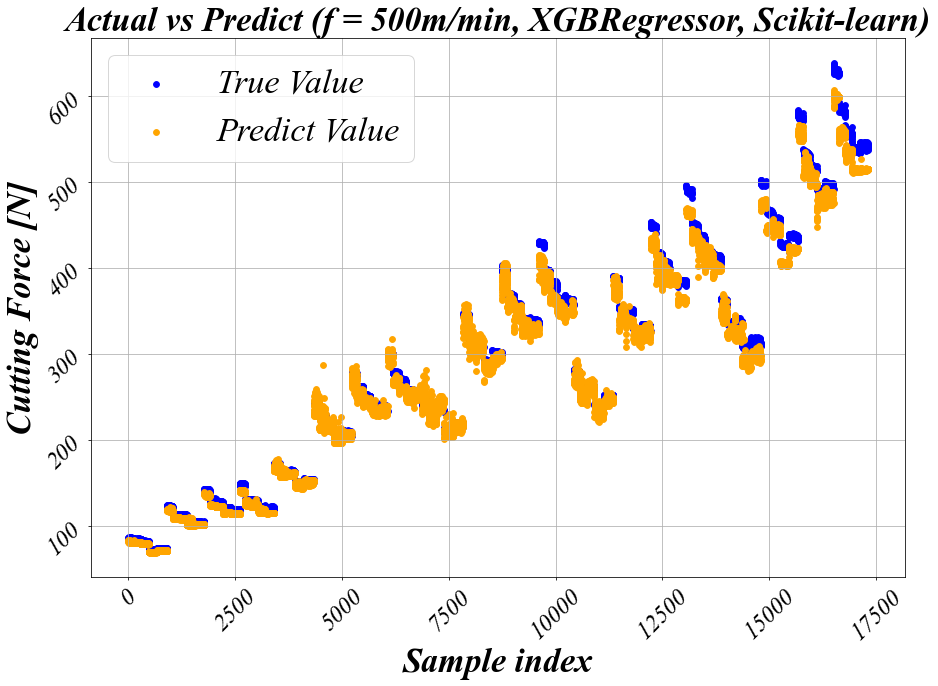

In [150]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 500m/min, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning feed500 cycle.png")

# RPM

In [151]:
rpm_3000 = groups_rpm.get_group(3000)
rpm_3000 = rpm_3000.reset_index(drop=True)
rpm_3000 = rpm_3000.drop(['Milling_Type'], axis=1)

rpm_3500 = groups_rpm.get_group(3500)
rpm_3500 = rpm_3500.reset_index(drop=True)
rpm_3500 = rpm_3500.drop(['Milling_Type'], axis=1)

rpm_4000 = groups_rpm.get_group(4000)
rpm_4000 = rpm_4000.reset_index(drop=True)
rpm_4000 = rpm_4000.drop(['Milling_Type'], axis=1)

rpm_4500 = groups_rpm.get_group(4500)
rpm_4500 = rpm_4500.reset_index(drop=True)
rpm_4500 = rpm_4500.drop(['Milling_Type'], axis=1)

rpm_5000 = groups_rpm.get_group(5000)
rpm_5000 = rpm_5000.reset_index(drop=True)
rpm_5000 = rpm_5000.drop(['Milling_Type'], axis=1)

## rpm 3000

In [152]:
train = pd.concat([rpm_3500, rpm_4000, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [153]:
X_test = rpm_3000.iloc[: , 1:]
y_test = rpm_3000['RMS_CF_max']

In [154]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [155]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:280.67856	validation_0-mape:0.98741	validation_1-rmse:317.90074	validation_1-mape:0.99064
[1]	validation_0-rmse:277.88574	validation_0-mape:0.97750	validation_1-rmse:315.57478	validation_1-mape:0.98365
[2]	validation_0-rmse:275.12095	validation_0-mape:0.96769	validation_1-rmse:313.28650	validation_1-mape:0.97684
[3]	validation_0-rmse:272.38391	validation_0-mape:0.95798	validation_1-rmse:311.03053	validation_1-mape:0.97011
[4]	validation_0-rmse:269.67424	validation_0-mape:0.94836	validation_1-rmse:308.80391	validation_1-mape:0.96348
[5]	validation_0-rmse:266.99178	validation_0-mape:0.93884	validation_1-rmse:306.59758	validation_1-mape:0.95689
[6]	validation_0-rmse:264.33702	validation_0-mape:0.92941	validation_1-rmse:304.40198	validation_1-mape:0.95034
[7]	validation_0-rmse:261.70809	validation_0-mape:0.92008	validation_1-rmse:302.24330	validation_1-mape:0.94390
[8]	validation_0-rmse:259.10643	validation_0-mape:0.91084	validation_1-rmse:300.09746	validation_1-mape:

[73]	validation_0-rmse:135.48063	validation_0-mape:0.47241	validation_1-rmse:201.85169	validation_1-mape:0.63654
[74]	validation_0-rmse:134.13956	validation_0-mape:0.46766	validation_1-rmse:200.87256	validation_1-mape:0.63339
[75]	validation_0-rmse:132.81110	validation_0-mape:0.46296	validation_1-rmse:199.79397	validation_1-mape:0.63002
[76]	validation_0-rmse:131.49744	validation_0-mape:0.45830	validation_1-rmse:198.73838	validation_1-mape:0.62663
[77]	validation_0-rmse:130.19636	validation_0-mape:0.45369	validation_1-rmse:197.80081	validation_1-mape:0.62361
[78]	validation_0-rmse:128.90838	validation_0-mape:0.44912	validation_1-rmse:196.73105	validation_1-mape:0.62022
[79]	validation_0-rmse:127.63340	validation_0-mape:0.44460	validation_1-rmse:195.81131	validation_1-mape:0.61725
[80]	validation_0-rmse:126.37117	validation_0-mape:0.44013	validation_1-rmse:194.88797	validation_1-mape:0.61429
[81]	validation_0-rmse:125.12197	validation_0-mape:0.43569	validation_1-rmse:193.98475	validatio

[146]	validation_0-rmse:65.73064	validation_0-mape:0.22569	validation_1-rmse:150.26203	validation_1-mape:0.46581
[147]	validation_0-rmse:65.08580	validation_0-mape:0.22341	validation_1-rmse:149.78891	validation_1-mape:0.46418
[148]	validation_0-rmse:64.44819	validation_0-mape:0.22116	validation_1-rmse:149.31240	validation_1-mape:0.46257
[149]	validation_0-rmse:63.81680	validation_0-mape:0.21893	validation_1-rmse:148.84843	validation_1-mape:0.46097
[150]	validation_0-rmse:63.19127	validation_0-mape:0.21673	validation_1-rmse:148.38115	validation_1-mape:0.45935
[151]	validation_0-rmse:62.57288	validation_0-mape:0.21454	validation_1-rmse:147.92355	validation_1-mape:0.45779
[152]	validation_0-rmse:61.96055	validation_0-mape:0.21238	validation_1-rmse:147.49402	validation_1-mape:0.45630
[153]	validation_0-rmse:61.35450	validation_0-mape:0.21024	validation_1-rmse:147.07350	validation_1-mape:0.45484
[154]	validation_0-rmse:60.75450	validation_0-mape:0.20812	validation_1-rmse:146.63314	validatio

[219]	validation_0-rmse:32.32374	validation_0-mape:0.10778	validation_1-rmse:125.25951	validation_1-mape:0.37965
[220]	validation_0-rmse:32.01698	validation_0-mape:0.10670	validation_1-rmse:124.97754	validation_1-mape:0.37871
[221]	validation_0-rmse:31.71288	validation_0-mape:0.10563	validation_1-rmse:124.81383	validation_1-mape:0.37805
[222]	validation_0-rmse:31.41308	validation_0-mape:0.10457	validation_1-rmse:124.62205	validation_1-mape:0.37735
[223]	validation_0-rmse:31.11523	validation_0-mape:0.10352	validation_1-rmse:124.39746	validation_1-mape:0.37657
[224]	validation_0-rmse:30.82046	validation_0-mape:0.10248	validation_1-rmse:124.16656	validation_1-mape:0.37578
[225]	validation_0-rmse:30.52859	validation_0-mape:0.10145	validation_1-rmse:123.96870	validation_1-mape:0.37505
[226]	validation_0-rmse:30.23953	validation_0-mape:0.10044	validation_1-rmse:123.77231	validation_1-mape:0.37431
[227]	validation_0-rmse:29.95390	validation_0-mape:0.09943	validation_1-rmse:123.55494	validatio

[292]	validation_0-rmse:16.55369	validation_0-mape:0.05240	validation_1-rmse:113.99421	validation_1-mape:0.33809
[293]	validation_0-rmse:16.41253	validation_0-mape:0.05190	validation_1-rmse:113.86559	validation_1-mape:0.33765
[294]	validation_0-rmse:16.27311	validation_0-mape:0.05141	validation_1-rmse:113.73987	validation_1-mape:0.33721
[295]	validation_0-rmse:16.13401	validation_0-mape:0.05093	validation_1-rmse:113.66608	validation_1-mape:0.33690
[296]	validation_0-rmse:15.99649	validation_0-mape:0.05045	validation_1-rmse:113.59800	validation_1-mape:0.33660
[297]	validation_0-rmse:15.86037	validation_0-mape:0.04998	validation_1-rmse:113.46961	validation_1-mape:0.33615
[298]	validation_0-rmse:15.72701	validation_0-mape:0.04951	validation_1-rmse:113.34395	validation_1-mape:0.33571
[299]	validation_0-rmse:15.59391	validation_0-mape:0.04905	validation_1-rmse:113.27405	validation_1-mape:0.33542
[300]	validation_0-rmse:15.46246	validation_0-mape:0.04860	validation_1-rmse:113.20827	validatio

[365]	validation_0-rmse:9.38460	validation_0-mape:0.02788	validation_1-rmse:108.39491	validation_1-mape:0.31775
[366]	validation_0-rmse:9.32201	validation_0-mape:0.02767	validation_1-rmse:108.31797	validation_1-mape:0.31750
[367]	validation_0-rmse:9.26076	validation_0-mape:0.02747	validation_1-rmse:108.24830	validation_1-mape:0.31730
[368]	validation_0-rmse:9.19980	validation_0-mape:0.02727	validation_1-rmse:108.17842	validation_1-mape:0.31707
[369]	validation_0-rmse:9.13956	validation_0-mape:0.02706	validation_1-rmse:108.09352	validation_1-mape:0.31682
[370]	validation_0-rmse:9.07982	validation_0-mape:0.02687	validation_1-rmse:108.02280	validation_1-mape:0.31659
[371]	validation_0-rmse:9.02104	validation_0-mape:0.02667	validation_1-rmse:107.93652	validation_1-mape:0.31633
[372]	validation_0-rmse:8.96264	validation_0-mape:0.02648	validation_1-rmse:107.84861	validation_1-mape:0.31607
[373]	validation_0-rmse:8.90489	validation_0-mape:0.02628	validation_1-rmse:107.78117	validation_1-mape:

[439]	validation_0-rmse:6.38302	validation_0-mape:0.01800	validation_1-rmse:103.84486	validation_1-mape:0.30388
[440]	validation_0-rmse:6.35927	validation_0-mape:0.01793	validation_1-rmse:103.75506	validation_1-mape:0.30365
[441]	validation_0-rmse:6.33532	validation_0-mape:0.01786	validation_1-rmse:103.70650	validation_1-mape:0.30350
[442]	validation_0-rmse:6.31246	validation_0-mape:0.01778	validation_1-rmse:103.67037	validation_1-mape:0.30339
[443]	validation_0-rmse:6.28918	validation_0-mape:0.01771	validation_1-rmse:103.62458	validation_1-mape:0.30325
[444]	validation_0-rmse:6.26744	validation_0-mape:0.01764	validation_1-rmse:103.58648	validation_1-mape:0.30313
[445]	validation_0-rmse:6.24511	validation_0-mape:0.01757	validation_1-rmse:103.54608	validation_1-mape:0.30299
[446]	validation_0-rmse:6.22271	validation_0-mape:0.01750	validation_1-rmse:103.50067	validation_1-mape:0.30286
[447]	validation_0-rmse:6.20050	validation_0-mape:0.01743	validation_1-rmse:103.45949	validation_1-mape:

[513]	validation_0-rmse:5.23390	validation_0-mape:0.01455	validation_1-rmse:101.39381	validation_1-mape:0.29602
[514]	validation_0-rmse:5.22475	validation_0-mape:0.01452	validation_1-rmse:101.37104	validation_1-mape:0.29598
[515]	validation_0-rmse:5.21407	validation_0-mape:0.01450	validation_1-rmse:101.35238	validation_1-mape:0.29591
[516]	validation_0-rmse:5.20495	validation_0-mape:0.01447	validation_1-rmse:101.32316	validation_1-mape:0.29583
[517]	validation_0-rmse:5.19556	validation_0-mape:0.01444	validation_1-rmse:101.28782	validation_1-mape:0.29575
[518]	validation_0-rmse:5.18469	validation_0-mape:0.01442	validation_1-rmse:101.26870	validation_1-mape:0.29569
[519]	validation_0-rmse:5.17571	validation_0-mape:0.01439	validation_1-rmse:101.24319	validation_1-mape:0.29559
[520]	validation_0-rmse:5.16512	validation_0-mape:0.01437	validation_1-rmse:101.22481	validation_1-mape:0.29554
[521]	validation_0-rmse:5.15593	validation_0-mape:0.01434	validation_1-rmse:101.20839	validation_1-mape:

[587]	validation_0-rmse:4.70711	validation_0-mape:0.01323	validation_1-rmse:99.53213	validation_1-mape:0.28964
[588]	validation_0-rmse:4.70198	validation_0-mape:0.01322	validation_1-rmse:99.51654	validation_1-mape:0.28960
[589]	validation_0-rmse:4.69837	validation_0-mape:0.01321	validation_1-rmse:99.51108	validation_1-mape:0.28955
[590]	validation_0-rmse:4.69365	validation_0-mape:0.01320	validation_1-rmse:99.47549	validation_1-mape:0.28948
[591]	validation_0-rmse:4.68976	validation_0-mape:0.01319	validation_1-rmse:99.46404	validation_1-mape:0.28944
[592]	validation_0-rmse:4.68460	validation_0-mape:0.01318	validation_1-rmse:99.44258	validation_1-mape:0.28939
[593]	validation_0-rmse:4.68000	validation_0-mape:0.01317	validation_1-rmse:99.40957	validation_1-mape:0.28932
[594]	validation_0-rmse:4.67503	validation_0-mape:0.01316	validation_1-rmse:99.38937	validation_1-mape:0.28927
[595]	validation_0-rmse:4.67036	validation_0-mape:0.01315	validation_1-rmse:99.36721	validation_1-mape:0.28922
[

[661]	validation_0-rmse:4.43551	validation_0-mape:0.01260	validation_1-rmse:98.03553	validation_1-mape:0.28445
[662]	validation_0-rmse:4.43323	validation_0-mape:0.01259	validation_1-rmse:98.02522	validation_1-mape:0.28442
[663]	validation_0-rmse:4.43071	validation_0-mape:0.01259	validation_1-rmse:98.00633	validation_1-mape:0.28432
[664]	validation_0-rmse:4.42791	validation_0-mape:0.01258	validation_1-rmse:98.01828	validation_1-mape:0.28436
[665]	validation_0-rmse:4.42540	validation_0-mape:0.01257	validation_1-rmse:97.99587	validation_1-mape:0.28425
[666]	validation_0-rmse:4.42295	validation_0-mape:0.01257	validation_1-rmse:97.98520	validation_1-mape:0.28422
[667]	validation_0-rmse:4.41989	validation_0-mape:0.01256	validation_1-rmse:97.97756	validation_1-mape:0.28419
[668]	validation_0-rmse:4.41733	validation_0-mape:0.01255	validation_1-rmse:97.97602	validation_1-mape:0.28418
[669]	validation_0-rmse:4.41445	validation_0-mape:0.01255	validation_1-rmse:97.98688	validation_1-mape:0.28421
[

[735]	validation_0-rmse:4.24290	validation_0-mape:0.01213	validation_1-rmse:96.75473	validation_1-mape:0.28000
[736]	validation_0-rmse:4.24048	validation_0-mape:0.01212	validation_1-rmse:96.74071	validation_1-mape:0.27991
[737]	validation_0-rmse:4.23800	validation_0-mape:0.01211	validation_1-rmse:96.73605	validation_1-mape:0.27989
[738]	validation_0-rmse:4.23540	validation_0-mape:0.01211	validation_1-rmse:96.69651	validation_1-mape:0.27982
[739]	validation_0-rmse:4.23282	validation_0-mape:0.01210	validation_1-rmse:96.66968	validation_1-mape:0.27978
[740]	validation_0-rmse:4.23105	validation_0-mape:0.01210	validation_1-rmse:96.65750	validation_1-mape:0.27976
[741]	validation_0-rmse:4.22817	validation_0-mape:0.01209	validation_1-rmse:96.64247	validation_1-mape:0.27966
[742]	validation_0-rmse:4.22556	validation_0-mape:0.01209	validation_1-rmse:96.60399	validation_1-mape:0.27959
[743]	validation_0-rmse:4.22301	validation_0-mape:0.01208	validation_1-rmse:96.57593	validation_1-mape:0.27954
[

[809]	validation_0-rmse:4.07511	validation_0-mape:0.01171	validation_1-rmse:96.03853	validation_1-mape:0.27779
[810]	validation_0-rmse:4.07284	validation_0-mape:0.01170	validation_1-rmse:96.03114	validation_1-mape:0.27771
[811]	validation_0-rmse:4.07130	validation_0-mape:0.01170	validation_1-rmse:96.03217	validation_1-mape:0.27771
[812]	validation_0-rmse:4.06939	validation_0-mape:0.01169	validation_1-rmse:96.02903	validation_1-mape:0.27770
[813]	validation_0-rmse:4.06707	validation_0-mape:0.01169	validation_1-rmse:96.02586	validation_1-mape:0.27770
[814]	validation_0-rmse:4.06527	validation_0-mape:0.01168	validation_1-rmse:96.01303	validation_1-mape:0.27767
[815]	validation_0-rmse:4.06348	validation_0-mape:0.01168	validation_1-rmse:96.01168	validation_1-mape:0.27767
[816]	validation_0-rmse:4.06177	validation_0-mape:0.01167	validation_1-rmse:96.01056	validation_1-mape:0.27766
[817]	validation_0-rmse:4.05931	validation_0-mape:0.01167	validation_1-rmse:96.00526	validation_1-mape:0.27763
[

[883]	validation_0-rmse:3.94139	validation_0-mape:0.01136	validation_1-rmse:95.67792	validation_1-mape:0.27646
[884]	validation_0-rmse:3.94009	validation_0-mape:0.01136	validation_1-rmse:95.67343	validation_1-mape:0.27644
[885]	validation_0-rmse:3.93863	validation_0-mape:0.01135	validation_1-rmse:95.66288	validation_1-mape:0.27640
[886]	validation_0-rmse:3.93635	validation_0-mape:0.01135	validation_1-rmse:95.66256	validation_1-mape:0.27640
[887]	validation_0-rmse:3.93482	validation_0-mape:0.01135	validation_1-rmse:95.65654	validation_1-mape:0.27638
[888]	validation_0-rmse:3.93316	validation_0-mape:0.01134	validation_1-rmse:95.65198	validation_1-mape:0.27637
[889]	validation_0-rmse:3.93178	validation_0-mape:0.01134	validation_1-rmse:95.64343	validation_1-mape:0.27634
[890]	validation_0-rmse:3.93050	validation_0-mape:0.01133	validation_1-rmse:95.63762	validation_1-mape:0.27631
[891]	validation_0-rmse:3.92876	validation_0-mape:0.01133	validation_1-rmse:95.62254	validation_1-mape:0.27626
[

[957]	validation_0-rmse:3.81726	validation_0-mape:0.01103	validation_1-rmse:95.25219	validation_1-mape:0.27495
[958]	validation_0-rmse:3.81597	validation_0-mape:0.01103	validation_1-rmse:95.24994	validation_1-mape:0.27495
[959]	validation_0-rmse:3.81420	validation_0-mape:0.01102	validation_1-rmse:95.23752	validation_1-mape:0.27492
[960]	validation_0-rmse:3.81284	validation_0-mape:0.01102	validation_1-rmse:95.24076	validation_1-mape:0.27492
[961]	validation_0-rmse:3.81098	validation_0-mape:0.01102	validation_1-rmse:95.23114	validation_1-mape:0.27485
[962]	validation_0-rmse:3.80923	validation_0-mape:0.01101	validation_1-rmse:95.22144	validation_1-mape:0.27479
[963]	validation_0-rmse:3.80681	validation_0-mape:0.01101	validation_1-rmse:95.20351	validation_1-mape:0.27473
[964]	validation_0-rmse:3.80493	validation_0-mape:0.01100	validation_1-rmse:95.20312	validation_1-mape:0.27472
[965]	validation_0-rmse:3.80361	validation_0-mape:0.01100	validation_1-rmse:95.20124	validation_1-mape:0.27472
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [156]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 3.7514
Train MAPE: 1.0867
Test RMSE: 94.9358
Test MAPE: 27.3712


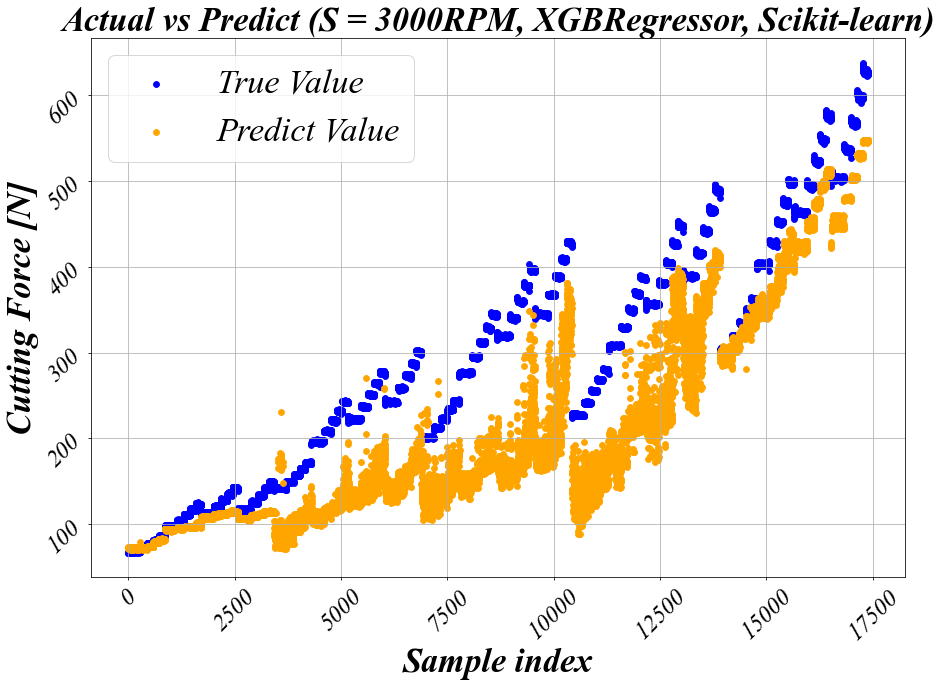

In [157]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 3000RPM, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning rpm3000 cycle.png")

## rpm 3500

In [158]:
train = pd.concat([rpm_3000, rpm_4000, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [159]:
X_test = rpm_3500.iloc[: , 1:]
y_test = rpm_3500['RMS_CF_max']

In [160]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [161]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 360,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:284.50998	validation_0-mape:0.98741	validation_1-rmse:295.47129	validation_1-mape:0.98666
[1]	validation_0-rmse:281.68649	validation_0-mape:0.97747	validation_1-rmse:292.28783	validation_1-mape:0.97599
[2]	validation_0-rmse:278.88925	validation_0-mape:0.96764	validation_1-rmse:289.08621	validation_1-mape:0.96522
[3]	validation_0-rmse:276.12255	validation_0-mape:0.95790	validation_1-rmse:285.95162	validation_1-mape:0.95472
[4]	validation_0-rmse:273.38080	validation_0-mape:0.94826	validation_1-rmse:282.81421	validation_1-mape:0.94415
[5]	validation_0-rmse:270.66828	validation_0-mape:0.93872	validation_1-rmse:279.73113	validation_1-mape:0.93377
[6]	validation_0-rmse:267.98357	validation_0-mape:0.92926	validation_1-rmse:276.66824	validation_1-mape:0.92345
[7]	validation_0-rmse:265.31854	validation_0-mape:0.91994	validation_1-rmse:273.60458	validation_1-mape:0.91349
[8]	validation_0-rmse:262.68496	validation_0-mape:0.91069	validation_1-rmse:270.61441	validation_1-mape:

[73]	validation_0-rmse:137.42463	validation_0-mape:0.47225	validation_1-rmse:126.73260	validation_1-mape:0.43256
[74]	validation_0-rmse:136.06533	validation_0-mape:0.46750	validation_1-rmse:125.16649	validation_1-mape:0.42733
[75]	validation_0-rmse:134.72056	validation_0-mape:0.46278	validation_1-rmse:123.75297	validation_1-mape:0.42262
[76]	validation_0-rmse:133.38818	validation_0-mape:0.45813	validation_1-rmse:122.15138	validation_1-mape:0.41738
[77]	validation_0-rmse:132.06865	validation_0-mape:0.45352	validation_1-rmse:120.56878	validation_1-mape:0.41222
[78]	validation_0-rmse:130.76501	validation_0-mape:0.44895	validation_1-rmse:119.10352	validation_1-mape:0.40733
[79]	validation_0-rmse:129.47219	validation_0-mape:0.44443	validation_1-rmse:117.62310	validation_1-mape:0.40241
[80]	validation_0-rmse:128.19015	validation_0-mape:0.43996	validation_1-rmse:116.31936	validation_1-mape:0.39800
[81]	validation_0-rmse:126.92536	validation_0-mape:0.43552	validation_1-rmse:114.95894	validatio

[146]	validation_0-rmse:66.70944	validation_0-mape:0.22547	validation_1-rmse:50.51890	validation_1-mape:0.16940
[147]	validation_0-rmse:66.05731	validation_0-mape:0.22319	validation_1-rmse:49.90557	validation_1-mape:0.16721
[148]	validation_0-rmse:65.40991	validation_0-mape:0.22094	validation_1-rmse:49.23555	validation_1-mape:0.16492
[149]	validation_0-rmse:64.76881	validation_0-mape:0.21871	validation_1-rmse:48.59637	validation_1-mape:0.16273
[150]	validation_0-rmse:64.13452	validation_0-mape:0.21651	validation_1-rmse:47.99897	validation_1-mape:0.16058
[151]	validation_0-rmse:63.50731	validation_0-mape:0.21433	validation_1-rmse:47.34973	validation_1-mape:0.15844
[152]	validation_0-rmse:62.88577	validation_0-mape:0.21216	validation_1-rmse:46.77893	validation_1-mape:0.15641
[153]	validation_0-rmse:62.27253	validation_0-mape:0.21002	validation_1-rmse:46.20936	validation_1-mape:0.15436
[154]	validation_0-rmse:61.66308	validation_0-mape:0.20790	validation_1-rmse:45.63923	validation_1-mape:

[220]	validation_0-rmse:32.40373	validation_0-mape:0.10657	validation_1-rmse:25.15675	validation_1-mape:0.08170
[221]	validation_0-rmse:32.09304	validation_0-mape:0.10550	validation_1-rmse:25.07076	validation_1-mape:0.08126
[222]	validation_0-rmse:31.78539	validation_0-mape:0.10444	validation_1-rmse:24.99595	validation_1-mape:0.08084
[223]	validation_0-rmse:31.48097	validation_0-mape:0.10339	validation_1-rmse:24.91799	validation_1-mape:0.08042
[224]	validation_0-rmse:31.17957	validation_0-mape:0.10235	validation_1-rmse:24.85770	validation_1-mape:0.08004
[225]	validation_0-rmse:30.88091	validation_0-mape:0.10132	validation_1-rmse:24.79916	validation_1-mape:0.07966
[226]	validation_0-rmse:30.58579	validation_0-mape:0.10031	validation_1-rmse:24.73673	validation_1-mape:0.07928
[227]	validation_0-rmse:30.29331	validation_0-mape:0.09930	validation_1-rmse:24.68567	validation_1-mape:0.07892
[228]	validation_0-rmse:30.00428	validation_0-mape:0.09830	validation_1-rmse:24.63149	validation_1-mape:

[294]	validation_0-rmse:16.24387	validation_0-mape:0.05065	validation_1-rmse:26.71668	validation_1-mape:0.06987
[295]	validation_0-rmse:16.09885	validation_0-mape:0.05014	validation_1-rmse:26.79242	validation_1-mape:0.06990
[296]	validation_0-rmse:15.95529	validation_0-mape:0.04965	validation_1-rmse:26.86344	validation_1-mape:0.06993
[297]	validation_0-rmse:15.81454	validation_0-mape:0.04916	validation_1-rmse:26.91712	validation_1-mape:0.06993
[298]	validation_0-rmse:15.67420	validation_0-mape:0.04867	validation_1-rmse:26.99672	validation_1-mape:0.06997
[299]	validation_0-rmse:15.53499	validation_0-mape:0.04819	validation_1-rmse:27.07572	validation_1-mape:0.07002
[300]	validation_0-rmse:15.39784	validation_0-mape:0.04771	validation_1-rmse:27.14895	validation_1-mape:0.07007
[301]	validation_0-rmse:15.26183	validation_0-mape:0.04724	validation_1-rmse:27.22165	validation_1-mape:0.07011
[302]	validation_0-rmse:15.12822	validation_0-mape:0.04678	validation_1-rmse:27.28760	validation_1-mape:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=360, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [162]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 9.4935
Train MAPE: 2.7249
Test RMSE: 31.0447
Test MAPE: 7.5004


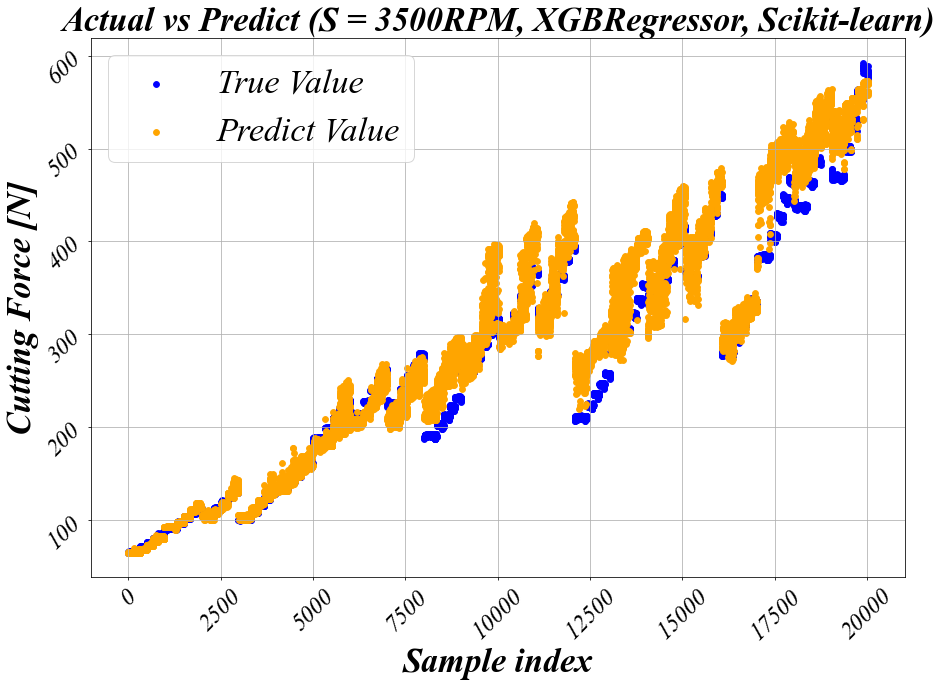

In [163]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 3500RPM, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning rpm3500 cycle.png")

## rpm 4000

In [164]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [165]:
X_test = rpm_4000.iloc[: , 1:]
y_test = rpm_4000['RMS_CF_max']

In [166]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [167]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:286.12061	validation_0-mape:0.98743	validation_1-rmse:288.04132	validation_1-mape:0.98761
[1]	validation_0-rmse:283.27801	validation_0-mape:0.97750	validation_1-rmse:285.19089	validation_1-mape:0.97777
[2]	validation_0-rmse:280.46417	validation_0-mape:0.96767	validation_1-rmse:282.37131	validation_1-mape:0.96804
[3]	validation_0-rmse:277.67874	validation_0-mape:0.95794	validation_1-rmse:279.55264	validation_1-mape:0.95827
[4]	validation_0-rmse:274.92147	validation_0-mape:0.94831	validation_1-rmse:276.76355	validation_1-mape:0.94864
[5]	validation_0-rmse:272.18846	validation_0-mape:0.93878	validation_1-rmse:273.99567	validation_1-mape:0.93905
[6]	validation_0-rmse:269.48620	validation_0-mape:0.92934	validation_1-rmse:271.25637	validation_1-mape:0.92953
[7]	validation_0-rmse:266.80772	validation_0-mape:0.92001	validation_1-rmse:268.55844	validation_1-mape:0.92018
[8]	validation_0-rmse:264.15939	validation_0-mape:0.91075	validation_1-rmse:265.84918	validation_1-mape:

[73]	validation_0-rmse:138.30407	validation_0-mape:0.47184	validation_1-rmse:140.53597	validation_1-mape:0.47749
[74]	validation_0-rmse:136.93909	validation_0-mape:0.46708	validation_1-rmse:139.29061	validation_1-mape:0.47300
[75]	validation_0-rmse:135.58674	validation_0-mape:0.46237	validation_1-rmse:137.96124	validation_1-mape:0.46833
[76]	validation_0-rmse:134.24839	validation_0-mape:0.45771	validation_1-rmse:136.66758	validation_1-mape:0.46373
[77]	validation_0-rmse:132.92357	validation_0-mape:0.45309	validation_1-rmse:135.50683	validation_1-mape:0.45940
[78]	validation_0-rmse:131.61163	validation_0-mape:0.44852	validation_1-rmse:134.24105	validation_1-mape:0.45491
[79]	validation_0-rmse:130.31290	validation_0-mape:0.44399	validation_1-rmse:133.10494	validation_1-mape:0.45069
[80]	validation_0-rmse:129.02732	validation_0-mape:0.43952	validation_1-rmse:131.84281	validation_1-mape:0.44622
[81]	validation_0-rmse:127.75429	validation_0-mape:0.43508	validation_1-rmse:130.61332	validatio

[146]	validation_0-rmse:67.17892	validation_0-mape:0.22532	validation_1-rmse:74.79765	validation_1-mape:0.24025
[147]	validation_0-rmse:66.52243	validation_0-mape:0.22305	validation_1-rmse:74.16057	validation_1-mape:0.23806
[148]	validation_0-rmse:65.87136	validation_0-mape:0.22080	validation_1-rmse:73.62301	validation_1-mape:0.23603
[149]	validation_0-rmse:65.22805	validation_0-mape:0.21857	validation_1-rmse:72.99945	validation_1-mape:0.23389
[150]	validation_0-rmse:64.58980	validation_0-mape:0.21637	validation_1-rmse:72.44414	validation_1-mape:0.23180
[151]	validation_0-rmse:63.95897	validation_0-mape:0.21419	validation_1-rmse:71.84933	validation_1-mape:0.22969
[152]	validation_0-rmse:63.33398	validation_0-mape:0.21204	validation_1-rmse:71.25548	validation_1-mape:0.22754
[153]	validation_0-rmse:62.71569	validation_0-mape:0.20990	validation_1-rmse:70.67523	validation_1-mape:0.22542
[154]	validation_0-rmse:62.10293	validation_0-mape:0.20779	validation_1-rmse:70.14282	validation_1-mape:

[220]	validation_0-rmse:32.72808	validation_0-mape:0.10669	validation_1-rmse:42.34937	validation_1-mape:0.12450
[221]	validation_0-rmse:32.41713	validation_0-mape:0.10562	validation_1-rmse:42.05587	validation_1-mape:0.12348
[222]	validation_0-rmse:32.10951	validation_0-mape:0.10456	validation_1-rmse:41.76536	validation_1-mape:0.12247
[223]	validation_0-rmse:31.80499	validation_0-mape:0.10351	validation_1-rmse:41.48213	validation_1-mape:0.12151
[224]	validation_0-rmse:31.50376	validation_0-mape:0.10247	validation_1-rmse:41.20077	validation_1-mape:0.12055
[225]	validation_0-rmse:31.20550	validation_0-mape:0.10145	validation_1-rmse:40.92009	validation_1-mape:0.11957
[226]	validation_0-rmse:30.91027	validation_0-mape:0.10043	validation_1-rmse:40.63397	validation_1-mape:0.11860
[227]	validation_0-rmse:30.61802	validation_0-mape:0.09943	validation_1-rmse:40.35748	validation_1-mape:0.11766
[228]	validation_0-rmse:30.32876	validation_0-mape:0.09843	validation_1-rmse:40.06624	validation_1-mape:

[294]	validation_0-rmse:16.64365	validation_0-mape:0.05111	validation_1-rmse:27.23516	validation_1-mape:0.07429
[295]	validation_0-rmse:16.50185	validation_0-mape:0.05062	validation_1-rmse:27.11259	validation_1-mape:0.07390
[296]	validation_0-rmse:16.36141	validation_0-mape:0.05014	validation_1-rmse:26.99032	validation_1-mape:0.07351
[297]	validation_0-rmse:16.22270	validation_0-mape:0.04966	validation_1-rmse:26.87448	validation_1-mape:0.07314
[298]	validation_0-rmse:16.08553	validation_0-mape:0.04918	validation_1-rmse:26.74336	validation_1-mape:0.07274
[299]	validation_0-rmse:15.94963	validation_0-mape:0.04871	validation_1-rmse:26.61628	validation_1-mape:0.07237
[300]	validation_0-rmse:15.81551	validation_0-mape:0.04824	validation_1-rmse:26.49624	validation_1-mape:0.07198
[301]	validation_0-rmse:15.68303	validation_0-mape:0.04778	validation_1-rmse:26.37875	validation_1-mape:0.07162
[302]	validation_0-rmse:15.55184	validation_0-mape:0.04733	validation_1-rmse:26.26371	validation_1-mape:

[368]	validation_0-rmse:9.44325	validation_0-mape:0.02628	validation_1-rmse:21.08942	validation_1-mape:0.05602
[369]	validation_0-rmse:9.38304	validation_0-mape:0.02607	validation_1-rmse:21.03598	validation_1-mape:0.05587
[370]	validation_0-rmse:9.32272	validation_0-mape:0.02587	validation_1-rmse:20.98487	validation_1-mape:0.05571
[371]	validation_0-rmse:9.26375	validation_0-mape:0.02566	validation_1-rmse:20.93460	validation_1-mape:0.05556
[372]	validation_0-rmse:9.20548	validation_0-mape:0.02546	validation_1-rmse:20.88738	validation_1-mape:0.05543
[373]	validation_0-rmse:9.14814	validation_0-mape:0.02527	validation_1-rmse:20.84231	validation_1-mape:0.05530
[374]	validation_0-rmse:9.09075	validation_0-mape:0.02507	validation_1-rmse:20.79327	validation_1-mape:0.05514
[375]	validation_0-rmse:9.03417	validation_0-mape:0.02488	validation_1-rmse:20.74954	validation_1-mape:0.05501
[376]	validation_0-rmse:8.97925	validation_0-mape:0.02470	validation_1-rmse:20.70393	validation_1-mape:0.05489
[

[442]	validation_0-rmse:6.53048	validation_0-mape:0.01668	validation_1-rmse:18.66431	validation_1-mape:0.04907
[443]	validation_0-rmse:6.50686	validation_0-mape:0.01661	validation_1-rmse:18.64418	validation_1-mape:0.04900
[444]	validation_0-rmse:6.48435	validation_0-mape:0.01654	validation_1-rmse:18.61919	validation_1-mape:0.04894
[445]	validation_0-rmse:6.46209	validation_0-mape:0.01647	validation_1-rmse:18.59196	validation_1-mape:0.04888
[446]	validation_0-rmse:6.43963	validation_0-mape:0.01640	validation_1-rmse:18.57215	validation_1-mape:0.04881
[447]	validation_0-rmse:6.41823	validation_0-mape:0.01633	validation_1-rmse:18.55127	validation_1-mape:0.04875
[448]	validation_0-rmse:6.39664	validation_0-mape:0.01627	validation_1-rmse:18.53156	validation_1-mape:0.04869
[449]	validation_0-rmse:6.37510	validation_0-mape:0.01620	validation_1-rmse:18.51449	validation_1-mape:0.04865
[450]	validation_0-rmse:6.35437	validation_0-mape:0.01613	validation_1-rmse:18.49594	validation_1-mape:0.04859
[

[516]	validation_0-rmse:5.39189	validation_0-mape:0.01344	validation_1-rmse:17.35607	validation_1-mape:0.04523
[517]	validation_0-rmse:5.38262	validation_0-mape:0.01341	validation_1-rmse:17.34440	validation_1-mape:0.04520
[518]	validation_0-rmse:5.37241	validation_0-mape:0.01339	validation_1-rmse:17.33524	validation_1-mape:0.04516
[519]	validation_0-rmse:5.36386	validation_0-mape:0.01336	validation_1-rmse:17.32285	validation_1-mape:0.04512
[520]	validation_0-rmse:5.35405	validation_0-mape:0.01334	validation_1-rmse:17.30814	validation_1-mape:0.04507
[521]	validation_0-rmse:5.34452	validation_0-mape:0.01332	validation_1-rmse:17.29413	validation_1-mape:0.04502
[522]	validation_0-rmse:5.33573	validation_0-mape:0.01329	validation_1-rmse:17.28113	validation_1-mape:0.04497
[523]	validation_0-rmse:5.32728	validation_0-mape:0.01327	validation_1-rmse:17.27047	validation_1-mape:0.04494
[524]	validation_0-rmse:5.31816	validation_0-mape:0.01325	validation_1-rmse:17.25553	validation_1-mape:0.04488
[

[590]	validation_0-rmse:4.88743	validation_0-mape:0.01229	validation_1-rmse:16.68728	validation_1-mape:0.04289
[591]	validation_0-rmse:4.88326	validation_0-mape:0.01228	validation_1-rmse:16.68022	validation_1-mape:0.04287
[592]	validation_0-rmse:4.87869	validation_0-mape:0.01227	validation_1-rmse:16.67595	validation_1-mape:0.04286
[593]	validation_0-rmse:4.87426	validation_0-mape:0.01226	validation_1-rmse:16.67222	validation_1-mape:0.04286
[594]	validation_0-rmse:4.87006	validation_0-mape:0.01225	validation_1-rmse:16.66759	validation_1-mape:0.04285
[595]	validation_0-rmse:4.86469	validation_0-mape:0.01224	validation_1-rmse:16.65949	validation_1-mape:0.04282
[596]	validation_0-rmse:4.86024	validation_0-mape:0.01224	validation_1-rmse:16.65092	validation_1-mape:0.04280
[597]	validation_0-rmse:4.85599	validation_0-mape:0.01223	validation_1-rmse:16.64536	validation_1-mape:0.04278
[598]	validation_0-rmse:4.85179	validation_0-mape:0.01222	validation_1-rmse:16.64178	validation_1-mape:0.04278
[

[664]	validation_0-rmse:4.61796	validation_0-mape:0.01176	validation_1-rmse:16.36039	validation_1-mape:0.04179
[665]	validation_0-rmse:4.61540	validation_0-mape:0.01175	validation_1-rmse:16.35564	validation_1-mape:0.04178
[666]	validation_0-rmse:4.61237	validation_0-mape:0.01175	validation_1-rmse:16.34672	validation_1-mape:0.04176
[667]	validation_0-rmse:4.60918	validation_0-mape:0.01174	validation_1-rmse:16.33435	validation_1-mape:0.04173
[668]	validation_0-rmse:4.60564	validation_0-mape:0.01173	validation_1-rmse:16.32891	validation_1-mape:0.04172
[669]	validation_0-rmse:4.60295	validation_0-mape:0.01173	validation_1-rmse:16.32312	validation_1-mape:0.04170
[670]	validation_0-rmse:4.59987	validation_0-mape:0.01172	validation_1-rmse:16.31590	validation_1-mape:0.04168
[671]	validation_0-rmse:4.59643	validation_0-mape:0.01171	validation_1-rmse:16.31002	validation_1-mape:0.04166
[672]	validation_0-rmse:4.59397	validation_0-mape:0.01171	validation_1-rmse:16.30637	validation_1-mape:0.04165
[

[738]	validation_0-rmse:4.43367	validation_0-mape:0.01137	validation_1-rmse:16.09478	validation_1-mape:0.04096
[739]	validation_0-rmse:4.43129	validation_0-mape:0.01136	validation_1-rmse:16.08960	validation_1-mape:0.04096
[740]	validation_0-rmse:4.42900	validation_0-mape:0.01136	validation_1-rmse:16.08526	validation_1-mape:0.04094
[741]	validation_0-rmse:4.42720	validation_0-mape:0.01136	validation_1-rmse:16.08379	validation_1-mape:0.04094
[742]	validation_0-rmse:4.42493	validation_0-mape:0.01135	validation_1-rmse:16.07862	validation_1-mape:0.04093
[743]	validation_0-rmse:4.42244	validation_0-mape:0.01135	validation_1-rmse:16.07878	validation_1-mape:0.04093
[744]	validation_0-rmse:4.42003	validation_0-mape:0.01134	validation_1-rmse:16.07997	validation_1-mape:0.04094
[745]	validation_0-rmse:4.41821	validation_0-mape:0.01134	validation_1-rmse:16.07837	validation_1-mape:0.04093
[746]	validation_0-rmse:4.41597	validation_0-mape:0.01133	validation_1-rmse:16.07331	validation_1-mape:0.04093
[

[812]	validation_0-rmse:4.28452	validation_0-mape:0.01106	validation_1-rmse:15.96632	validation_1-mape:0.04068
[813]	validation_0-rmse:4.28307	validation_0-mape:0.01106	validation_1-rmse:15.96614	validation_1-mape:0.04068
[814]	validation_0-rmse:4.28069	validation_0-mape:0.01105	validation_1-rmse:15.96425	validation_1-mape:0.04068
[815]	validation_0-rmse:4.27877	validation_0-mape:0.01105	validation_1-rmse:15.96236	validation_1-mape:0.04067
[816]	validation_0-rmse:4.27695	validation_0-mape:0.01105	validation_1-rmse:15.96485	validation_1-mape:0.04068
[817]	validation_0-rmse:4.27415	validation_0-mape:0.01104	validation_1-rmse:15.95811	validation_1-mape:0.04066
[818]	validation_0-rmse:4.27270	validation_0-mape:0.01104	validation_1-rmse:15.95735	validation_1-mape:0.04066
[819]	validation_0-rmse:4.27020	validation_0-mape:0.01103	validation_1-rmse:15.95495	validation_1-mape:0.04066
[820]	validation_0-rmse:4.26786	validation_0-mape:0.01102	validation_1-rmse:15.95362	validation_1-mape:0.04065
[

[886]	validation_0-rmse:4.14399	validation_0-mape:0.01076	validation_1-rmse:15.86602	validation_1-mape:0.04038
[887]	validation_0-rmse:4.14191	validation_0-mape:0.01076	validation_1-rmse:15.86747	validation_1-mape:0.04040
[888]	validation_0-rmse:4.14038	validation_0-mape:0.01076	validation_1-rmse:15.86638	validation_1-mape:0.04039
[889]	validation_0-rmse:4.13963	validation_0-mape:0.01075	validation_1-rmse:15.86625	validation_1-mape:0.04040
[890]	validation_0-rmse:4.13810	validation_0-mape:0.01075	validation_1-rmse:15.86920	validation_1-mape:0.04041
[891]	validation_0-rmse:4.13634	validation_0-mape:0.01075	validation_1-rmse:15.86871	validation_1-mape:0.04041
[892]	validation_0-rmse:4.13433	validation_0-mape:0.01074	validation_1-rmse:15.86883	validation_1-mape:0.04042
[893]	validation_0-rmse:4.13277	validation_0-mape:0.01074	validation_1-rmse:15.86712	validation_1-mape:0.04041
[894]	validation_0-rmse:4.13100	validation_0-mape:0.01073	validation_1-rmse:15.86879	validation_1-mape:0.04042
[

[960]	validation_0-rmse:4.02182	validation_0-mape:0.01049	validation_1-rmse:15.77757	validation_1-mape:0.04011
[961]	validation_0-rmse:4.01971	validation_0-mape:0.01049	validation_1-rmse:15.77612	validation_1-mape:0.04011
[962]	validation_0-rmse:4.01794	validation_0-mape:0.01048	validation_1-rmse:15.77349	validation_1-mape:0.04008
[963]	validation_0-rmse:4.01646	validation_0-mape:0.01048	validation_1-rmse:15.76099	validation_1-mape:0.04006
[964]	validation_0-rmse:4.01516	validation_0-mape:0.01048	validation_1-rmse:15.75912	validation_1-mape:0.04005
[965]	validation_0-rmse:4.01375	validation_0-mape:0.01048	validation_1-rmse:15.75559	validation_1-mape:0.04004
[966]	validation_0-rmse:4.01269	validation_0-mape:0.01047	validation_1-rmse:15.75515	validation_1-mape:0.04004
[967]	validation_0-rmse:4.01094	validation_0-mape:0.01047	validation_1-rmse:15.75244	validation_1-mape:0.04002
[968]	validation_0-rmse:4.00946	validation_0-mape:0.01047	validation_1-rmse:15.75130	validation_1-mape:0.04002
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [168]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 3.9632
Train MAPE: 1.0366
Test RMSE: 15.6736
Test MAPE: 3.9818


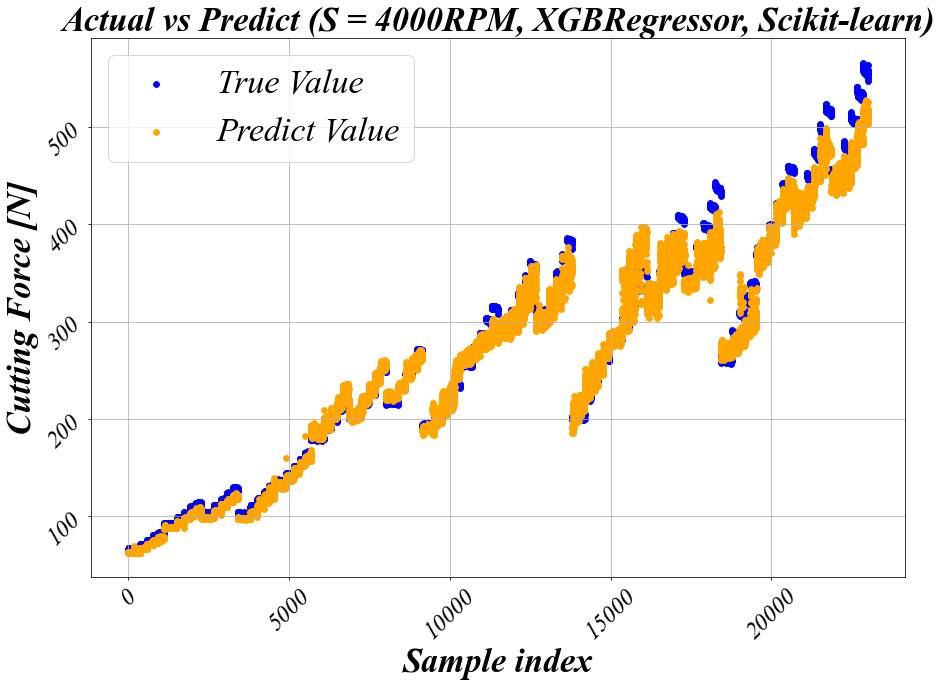

In [169]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 4000RPM, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning rpm4000 cycle.png")

## rpm 4500

In [170]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4000, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [171]:
X_test = rpm_4500.iloc[: , 1:]
y_test = rpm_4500['RMS_CF_max']

In [172]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [173]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 200,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:290.32507	validation_0-mape:0.98748	validation_1-rmse:272.49846	validation_1-mape:0.98599
[1]	validation_0-rmse:287.43759	validation_0-mape:0.97756	validation_1-rmse:269.34819	validation_1-mape:0.97477
[2]	validation_0-rmse:284.57909	validation_0-mape:0.96775	validation_1-rmse:266.22202	validation_1-mape:0.96365
[3]	validation_0-rmse:281.74921	validation_0-mape:0.95803	validation_1-rmse:263.12863	validation_1-mape:0.95265
[4]	validation_0-rmse:278.94794	validation_0-mape:0.94841	validation_1-rmse:260.02107	validation_1-mape:0.94157
[5]	validation_0-rmse:276.17470	validation_0-mape:0.93888	validation_1-rmse:257.05546	validation_1-mape:0.93108
[6]	validation_0-rmse:273.42913	validation_0-mape:0.92945	validation_1-rmse:254.03176	validation_1-mape:0.92028
[7]	validation_0-rmse:270.71100	validation_0-mape:0.92012	validation_1-rmse:251.02056	validation_1-mape:0.90955
[8]	validation_0-rmse:268.02041	validation_0-mape:0.91088	validation_1-rmse:248.05505	validation_1-mape:

[73]	validation_0-rmse:140.14899	validation_0-mape:0.47235	validation_1-rmse:109.00889	validation_1-mape:0.40252
[74]	validation_0-rmse:138.75993	validation_0-mape:0.46761	validation_1-rmse:107.49450	validation_1-mape:0.39727
[75]	validation_0-rmse:137.38523	validation_0-mape:0.46291	validation_1-rmse:106.01519	validation_1-mape:0.39209
[76]	validation_0-rmse:136.02606	validation_0-mape:0.45824	validation_1-rmse:104.54559	validation_1-mape:0.38664
[77]	validation_0-rmse:134.67831	validation_0-mape:0.45364	validation_1-rmse:103.09695	validation_1-mape:0.38148
[78]	validation_0-rmse:133.34639	validation_0-mape:0.44907	validation_1-rmse:101.66502	validation_1-mape:0.37618
[79]	validation_0-rmse:132.02552	validation_0-mape:0.44456	validation_1-rmse:100.21814	validation_1-mape:0.37116
[80]	validation_0-rmse:130.71798	validation_0-mape:0.44009	validation_1-rmse:98.81537	validation_1-mape:0.36624
[81]	validation_0-rmse:129.42534	validation_0-mape:0.43565	validation_1-rmse:97.42684	validation_

[147]	validation_0-rmse:67.30437	validation_0-mape:0.22337	validation_1-rmse:34.75690	validation_1-mape:0.13005
[148]	validation_0-rmse:66.64330	validation_0-mape:0.22112	validation_1-rmse:34.21780	validation_1-mape:0.12811
[149]	validation_0-rmse:65.98937	validation_0-mape:0.21889	validation_1-rmse:33.70680	validation_1-mape:0.12629
[150]	validation_0-rmse:65.34329	validation_0-mape:0.21669	validation_1-rmse:33.16139	validation_1-mape:0.12431
[151]	validation_0-rmse:64.70476	validation_0-mape:0.21450	validation_1-rmse:32.67361	validation_1-mape:0.12254
[152]	validation_0-rmse:64.06963	validation_0-mape:0.21234	validation_1-rmse:32.19870	validation_1-mape:0.12080
[153]	validation_0-rmse:63.44265	validation_0-mape:0.21020	validation_1-rmse:31.70135	validation_1-mape:0.11896
[154]	validation_0-rmse:62.82082	validation_0-mape:0.20808	validation_1-rmse:31.25130	validation_1-mape:0.11730
[155]	validation_0-rmse:62.20706	validation_0-mape:0.20598	validation_1-rmse:30.82438	validation_1-mape:

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [174]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 40.4705
Train MAPE: 13.1946
Test RMSE: 24.2117
Test MAPE: 7.5077


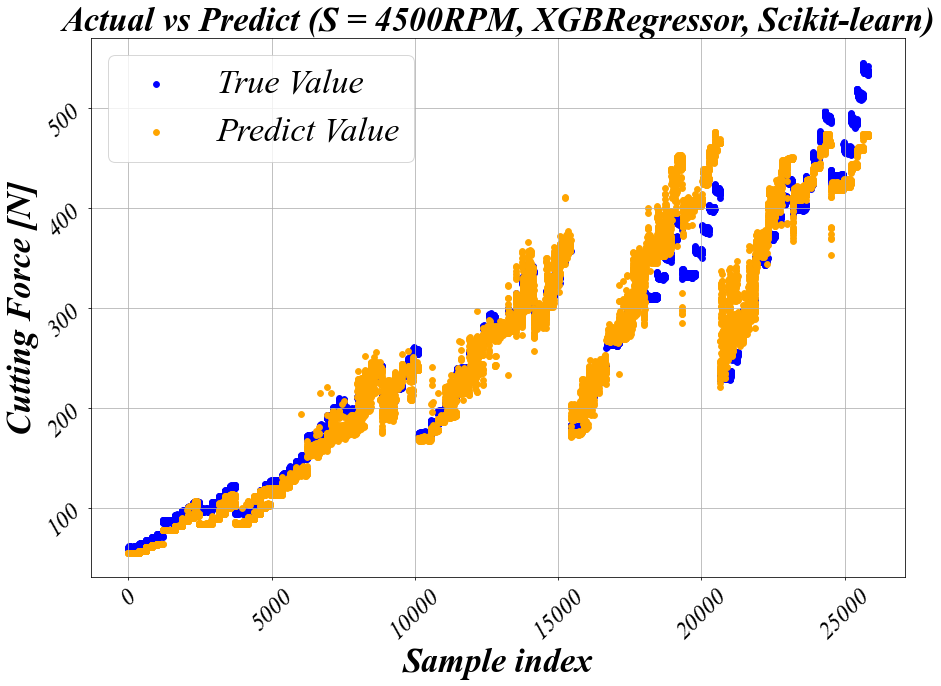

In [175]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 4500RPM, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning rpm4500 cycle.png")

## rpm 5000

In [176]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4000, rpm_4500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [177]:
X_test = rpm_5000.iloc[: , 1:]
y_test = rpm_5000['RMS_CF_max']

In [178]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [179]:
xgb = XGBRegressor(learning_rate = 0.01,
                   n_estimators = 1000,
                   n_jobs  = -1,random_state=42)

eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)] # 학습에 사용한 데이터셋과 검증에 사용한 데이터셋

xgb.fit(X_train_scaled, y_train,eval_set=eval_set, eval_metric=['rmse', 'mape'])

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:291.57327	validation_0-mape:0.98750	validation_1-rmse:271.11526	validation_1-mape:0.98837
[1]	validation_0-rmse:288.67329	validation_0-mape:0.97758	validation_1-rmse:269.07895	validation_1-mape:0.97950
[2]	validation_0-rmse:285.80176	validation_0-mape:0.96777	validation_1-rmse:267.05958	validation_1-mape:0.97071
[3]	validation_0-rmse:282.96067	validation_0-mape:0.95805	validation_1-rmse:265.06648	validation_1-mape:0.96199
[4]	validation_0-rmse:280.14640	validation_0-mape:0.94843	validation_1-rmse:263.06112	validation_1-mape:0.95329
[5]	validation_0-rmse:277.36139	validation_0-mape:0.93890	validation_1-rmse:261.11074	validation_1-mape:0.94477
[6]	validation_0-rmse:274.60448	validation_0-mape:0.92947	validation_1-rmse:259.17951	validation_1-mape:0.93629
[7]	validation_0-rmse:271.87385	validation_0-mape:0.92014	validation_1-rmse:257.23825	validation_1-mape:0.92787
[8]	validation_0-rmse:269.17223	validation_0-mape:0.91090	validation_1-rmse:255.34846	validation_1-mape:

[73]	validation_0-rmse:140.79364	validation_0-mape:0.47256	validation_1-rmse:168.68504	validation_1-mape:0.53567
[74]	validation_0-rmse:139.40096	validation_0-mape:0.46781	validation_1-rmse:167.77501	validation_1-mape:0.53159
[75]	validation_0-rmse:138.02286	validation_0-mape:0.46311	validation_1-rmse:166.86000	validation_1-mape:0.52741
[76]	validation_0-rmse:136.65751	validation_0-mape:0.45845	validation_1-rmse:165.97743	validation_1-mape:0.52349
[77]	validation_0-rmse:135.30505	validation_0-mape:0.45385	validation_1-rmse:165.10363	validation_1-mape:0.51949
[78]	validation_0-rmse:133.96672	validation_0-mape:0.44929	validation_1-rmse:164.25274	validation_1-mape:0.51565
[79]	validation_0-rmse:132.64135	validation_0-mape:0.44477	validation_1-rmse:163.40356	validation_1-mape:0.51179
[80]	validation_0-rmse:131.33083	validation_0-mape:0.44030	validation_1-rmse:162.54737	validation_1-mape:0.50784
[81]	validation_0-rmse:130.03183	validation_0-mape:0.43588	validation_1-rmse:161.71217	validatio

[146]	validation_0-rmse:68.39823	validation_0-mape:0.22586	validation_1-rmse:121.72316	validation_1-mape:0.32342
[147]	validation_0-rmse:67.72976	validation_0-mape:0.22358	validation_1-rmse:121.18383	validation_1-mape:0.32131
[148]	validation_0-rmse:67.06889	validation_0-mape:0.22133	validation_1-rmse:120.80076	validation_1-mape:0.31952
[149]	validation_0-rmse:66.41420	validation_0-mape:0.21910	validation_1-rmse:120.40538	validation_1-mape:0.31763
[150]	validation_0-rmse:65.76562	validation_0-mape:0.21689	validation_1-rmse:119.92269	validation_1-mape:0.31569
[151]	validation_0-rmse:65.12454	validation_0-mape:0.21470	validation_1-rmse:119.40277	validation_1-mape:0.31366
[152]	validation_0-rmse:64.48917	validation_0-mape:0.21254	validation_1-rmse:119.01135	validation_1-mape:0.31182
[153]	validation_0-rmse:63.86005	validation_0-mape:0.21040	validation_1-rmse:118.54653	validation_1-mape:0.30996
[154]	validation_0-rmse:63.23738	validation_0-mape:0.20828	validation_1-rmse:118.16699	validatio

[219]	validation_0-rmse:33.83853	validation_0-mape:0.10776	validation_1-rmse:98.09654	validation_1-mape:0.22181
[220]	validation_0-rmse:33.52293	validation_0-mape:0.10667	validation_1-rmse:97.93669	validation_1-mape:0.22097
[221]	validation_0-rmse:33.20878	validation_0-mape:0.10560	validation_1-rmse:97.70753	validation_1-mape:0.22003
[222]	validation_0-rmse:32.89957	validation_0-mape:0.10453	validation_1-rmse:97.50146	validation_1-mape:0.21914
[223]	validation_0-rmse:32.59201	validation_0-mape:0.10348	validation_1-rmse:97.29592	validation_1-mape:0.21824
[224]	validation_0-rmse:32.28913	validation_0-mape:0.10244	validation_1-rmse:97.11595	validation_1-mape:0.21738
[225]	validation_0-rmse:31.98889	validation_0-mape:0.10141	validation_1-rmse:96.93800	validation_1-mape:0.21652
[226]	validation_0-rmse:31.69221	validation_0-mape:0.10039	validation_1-rmse:96.75379	validation_1-mape:0.21569
[227]	validation_0-rmse:31.39908	validation_0-mape:0.09938	validation_1-rmse:96.57962	validation_1-mape:

[293]	validation_0-rmse:17.30380	validation_0-mape:0.05155	validation_1-rmse:82.38566	validation_1-mape:0.16858
[294]	validation_0-rmse:17.15813	validation_0-mape:0.05105	validation_1-rmse:82.24276	validation_1-mape:0.16814
[295]	validation_0-rmse:17.01336	validation_0-mape:0.05056	validation_1-rmse:82.05639	validation_1-mape:0.16765
[296]	validation_0-rmse:16.86984	validation_0-mape:0.05008	validation_1-rmse:81.86188	validation_1-mape:0.16713
[297]	validation_0-rmse:16.72783	validation_0-mape:0.04960	validation_1-rmse:81.66077	validation_1-mape:0.16659
[298]	validation_0-rmse:16.58785	validation_0-mape:0.04912	validation_1-rmse:81.47818	validation_1-mape:0.16613
[299]	validation_0-rmse:16.45124	validation_0-mape:0.04865	validation_1-rmse:81.37858	validation_1-mape:0.16580
[300]	validation_0-rmse:16.31496	validation_0-mape:0.04819	validation_1-rmse:81.24502	validation_1-mape:0.16539
[301]	validation_0-rmse:16.17934	validation_0-mape:0.04773	validation_1-rmse:81.05757	validation_1-mape:

[367]	validation_0-rmse:10.00879	validation_0-mape:0.02696	validation_1-rmse:73.79726	validation_1-mape:0.14618
[368]	validation_0-rmse:9.94793	validation_0-mape:0.02676	validation_1-rmse:73.72471	validation_1-mape:0.14601
[369]	validation_0-rmse:9.88889	validation_0-mape:0.02657	validation_1-rmse:73.69013	validation_1-mape:0.14591
[370]	validation_0-rmse:9.83046	validation_0-mape:0.02638	validation_1-rmse:73.64409	validation_1-mape:0.14579
[371]	validation_0-rmse:9.77196	validation_0-mape:0.02619	validation_1-rmse:73.57661	validation_1-mape:0.14562
[372]	validation_0-rmse:9.71473	validation_0-mape:0.02600	validation_1-rmse:73.53145	validation_1-mape:0.14549
[373]	validation_0-rmse:9.65748	validation_0-mape:0.02581	validation_1-rmse:73.43411	validation_1-mape:0.14525
[374]	validation_0-rmse:9.60225	validation_0-mape:0.02563	validation_1-rmse:73.39140	validation_1-mape:0.14514
[375]	validation_0-rmse:9.54657	validation_0-mape:0.02546	validation_1-rmse:73.31556	validation_1-mape:0.14495


[441]	validation_0-rmse:7.10572	validation_0-mape:0.01794	validation_1-rmse:69.96117	validation_1-mape:0.13657
[442]	validation_0-rmse:7.08210	validation_0-mape:0.01788	validation_1-rmse:69.88131	validation_1-mape:0.13641
[443]	validation_0-rmse:7.06007	validation_0-mape:0.01782	validation_1-rmse:69.85149	validation_1-mape:0.13632
[444]	validation_0-rmse:7.03704	validation_0-mape:0.01775	validation_1-rmse:69.80422	validation_1-mape:0.13616
[445]	validation_0-rmse:7.01543	validation_0-mape:0.01769	validation_1-rmse:69.78515	validation_1-mape:0.13612
[446]	validation_0-rmse:6.99307	validation_0-mape:0.01763	validation_1-rmse:69.72869	validation_1-mape:0.13593
[447]	validation_0-rmse:6.97187	validation_0-mape:0.01756	validation_1-rmse:69.69697	validation_1-mape:0.13585
[448]	validation_0-rmse:6.95111	validation_0-mape:0.01750	validation_1-rmse:69.67847	validation_1-mape:0.13580
[449]	validation_0-rmse:6.93056	validation_0-mape:0.01745	validation_1-rmse:69.64719	validation_1-mape:0.13571
[

[515]	validation_0-rmse:5.98884	validation_0-mape:0.01495	validation_1-rmse:67.08031	validation_1-mape:0.12941
[516]	validation_0-rmse:5.97997	validation_0-mape:0.01493	validation_1-rmse:67.06595	validation_1-mape:0.12938
[517]	validation_0-rmse:5.97100	validation_0-mape:0.01490	validation_1-rmse:67.03264	validation_1-mape:0.12931
[518]	validation_0-rmse:5.96130	validation_0-mape:0.01488	validation_1-rmse:66.92247	validation_1-mape:0.12907
[519]	validation_0-rmse:5.95125	validation_0-mape:0.01486	validation_1-rmse:66.88465	validation_1-mape:0.12899
[520]	validation_0-rmse:5.94143	validation_0-mape:0.01484	validation_1-rmse:66.84726	validation_1-mape:0.12890
[521]	validation_0-rmse:5.93322	validation_0-mape:0.01482	validation_1-rmse:66.78258	validation_1-mape:0.12882
[522]	validation_0-rmse:5.92505	validation_0-mape:0.01480	validation_1-rmse:66.76115	validation_1-mape:0.12877
[523]	validation_0-rmse:5.91553	validation_0-mape:0.01478	validation_1-rmse:66.72442	validation_1-mape:0.12869
[

[589]	validation_0-rmse:5.45858	validation_0-mape:0.01382	validation_1-rmse:64.08880	validation_1-mape:0.12335
[590]	validation_0-rmse:5.45316	validation_0-mape:0.01381	validation_1-rmse:64.06763	validation_1-mape:0.12331
[591]	validation_0-rmse:5.44863	validation_0-mape:0.01380	validation_1-rmse:64.03748	validation_1-mape:0.12327
[592]	validation_0-rmse:5.44368	validation_0-mape:0.01379	validation_1-rmse:64.03209	validation_1-mape:0.12325
[593]	validation_0-rmse:5.43871	validation_0-mape:0.01378	validation_1-rmse:64.02753	validation_1-mape:0.12324
[594]	validation_0-rmse:5.43384	validation_0-mape:0.01377	validation_1-rmse:64.02213	validation_1-mape:0.12322
[595]	validation_0-rmse:5.42874	validation_0-mape:0.01376	validation_1-rmse:63.94146	validation_1-mape:0.12300
[596]	validation_0-rmse:5.42397	validation_0-mape:0.01375	validation_1-rmse:63.93624	validation_1-mape:0.12298
[597]	validation_0-rmse:5.41927	validation_0-mape:0.01374	validation_1-rmse:63.93087	validation_1-mape:0.12297
[

[663]	validation_0-rmse:5.14335	validation_0-mape:0.01318	validation_1-rmse:61.48716	validation_1-mape:0.11783
[664]	validation_0-rmse:5.14018	validation_0-mape:0.01317	validation_1-rmse:61.48336	validation_1-mape:0.11782
[665]	validation_0-rmse:5.13651	validation_0-mape:0.01316	validation_1-rmse:61.48072	validation_1-mape:0.11781
[666]	validation_0-rmse:5.13328	validation_0-mape:0.01316	validation_1-rmse:61.47370	validation_1-mape:0.11780
[667]	validation_0-rmse:5.13050	validation_0-mape:0.01315	validation_1-rmse:61.46659	validation_1-mape:0.11778
[668]	validation_0-rmse:5.12717	validation_0-mape:0.01314	validation_1-rmse:61.44868	validation_1-mape:0.11773
[669]	validation_0-rmse:5.12391	validation_0-mape:0.01314	validation_1-rmse:61.38832	validation_1-mape:0.11764
[670]	validation_0-rmse:5.12073	validation_0-mape:0.01313	validation_1-rmse:61.38393	validation_1-mape:0.11763
[671]	validation_0-rmse:5.11776	validation_0-mape:0.01312	validation_1-rmse:61.35517	validation_1-mape:0.11755
[

[737]	validation_0-rmse:4.92503	validation_0-mape:0.01272	validation_1-rmse:59.90787	validation_1-mape:0.11487
[738]	validation_0-rmse:4.92185	validation_0-mape:0.01271	validation_1-rmse:59.90445	validation_1-mape:0.11487
[739]	validation_0-rmse:4.91979	validation_0-mape:0.01270	validation_1-rmse:59.90158	validation_1-mape:0.11486
[740]	validation_0-rmse:4.91724	validation_0-mape:0.01270	validation_1-rmse:59.88809	validation_1-mape:0.11482
[741]	validation_0-rmse:4.91454	validation_0-mape:0.01269	validation_1-rmse:59.86965	validation_1-mape:0.11477
[742]	validation_0-rmse:4.91191	validation_0-mape:0.01268	validation_1-rmse:59.85328	validation_1-mape:0.11474
[743]	validation_0-rmse:4.90998	validation_0-mape:0.01268	validation_1-rmse:59.84961	validation_1-mape:0.11472
[744]	validation_0-rmse:4.90663	validation_0-mape:0.01267	validation_1-rmse:59.78326	validation_1-mape:0.11462
[745]	validation_0-rmse:4.90453	validation_0-mape:0.01267	validation_1-rmse:59.78209	validation_1-mape:0.11461
[

[811]	validation_0-rmse:4.74510	validation_0-mape:0.01233	validation_1-rmse:58.77530	validation_1-mape:0.11275
[812]	validation_0-rmse:4.74256	validation_0-mape:0.01233	validation_1-rmse:58.76617	validation_1-mape:0.11275
[813]	validation_0-rmse:4.74025	validation_0-mape:0.01233	validation_1-rmse:58.74802	validation_1-mape:0.11272
[814]	validation_0-rmse:4.73765	validation_0-mape:0.01232	validation_1-rmse:58.69405	validation_1-mape:0.11263
[815]	validation_0-rmse:4.73550	validation_0-mape:0.01232	validation_1-rmse:58.68345	validation_1-mape:0.11261
[816]	validation_0-rmse:4.73301	validation_0-mape:0.01231	validation_1-rmse:58.68123	validation_1-mape:0.11261
[817]	validation_0-rmse:4.73125	validation_0-mape:0.01230	validation_1-rmse:58.68571	validation_1-mape:0.11262
[818]	validation_0-rmse:4.72858	validation_0-mape:0.01230	validation_1-rmse:58.63290	validation_1-mape:0.11254
[819]	validation_0-rmse:4.72618	validation_0-mape:0.01229	validation_1-rmse:58.62794	validation_1-mape:0.11252
[

[885]	validation_0-rmse:4.58800	validation_0-mape:0.01198	validation_1-rmse:57.80852	validation_1-mape:0.11093
[886]	validation_0-rmse:4.58606	validation_0-mape:0.01197	validation_1-rmse:57.79457	validation_1-mape:0.11090
[887]	validation_0-rmse:4.58460	validation_0-mape:0.01197	validation_1-rmse:57.79128	validation_1-mape:0.11088
[888]	validation_0-rmse:4.58219	validation_0-mape:0.01197	validation_1-rmse:57.77936	validation_1-mape:0.11085
[889]	validation_0-rmse:4.58015	validation_0-mape:0.01196	validation_1-rmse:57.77961	validation_1-mape:0.11085
[890]	validation_0-rmse:4.57861	validation_0-mape:0.01196	validation_1-rmse:57.76785	validation_1-mape:0.11083
[891]	validation_0-rmse:4.57667	validation_0-mape:0.01196	validation_1-rmse:57.73865	validation_1-mape:0.11075
[892]	validation_0-rmse:4.57472	validation_0-mape:0.01195	validation_1-rmse:57.72437	validation_1-mape:0.11072
[893]	validation_0-rmse:4.57248	validation_0-mape:0.01194	validation_1-rmse:57.69021	validation_1-mape:0.11061
[

[959]	validation_0-rmse:4.44473	validation_0-mape:0.01167	validation_1-rmse:57.09000	validation_1-mape:0.10933
[960]	validation_0-rmse:4.44267	validation_0-mape:0.01166	validation_1-rmse:57.07691	validation_1-mape:0.10931
[961]	validation_0-rmse:4.44080	validation_0-mape:0.01166	validation_1-rmse:57.06538	validation_1-mape:0.10929
[962]	validation_0-rmse:4.43952	validation_0-mape:0.01166	validation_1-rmse:57.05280	validation_1-mape:0.10927
[963]	validation_0-rmse:4.43783	validation_0-mape:0.01165	validation_1-rmse:57.05215	validation_1-mape:0.10926
[964]	validation_0-rmse:4.43562	validation_0-mape:0.01165	validation_1-rmse:57.04749	validation_1-mape:0.10926
[965]	validation_0-rmse:4.43373	validation_0-mape:0.01165	validation_1-rmse:57.05169	validation_1-mape:0.10926
[966]	validation_0-rmse:4.43253	validation_0-mape:0.01164	validation_1-rmse:57.04905	validation_1-mape:0.10926
[967]	validation_0-rmse:4.43073	validation_0-mape:0.01164	validation_1-rmse:57.04633	validation_1-mape:0.10925
[

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [180]:
XGB_train_pred = xgb.predict(X_train_scaled)
XGB_test_pred = xgb.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, XGB_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, XGB_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, XGB_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, XGB_test_pred)))

Train RMSE: 4.3759
Train MAPE: 1.1520
Test RMSE: 56.7479
Test MAPE: 10.8663


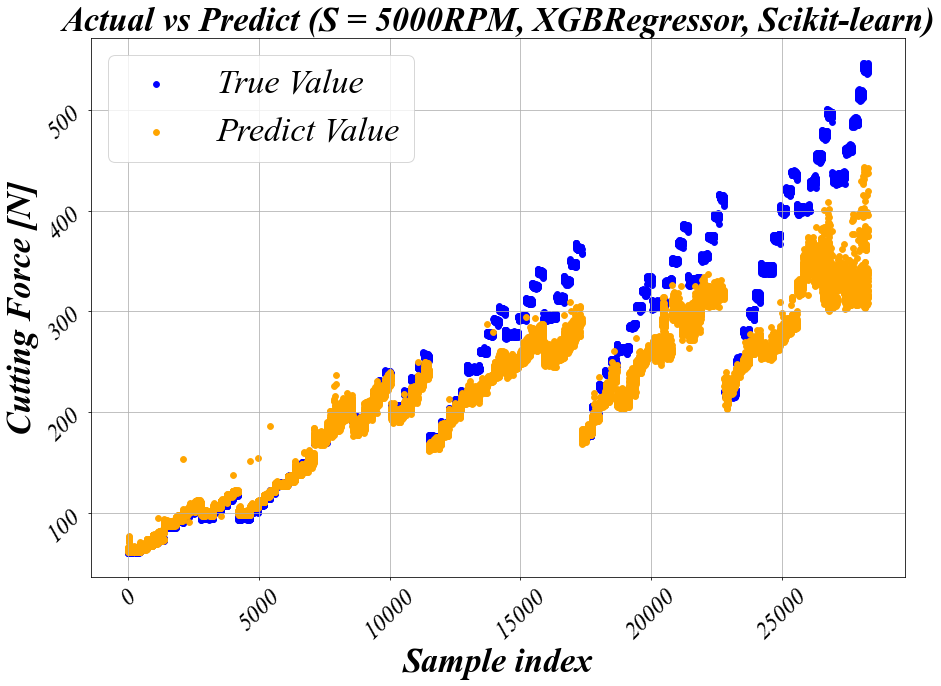

In [181]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 5000RPM, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(XGB_test_pred)), XGB_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
fig.savefig("./plot/Predict tuning rpm5000 cycle.png")